In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import ListedColormap
from datetime import datetime 
from pandas import Series, DataFrame 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
 
import lightgbm as lgb 
import xgboost as xgb 

%matplotlib inline

RANDOM_STATE = 42

# ВСЯКИЕ ФУНКЦИИ

In [2]:
def memory_analyse(df):
    for dtype in ['float','int','object']:
        selected_dtype = df.select_dtypes(include=[dtype])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))
        
def show_data(df):
    for col in df.columns:
        if (col == "id") | (col == "price") | (col == "street_id"):
            pass
        else:
            print("{0}: {1}".format(col, df[col].unique()))
    print(df.columns)
    
def find_NaN(df):
    nans = df.loc[:, df.isnull().any()].copy()
    print(nans.columns)
    nans = nans.isna().sum()
    print(nans)

def corr(df, threshold=0.5):
    s1 = pd.Series(df['SalePrice'])
    corr_cols = []
    uncorr_cols = []
    for col in df.columns:
        if df[col].dtype != object:
            s2 = pd.Series(df[col])
            c = s1.corr(s2 )
            if abs(c) >= threshold:
                print("corr {0} with price: {1}".format(col, c))
                corr_cols.append(col)
            else:
                uncorr_cols.append(col)    
    return corr_cols, uncorr_cols

# АНАЛИЗ

In [3]:
pd.set_option('display.max_columns', 200)

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,534,531363010,20,RL,80.0,9605,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,6,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1218.0,1218.0,GasA,Ex,Y,SBrkr,1218,0,0,1218,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Detchd,2007.0,RFn,2.0,576.0,TA,TA,Y,0,178,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal,159000
1,803,906203120,20,RL,90.0,14684,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,7,1990,1991,Hip,CompShg,HdBoard,HdBoard,BrkFace,234.0,Gd,TA,CBlock,Gd,TA,Mn,ALQ,485.0,BLQ,177.0,1496.0,2158.0,GasA,Gd,Y,SBrkr,2196,0,0,2196,0.0,0.0,2,0,3,1,Gd,7,Typ,1,TA,Attchd,1990.0,RFn,3.0,701.0,TA,TA,Y,84,70,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,271900
2,956,916176030,20,RL,NaN,14375,Pave,NaN,IR1,Lvl,NoSeWa,CulDSac,Gtl,Timber,Norm,Norm,1Fam,SLvl,6,6,1958,1958,Gable,CompShg,HdBoard,HdBoard,BrkFace,541.0,TA,TA,CBlock,TA,TA,No,GLQ,111.0,Rec,354.0,354.0,819.0,GasA,Gd,Y,FuseA,1344,0,0,1344,0.0,1.0,1,0,3,1,Gd,7,Typ,1,Gd,Basment,1958.0,RFn,2.0,525.0,TA,TA,Y,0,118,0,0,233,0,NaN,NaN,NaN,0,1,2009,COD,Abnorml,137500
3,460,528180130,120,RL,48.0,6472,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,9,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,BrkFace,500.0,Ex,TA,PConc,Ex,TA,No,Unf,0.0,Unf,0.0,1451.0,1451.0,GasA,Ex,Y,SBrkr,1456,0,0,1456,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2008.0,RFn,2.0,539.0,TA,TA,Y,192,42,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,Normal,248500
4,487,528290030,80,RL,61.0,9734,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,SLvl,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,241.0,Rec,113.0,30.0,384.0,GasA,Ex,Y,SBrkr,744,630,0,1374,0.0,0.0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2004.0,Fin,2.0,400.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,167000


In [5]:
train.shape

(2197, 82)

In [6]:
train.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [7]:
train.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2197.000000,2.197000e+03,2197.000000,1835.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2175.000000,2196.000000,2196.000000,2196.000000,2196.000000,2197.000000,2197.00000,2197.000000,2197.000000,2196.000000,2196.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2075.000000,2196.000000,2196.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000
mean,1460.512517,7.127872e+08,57.064178,69.549319,10268.070096,6.116523,5.552572,1972.030951,1984.781065,105.101609,445.502277,49.341985,567.176685,1062.020947,1171.744652,331.93218,4.196632,1507.873464,0.425774,0.063297,1.592626,0.369595,2.858898,1.049158,6.470642,0.598999,1978.890120,1.781876,476.715847,92.436959,48.768320,22.393719,2.361402,15.954028,2.789713,57.404188,6.189804,2007.793810,182376.851161
std,846.537251,1.887751e+08,42.360690,23.188224,7975.740885,1.429613,1.107019,30.450069,20.898245,184.897165,465.845264,170.644815,445.327392,456.535482,398.204596,430.76106,45.896142,511.844406,0.524958,0.249100,0.553347,0.500405,0.834769,0.224512,1.591381,0.647862,25.753701,0.762599,215.999290,121.422842,69.127588,62.063281,22.843004,56.495484,39.991010,639.103790,2.746902,1.314345,81168.157405
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.00000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,13100.000000
25%,733.000000,5.284410e+08,20.000000,58.500000,7500.000000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,225.750000,793.000000,882.000000,0.00000,0.000000,1142.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,130000.000000
50%,1452.000000,5.354532e+08,50.000000,69.000000,9488.000000,6.000000,5.000000,1975.000000,1994.000000,0.000000,368.000000,0.000000,469.500000,998.500000,1097.000000,0.00000,0.000000,1452.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1981.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163500.000000
75%,2196.000000,9.071811e+08,70.000000,80.000000,11660.000000,7.000000,6.000000,2002.000000,2004.000000,166.000000,739.000000,0.000000,809.250000,1338.000000,1422.000000,702.00000,0.000000,1762.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2003.000000,2.000000,577.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215000.000000
max,2929.000000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.00000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,870.000000,742.000000,584.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [8]:
train.describe(include=['object'])

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Central Air,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
count,2197,2197,143,2197,2197,2197,2197,2197,2197,2197,2197,2197,2197,2197,2197,2197,2197,2175,2197,2197,2197,2130,2130,2128,2130,2129,2197,2197,2197,2196,2197,2197,1131,2077,2075,2075,2075,2197,12,419,80,2197,2197
unique,7,2,2,4,4,3,5,3,28,9,8,5,8,6,8,16,17,5,4,5,6,5,5,4,6,6,6,5,2,5,5,8,5,6,3,5,5,3,4,4,5,10,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1704,2188,87,1389,1983,2194,1597,2091,324,1894,2175,1815,1123,1735,2166,790,782,1307,1321,1922,1001,930,1970,1406,664,1871,2158,1126,2048,2020,1105,2037,564,1318,902,1957,1993,1986,4,243,72,1898,1809


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 82 columns):
Order              2197 non-null int64
PID                2197 non-null int64
MS SubClass        2197 non-null int64
MS Zoning          2197 non-null object
Lot Frontage       1835 non-null float64
Lot Area           2197 non-null int64
Street             2197 non-null object
Alley              143 non-null object
Lot Shape          2197 non-null object
Land Contour       2197 non-null object
Utilities          2197 non-null object
Lot Config         2197 non-null object
Land Slope         2197 non-null object
Neighborhood       2197 non-null object
Condition 1        2197 non-null object
Condition 2        2197 non-null object
Bldg Type          2197 non-null object
House Style        2197 non-null object
Overall Qual       2197 non-null int64
Overall Cond       2197 non-null int64
Year Built         2197 non-null int64
Year Remod/Add     2197 non-null int64
Roof Style         21

In [10]:
memory_analyse(train)

Average memory usage for float columns: 0.02 MB
Average memory usage for int columns: 0.02 MB
Average memory usage for object columns: 0.12 MB


In [11]:
for col in train.columns:
    if train[col].dtype == float:        
        test[col] = test[col].astype('float32')
        train[col] = train[col].astype('float32')
    if (train[col].dtype == int) & (col != 'PID') & (col != 'SalePrice'):
        test[col] = test[col].astype('int32')
        train[col] = train[col].astype('int32')

In [12]:
memory_analyse(train)

Average memory usage for float columns: 0.00 MB
Average memory usage for int columns: 0.01 MB
Average memory usage for object columns: 0.12 MB


In [13]:
show_data(train)

Order: [ 534  803  956 ... 1097  236 1062]
PID: [531363010 906203120 916176030 ... 528292060 905426060 528142020]
MS SubClass: [ 20 120  80  60 180  30  85  70  50 190  90 160  45  75  40]
MS Zoning: ['RL' 'RM' 'FV' 'RH' 'C (all)' 'I (all)' 'A (agr)']
Lot Frontage: [ 80.  90.  nan  48.  61.  70.  71.  65.  21. 104. 113.  34.  55.  60.
  78.  68.  39.  53.  52.  73.  85.  50. 100.  75.  58.  59.  56.  88.
  41. 124.  40. 117. 131.  62.  95.  69.  43.  63.  36. 116.  86. 110.
  72.  98.  67.  54.  79.  46.  74.  66.  76.  51.  42.  25. 118. 134.
  83.  44.  35. 153. 102.  94.  96. 160.  77.  64.  82. 130.  33. 109.
  97.  57. 107.  81.  93.  89. 114. 152. 120. 103.  38. 108.  30.  84.
 136.  92.  91. 105.  26.  37.  45.  47.  24.  99. 106. 129.  87. 313.
 141. 138. 121. 101. 115.  49. 174. 128.  32. 125.  28. 112. 126. 149.
 168. 140. 122. 133. 182. 150. 195. 200. 119.  31. 144.]
Lot Area: [ 9605 14684 14375 ... 10041 12460  8899]
Street: ['Pave' 'Grvl']
Alley: [nan 'Grvl' 'Pave']
Lot Sh

In [14]:
find_NaN(train)

Index(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')
Lot Frontage       362
Alley             2054
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           67
Bsmt Cond           67
Bsmt Exposure       69
BsmtFin Type 1      67
BsmtFin SF 1         1
BsmtFin Type 2      68
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       1
Bsmt Half Bath       1
Fireplace Qu      1066
Garage Type        120
Garage Yr Blt      122
Garage Finish      122
Garage Cars          1
Garage Area          1
Garage Qual

In [15]:
train.shape

(2197, 82)

In [16]:
unnesessary = ['Alley', 'Pool QC', 'Fence', 'Misc Feature', 'Fireplace Qu']
nesessary = train.columns.drop(unnesessary)

In [17]:
find_NaN(train)

Index(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence',
       'Misc Feature'],
      dtype='object')
Lot Frontage       362
Alley             2054
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           67
Bsmt Cond           67
Bsmt Exposure       69
BsmtFin Type 1      67
BsmtFin SF 1         1
BsmtFin Type 2      68
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       1
Bsmt Half Bath       1
Fireplace Qu      1066
Garage Type        120
Garage Yr Blt      122
Garage Finish      122
Garage Cars          1
Garage Area          1
Garage Qual

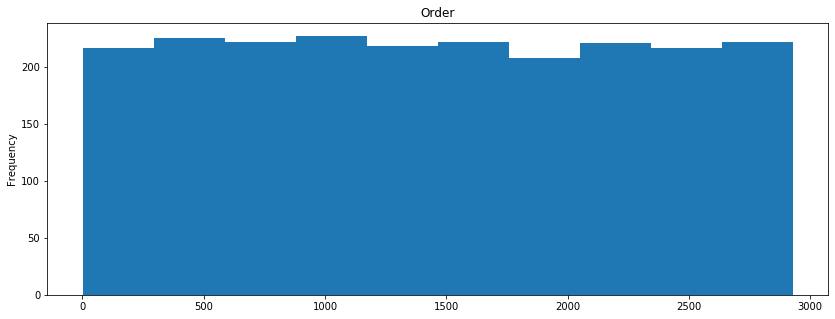

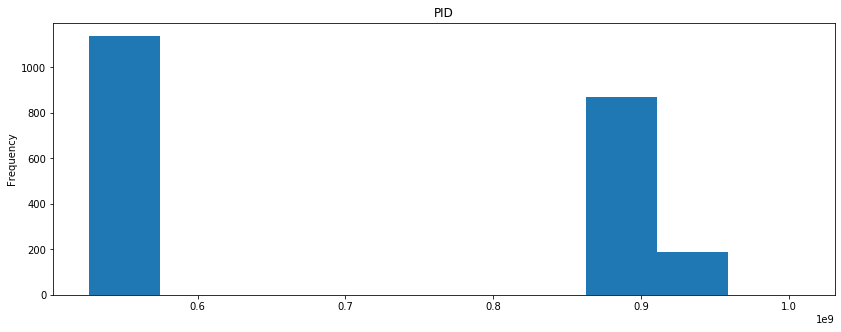

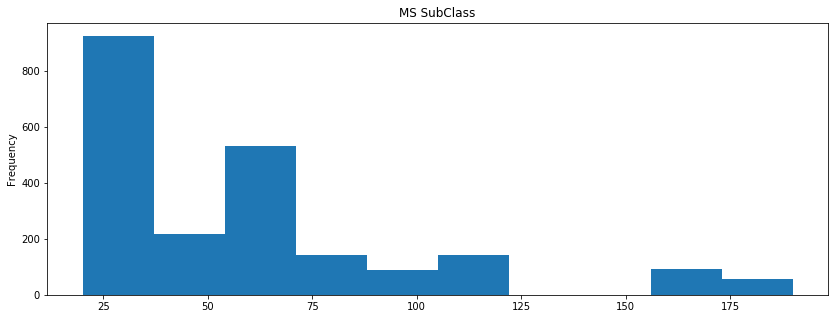

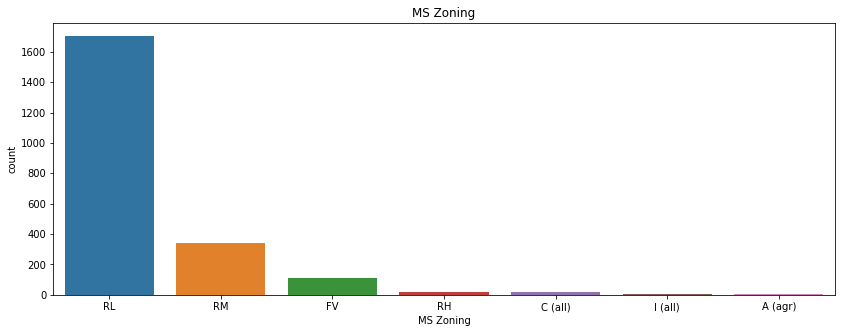

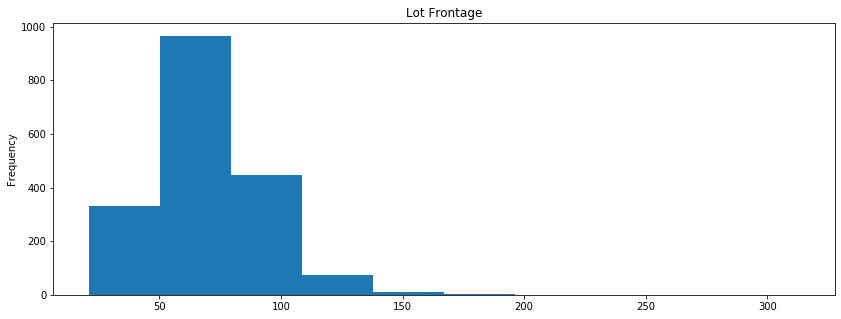

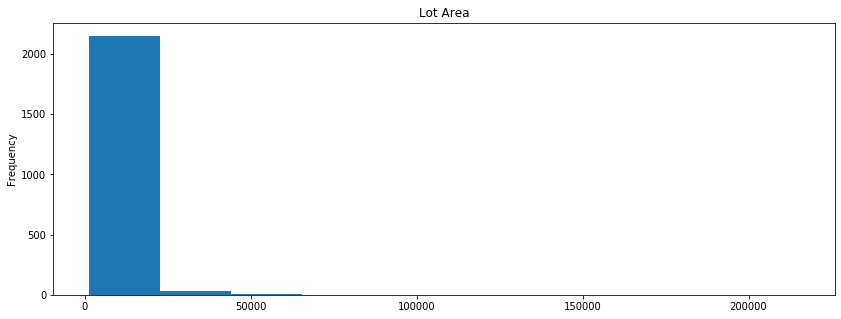

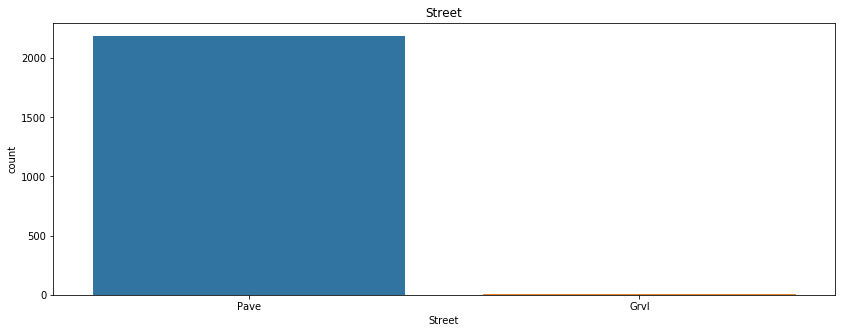

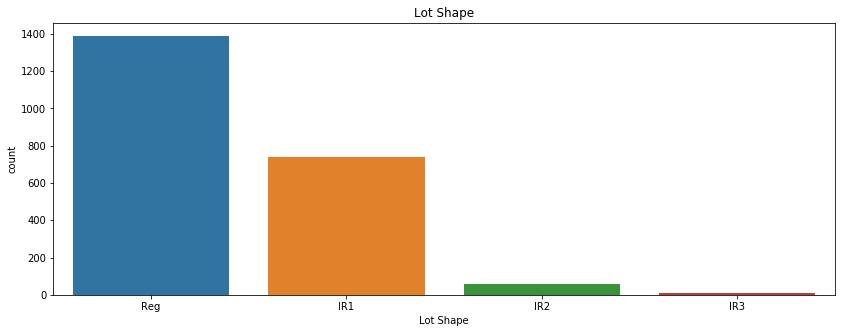

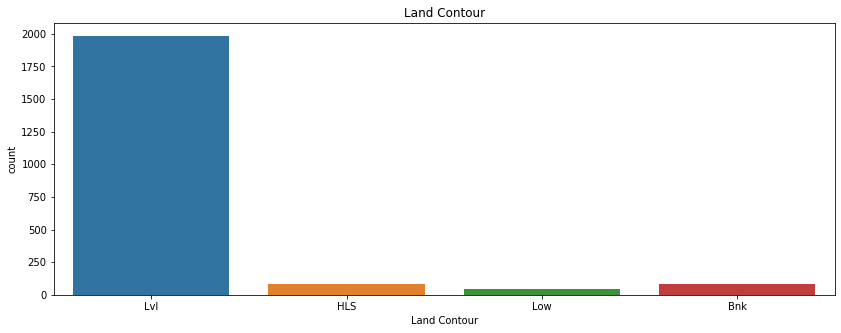

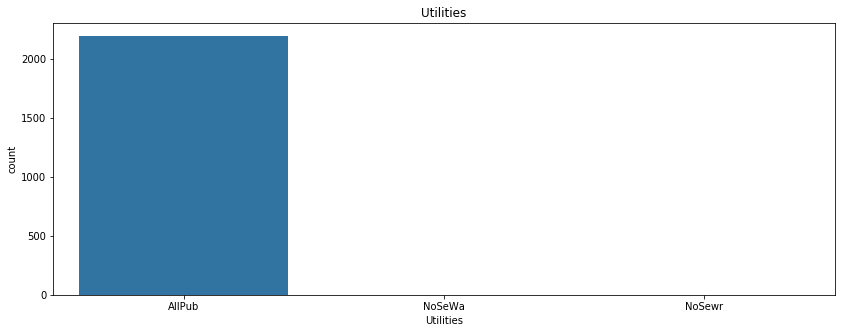

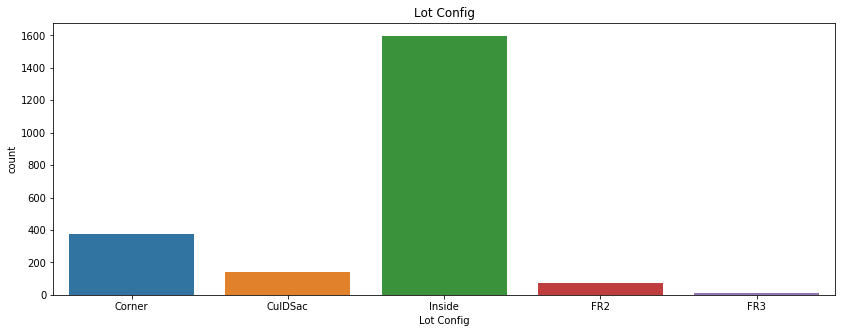

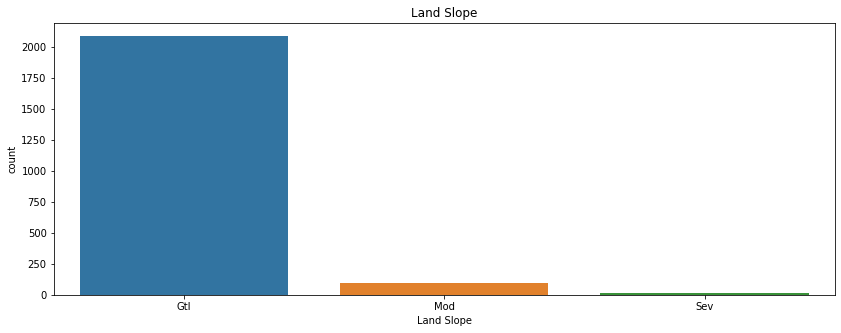

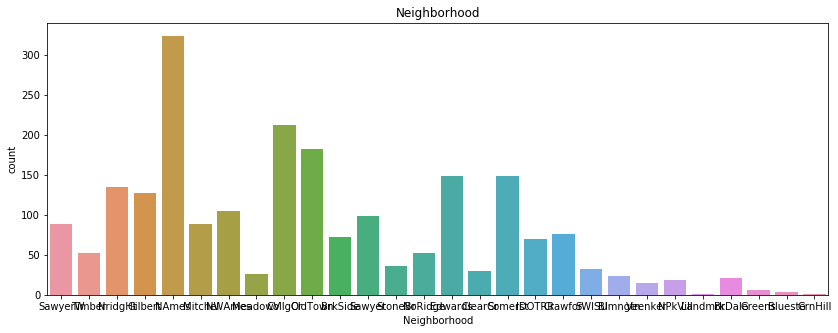

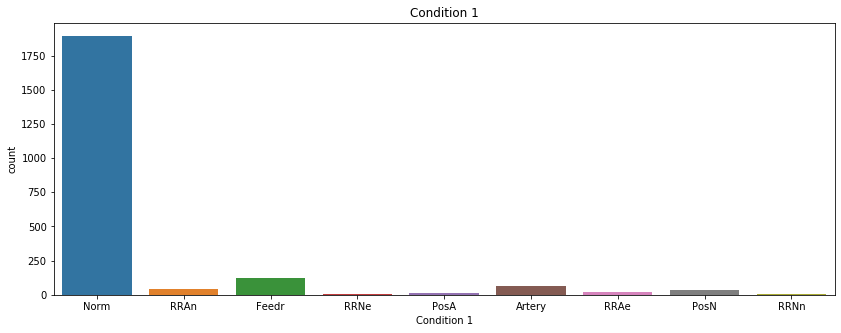

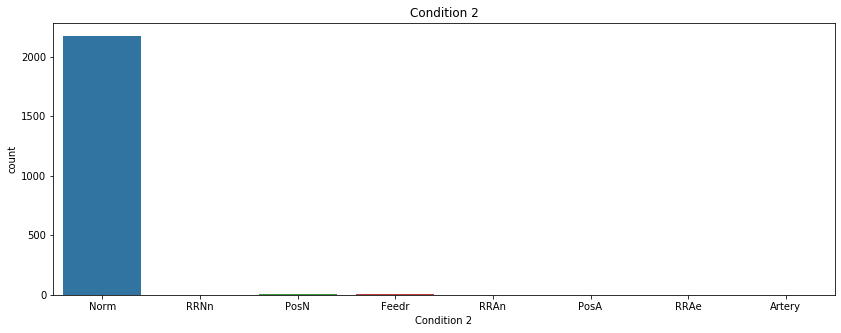

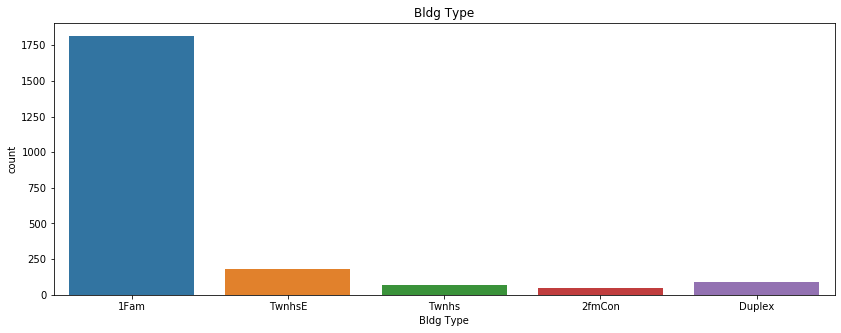

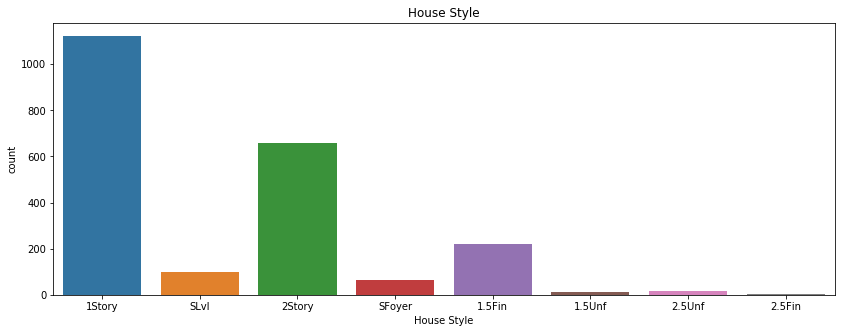

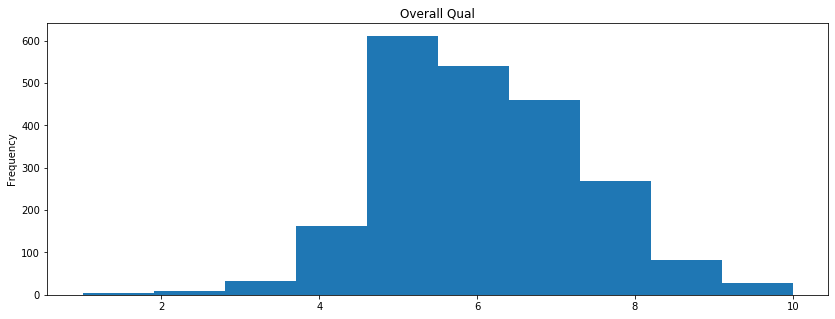

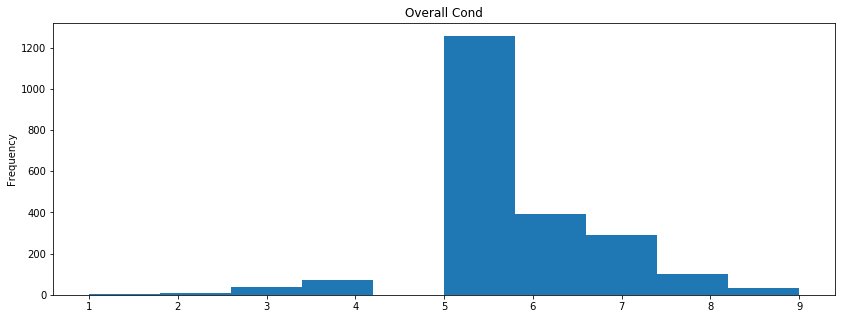

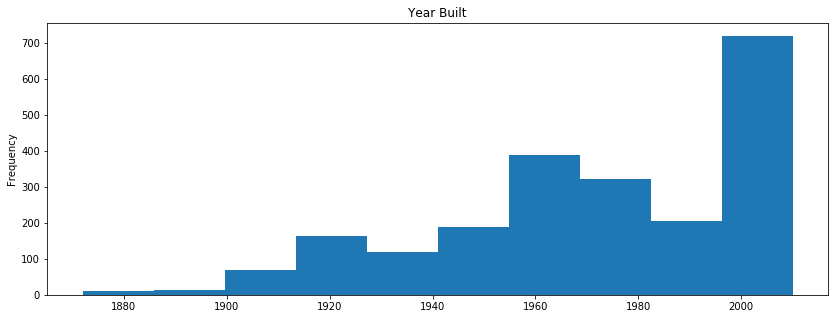

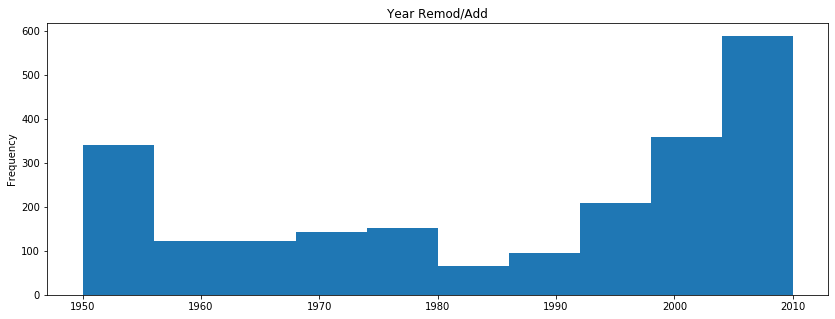

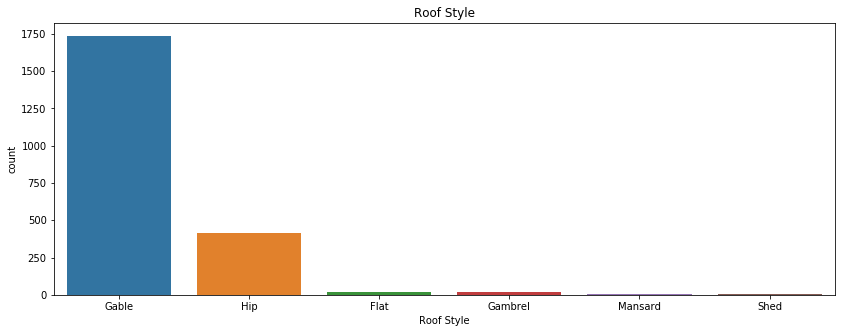

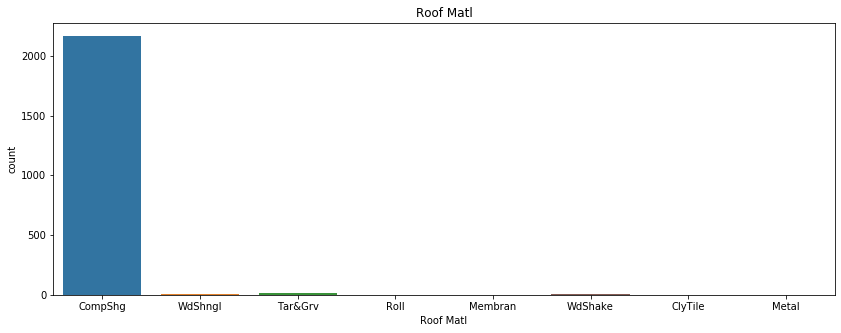

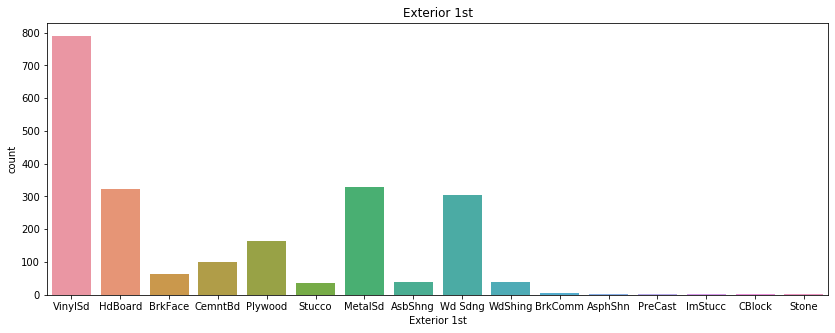

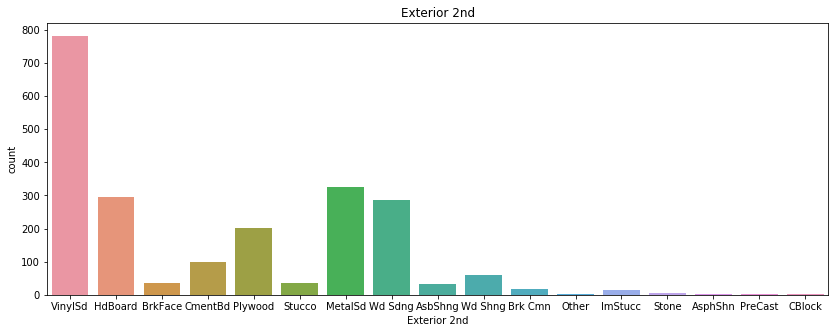

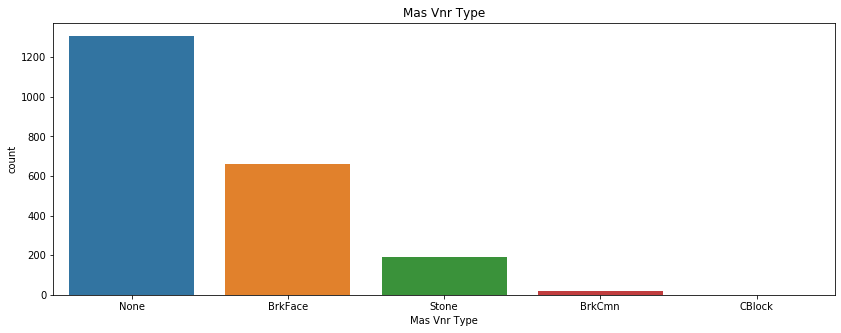

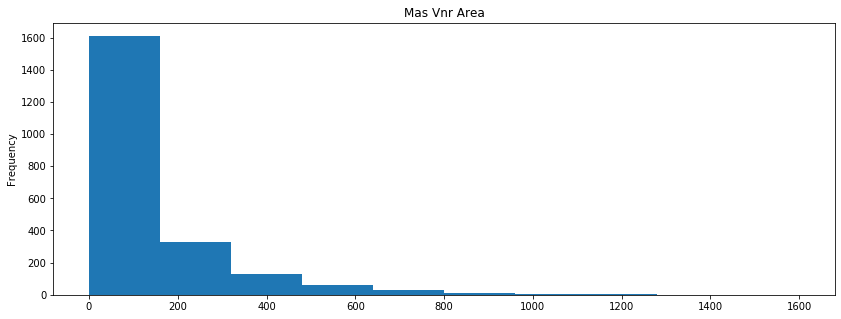

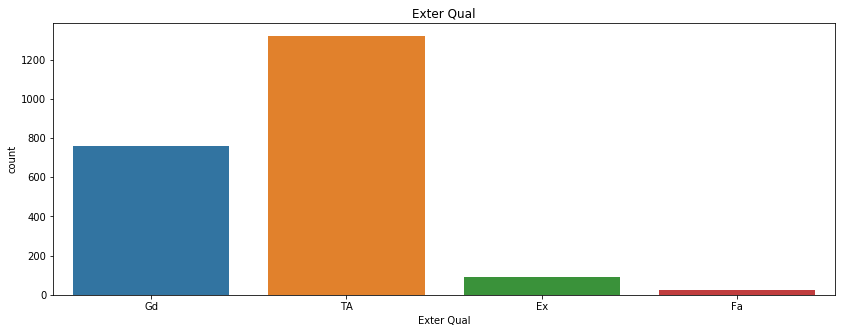

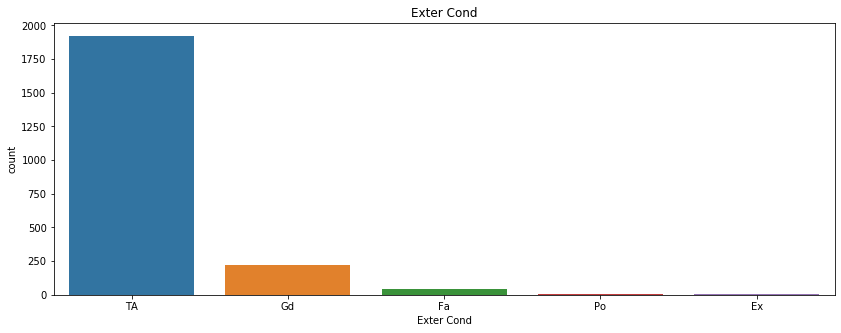

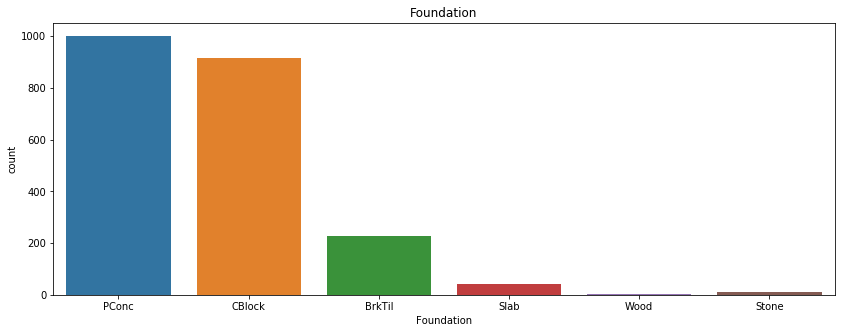

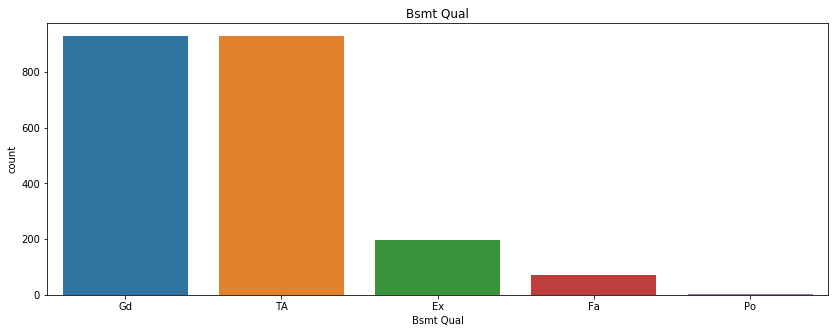

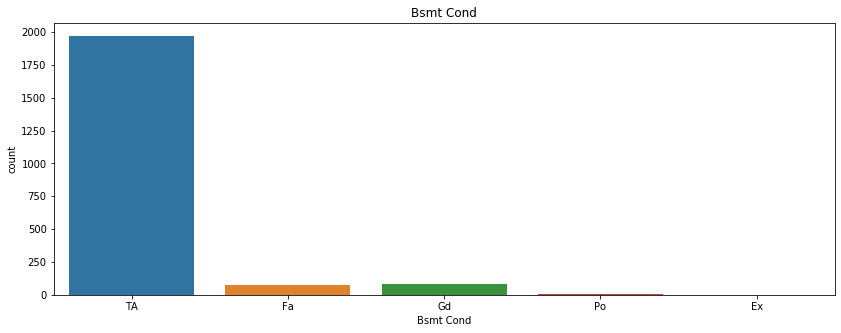

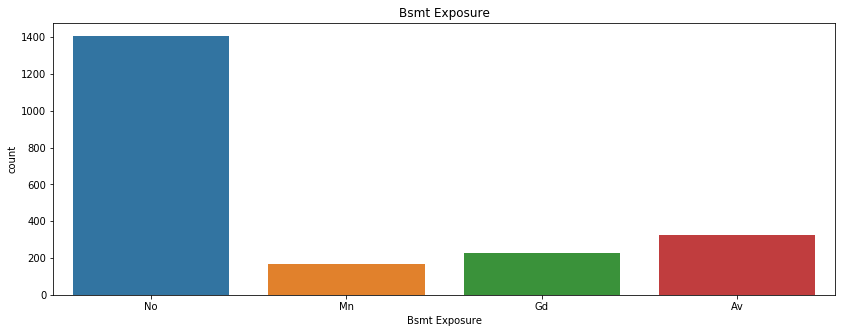

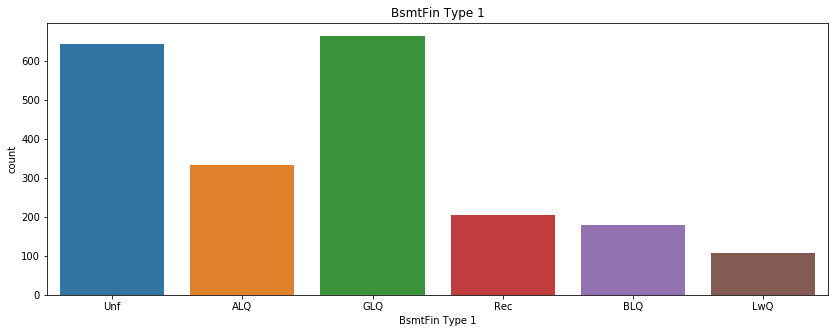

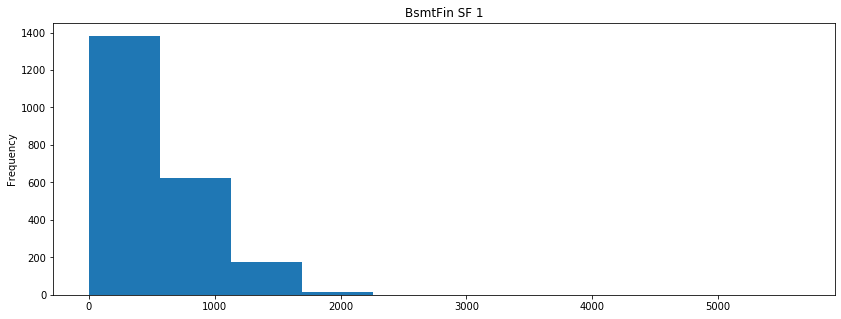

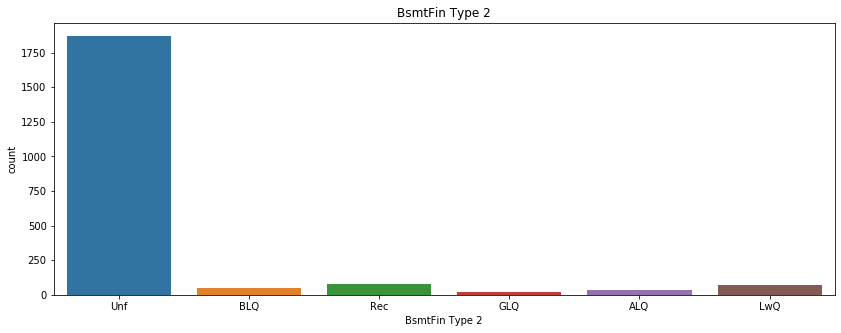

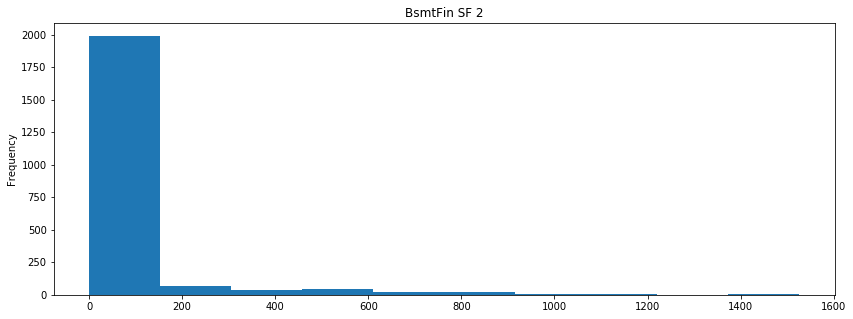

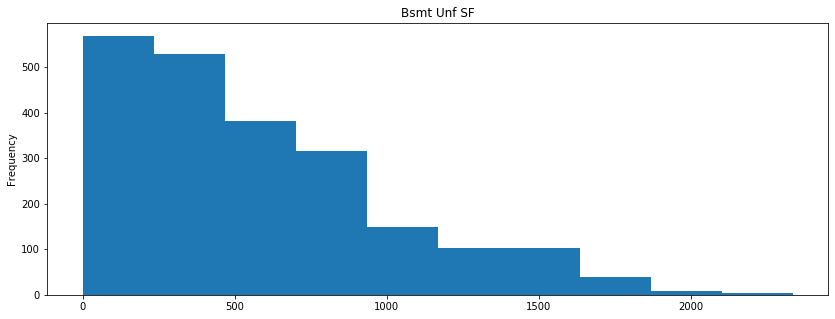

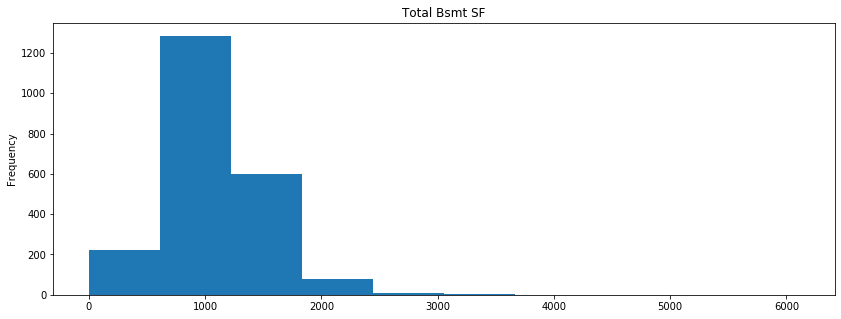

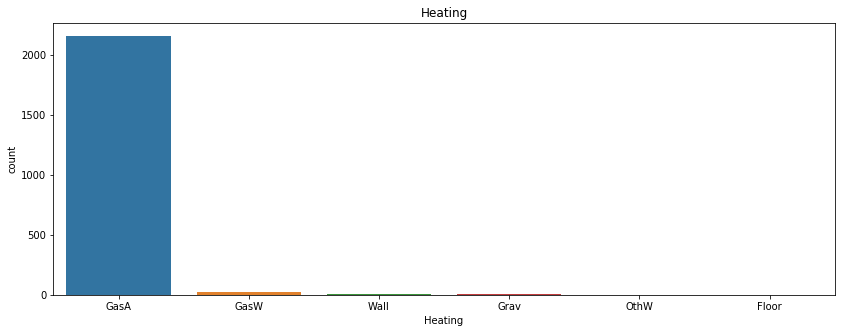

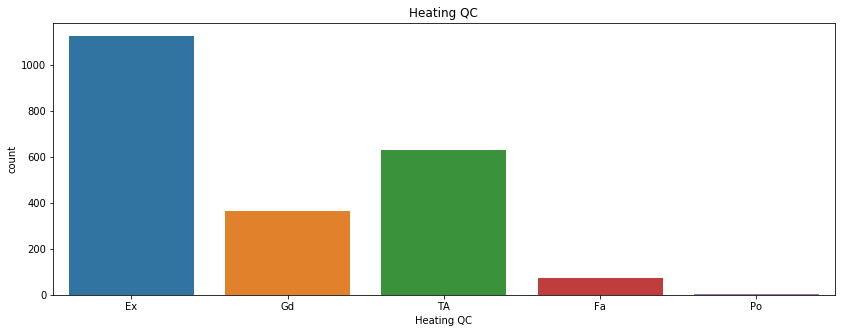

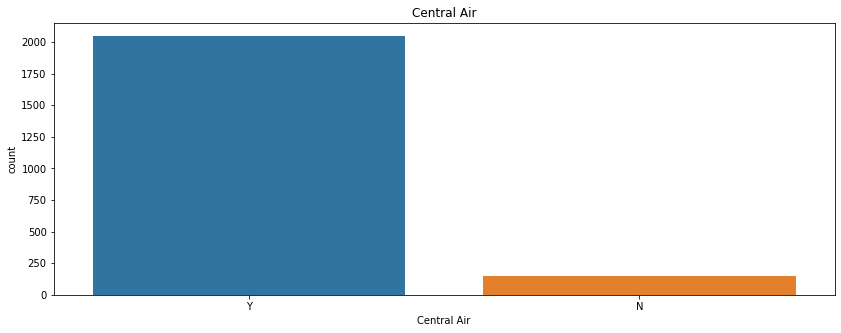

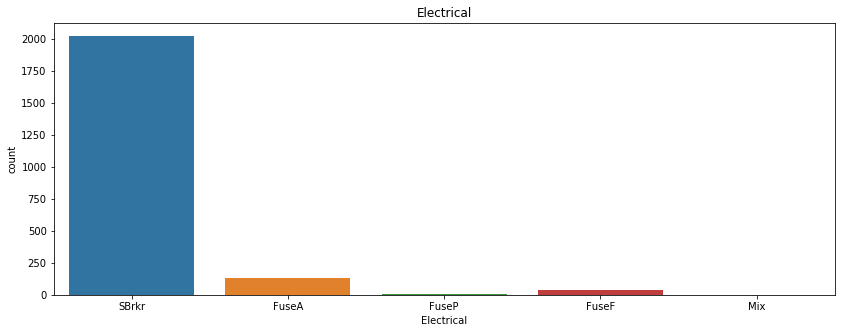

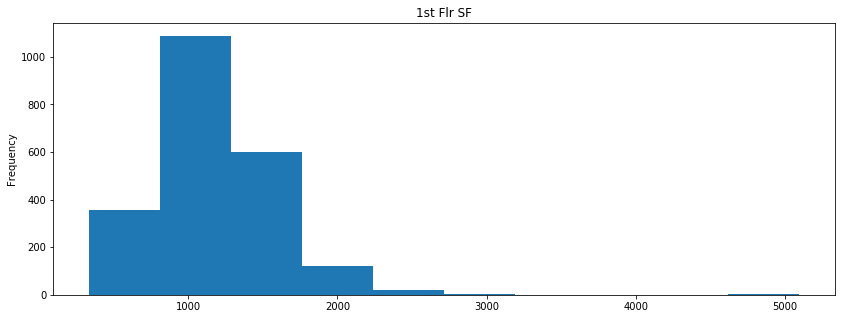

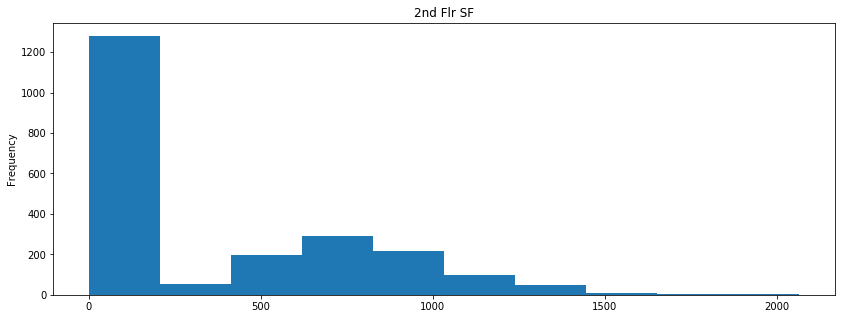

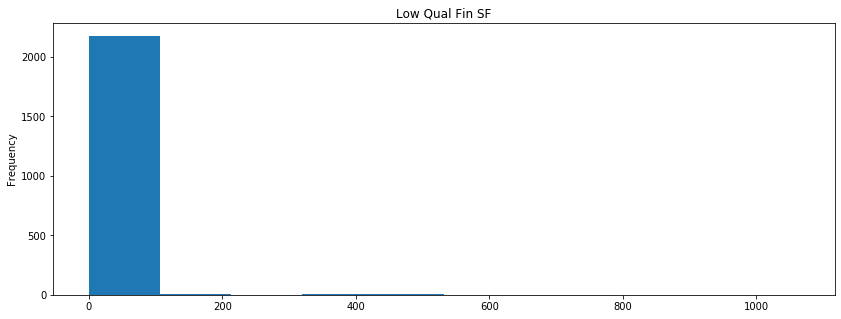

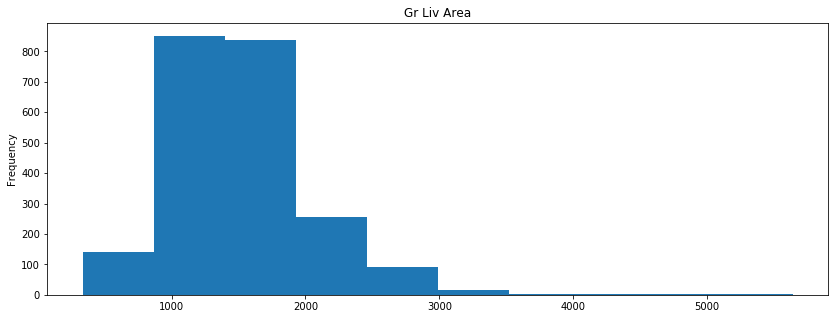

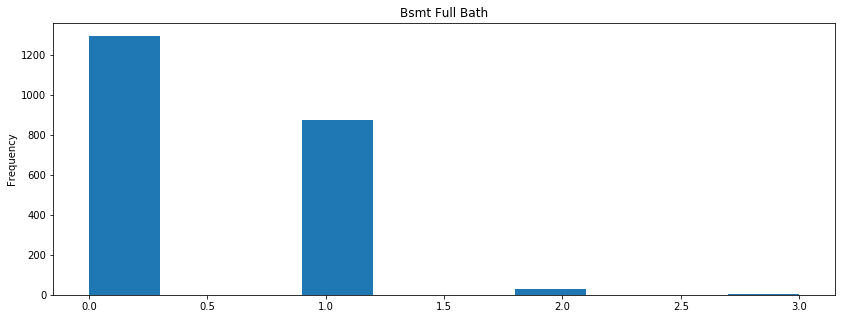

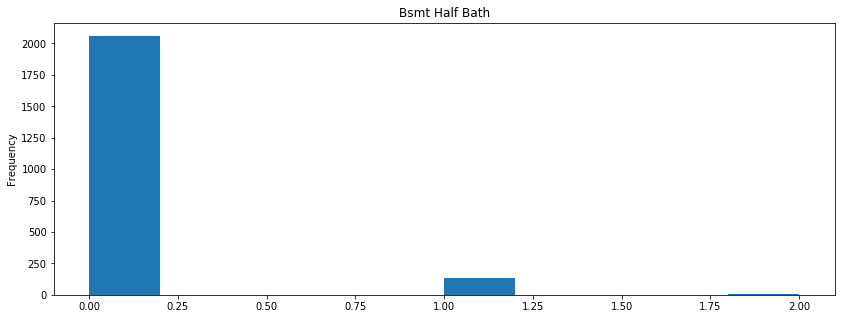

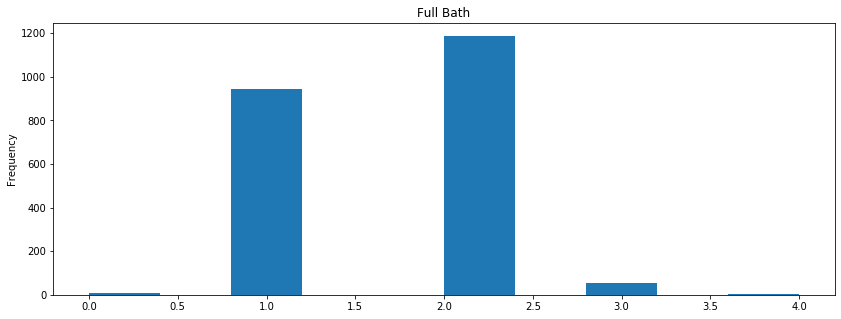

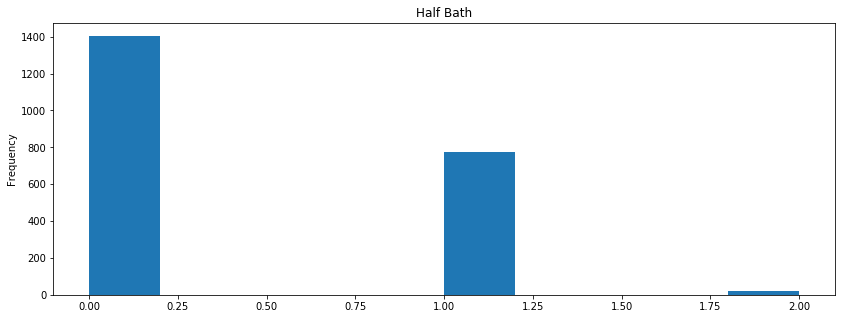

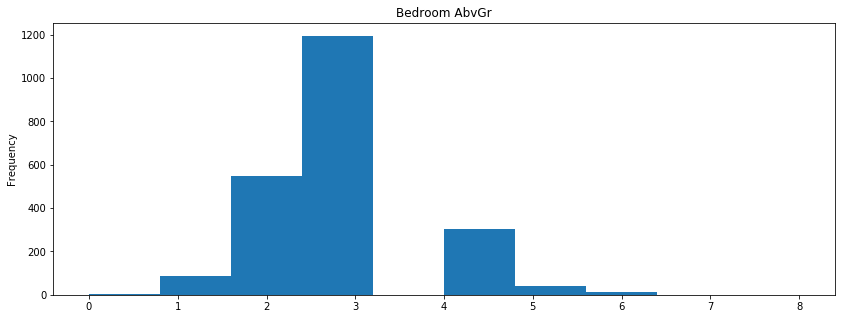

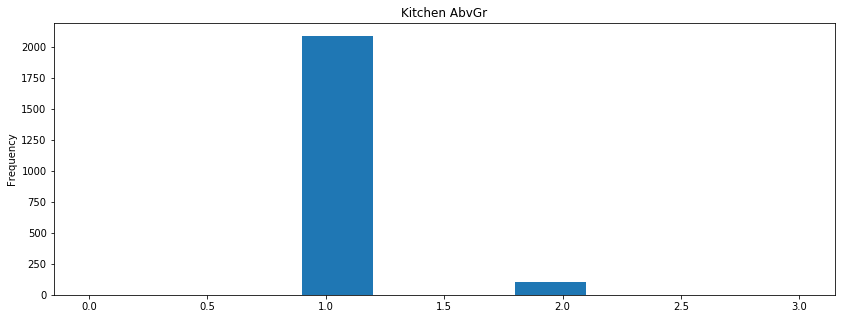

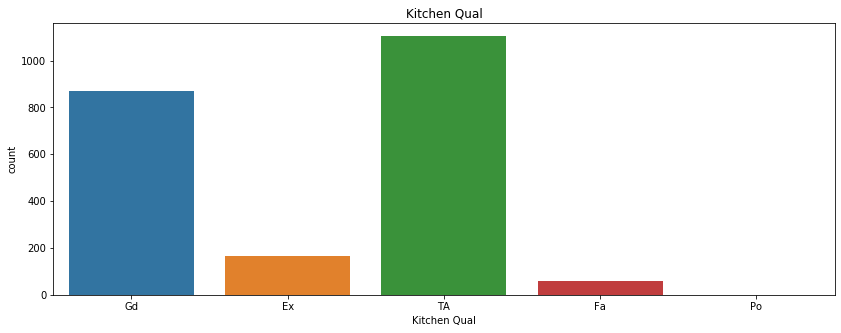

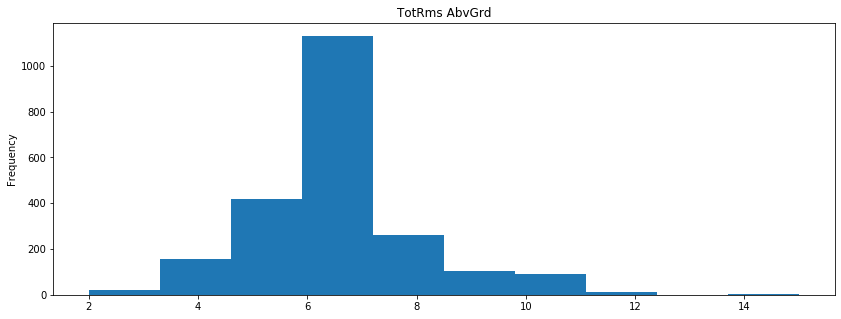

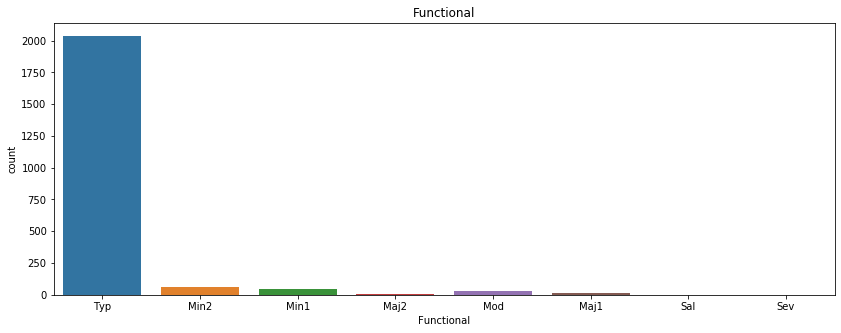

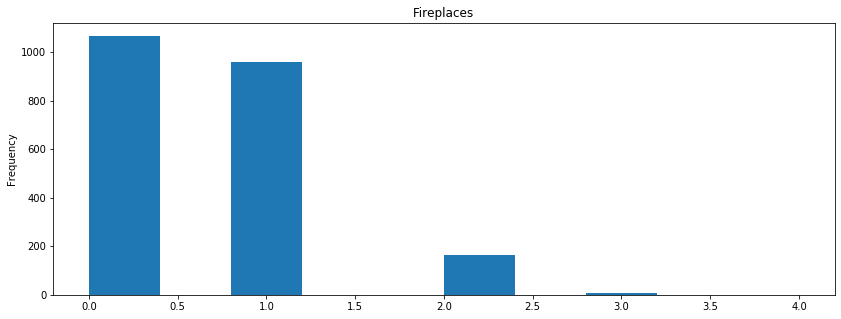

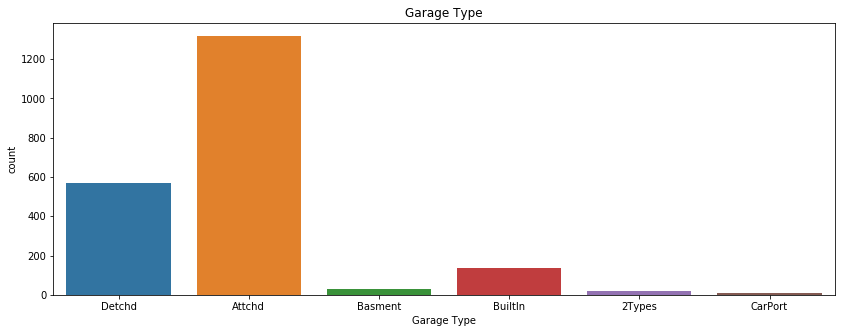

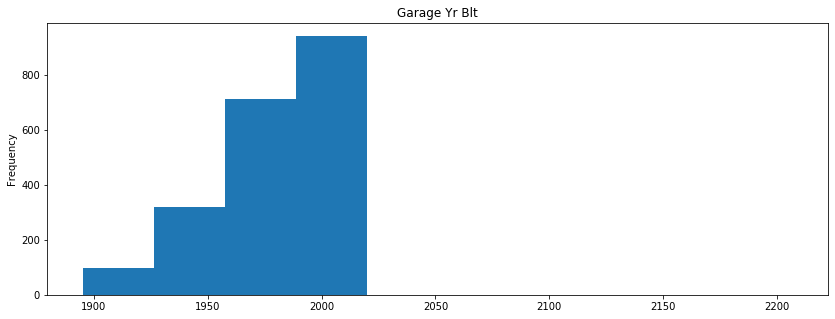

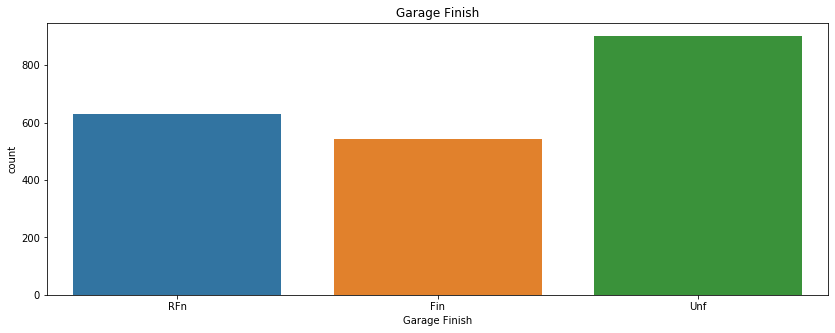

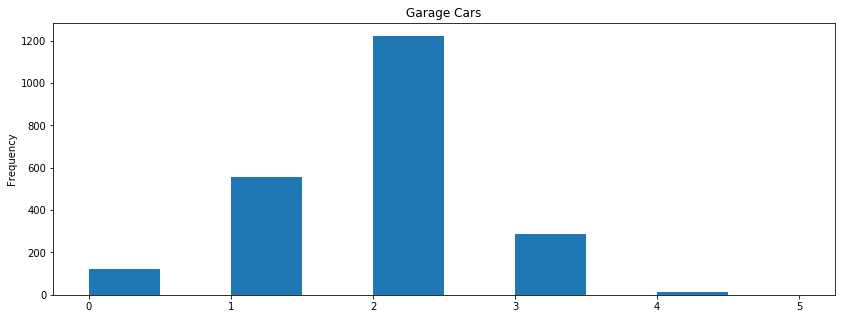

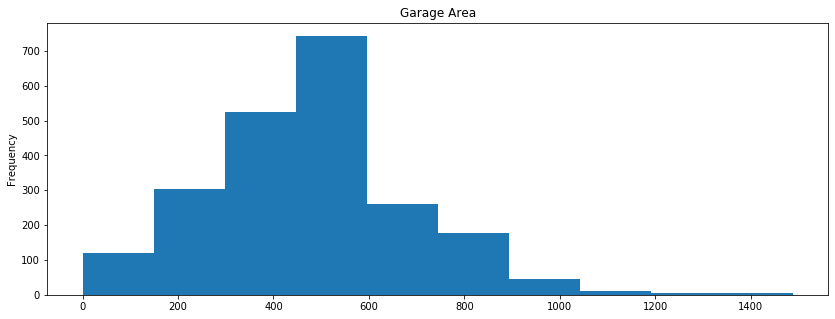

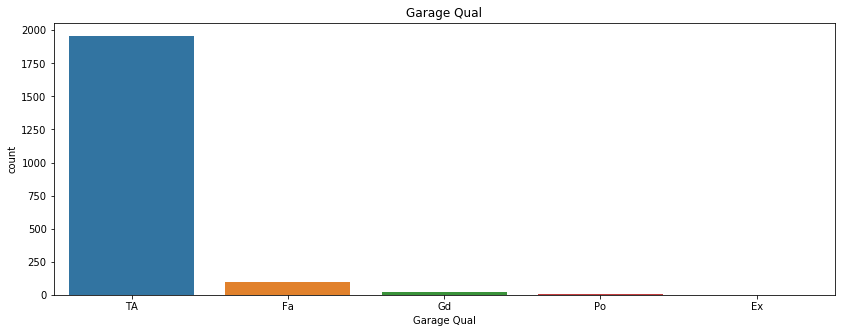

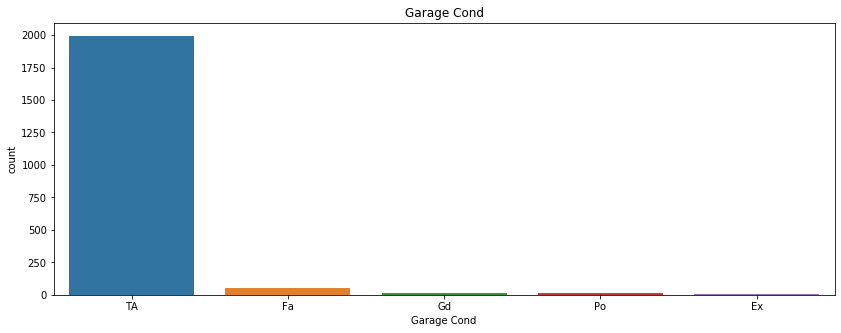

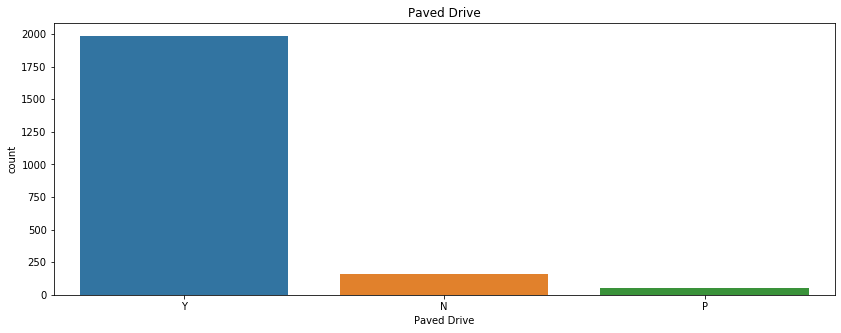

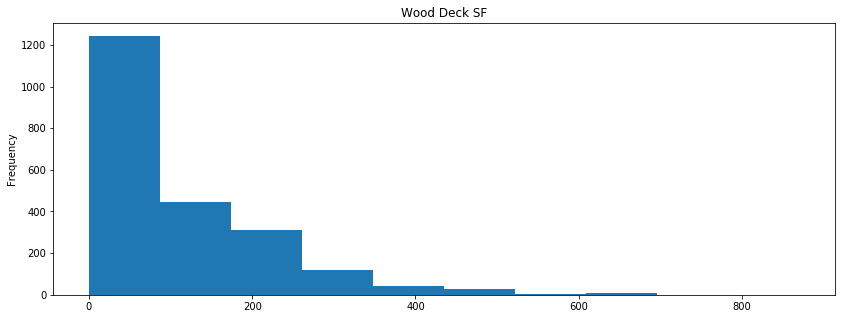

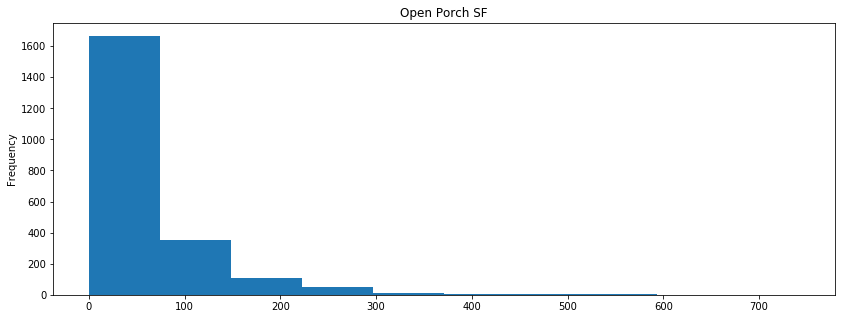

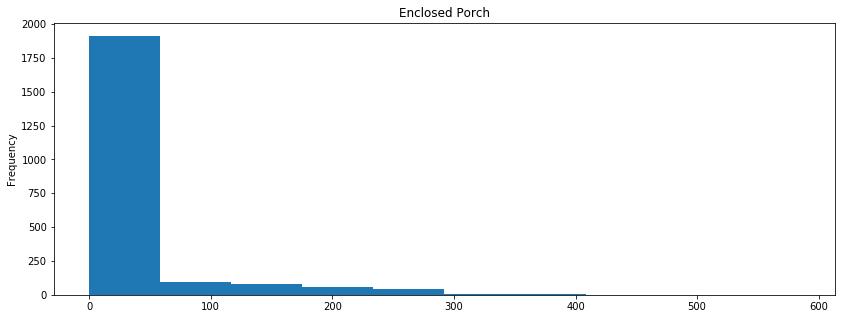

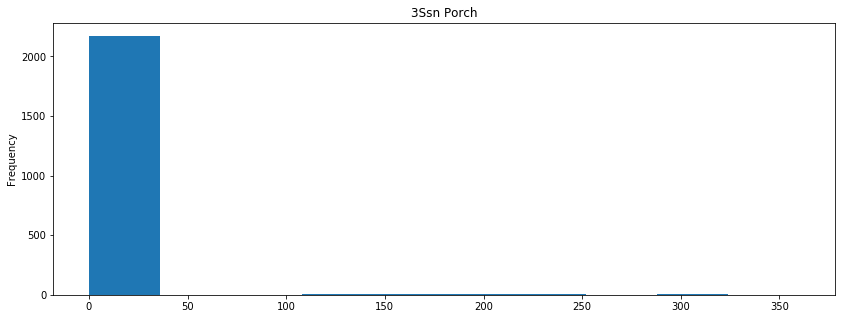

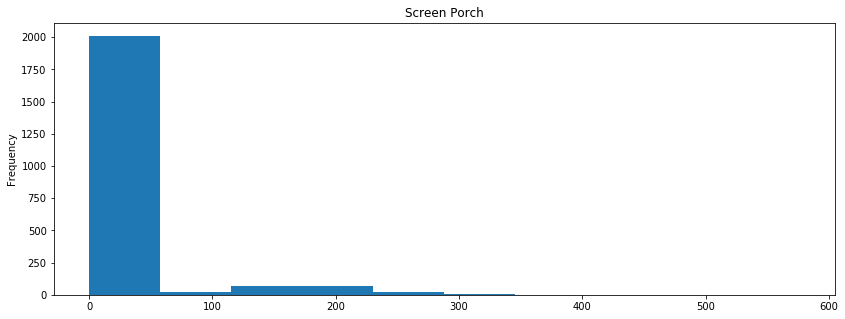

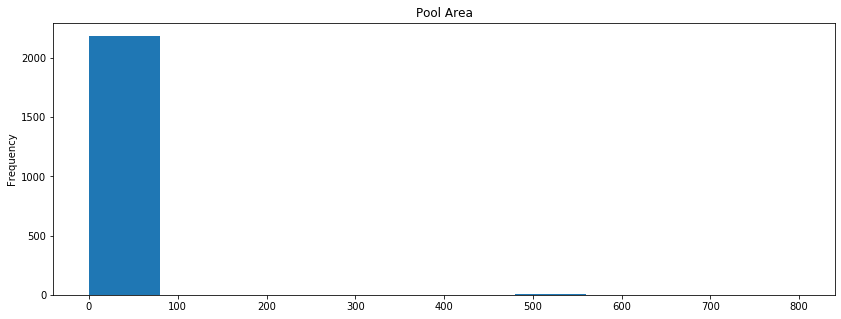

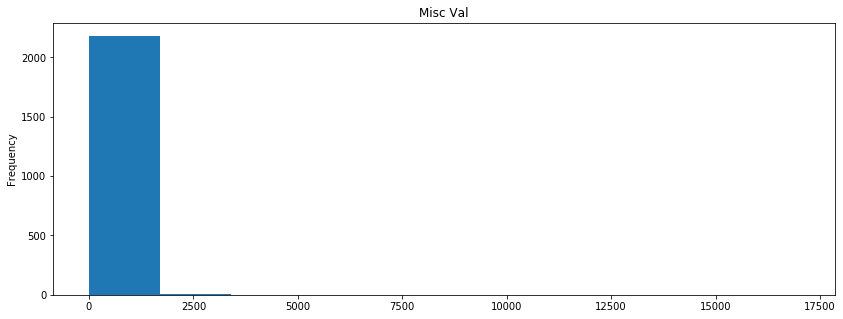

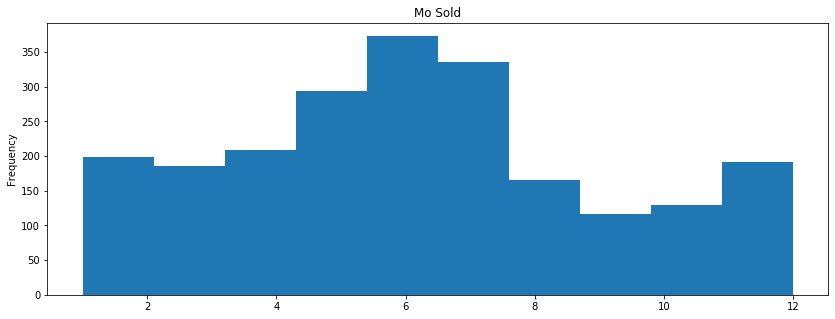

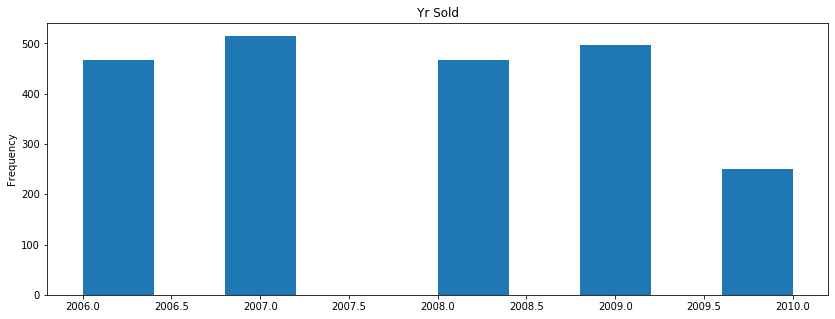

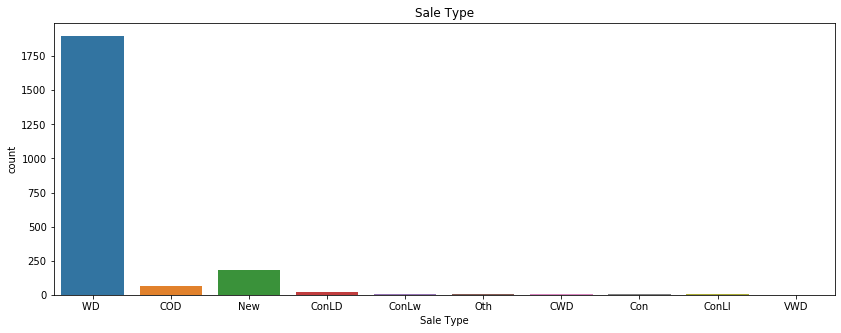

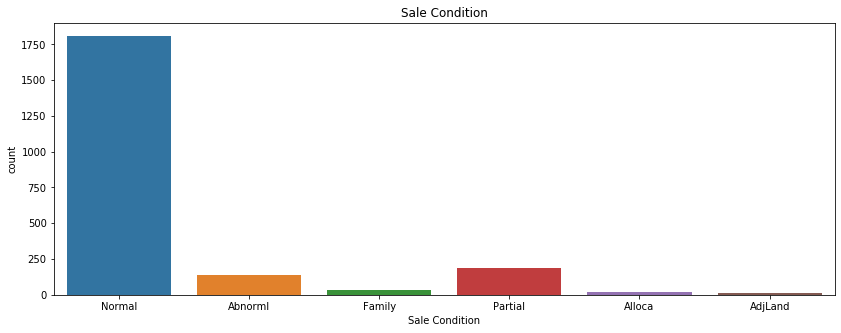

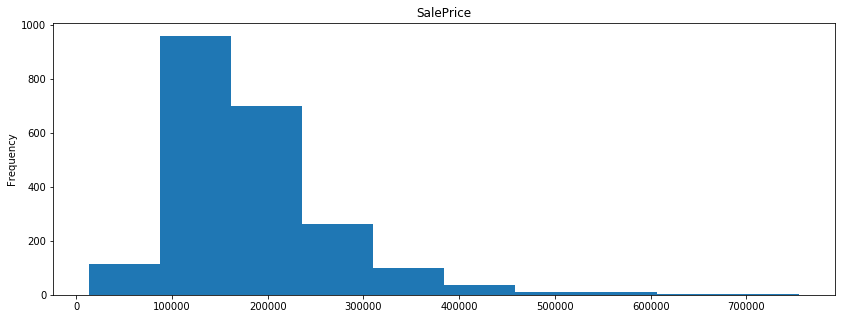

In [18]:
for col in nesessary:
    if train[col].dtype == object:
        fig = plt.figure(figsize=(14,5))
        plt.title(col)
        sns.countplot(train[col])
    else:
        fig = plt.figure(figsize=(14,5))
        plt.title(col)
        train[col].plot.hist(bins=10)

In [19]:
most_corr_cols, not_corr = corr(train)
unnesessary = unnesessary + not_corr
nesessary = train.columns.drop(unnesessary)
unnesessary

corr Overall Qual with price: 0.7999283301254436
corr Year Built with price: 0.5599749453883133
corr Year Remod/Add with price: 0.5313409904270119
corr Mas Vnr Area with price: 0.5137578573388994
corr Total Bsmt SF with price: 0.629263322130809
corr 1st Flr SF with price: 0.6191638606412259
corr Gr Liv Area with price: 0.6996746308182467
corr Full Bath with price: 0.5478145643173974
corr Garage Yr Blt with price: 0.5185544734947679
corr Garage Cars with price: 0.6440907424901234
corr Garage Area with price: 0.6374274217626136
corr SalePrice with price: 0.9999999999999998


['Alley',
 'Pool QC',
 'Fence',
 'Misc Feature',
 'Fireplace Qu',
 'Order',
 'PID',
 'MS SubClass',
 'Lot Frontage',
 'Lot Area',
 'Overall Cond',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold']

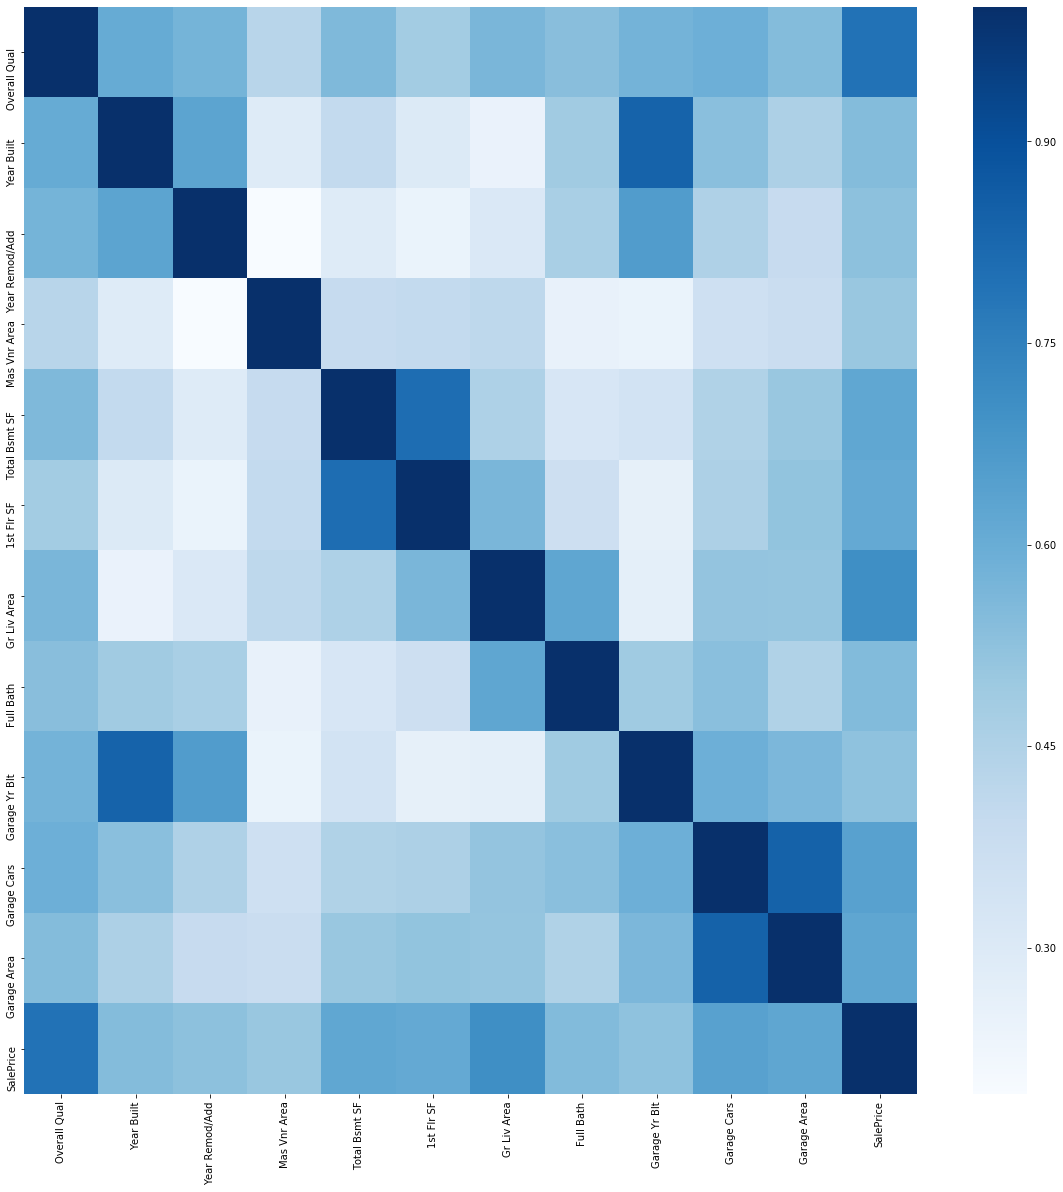

In [20]:
fig = plt.figure(figsize= (20,20))
sns.heatmap(train[most_corr_cols].dropna().corr(), cmap = 'Blues')

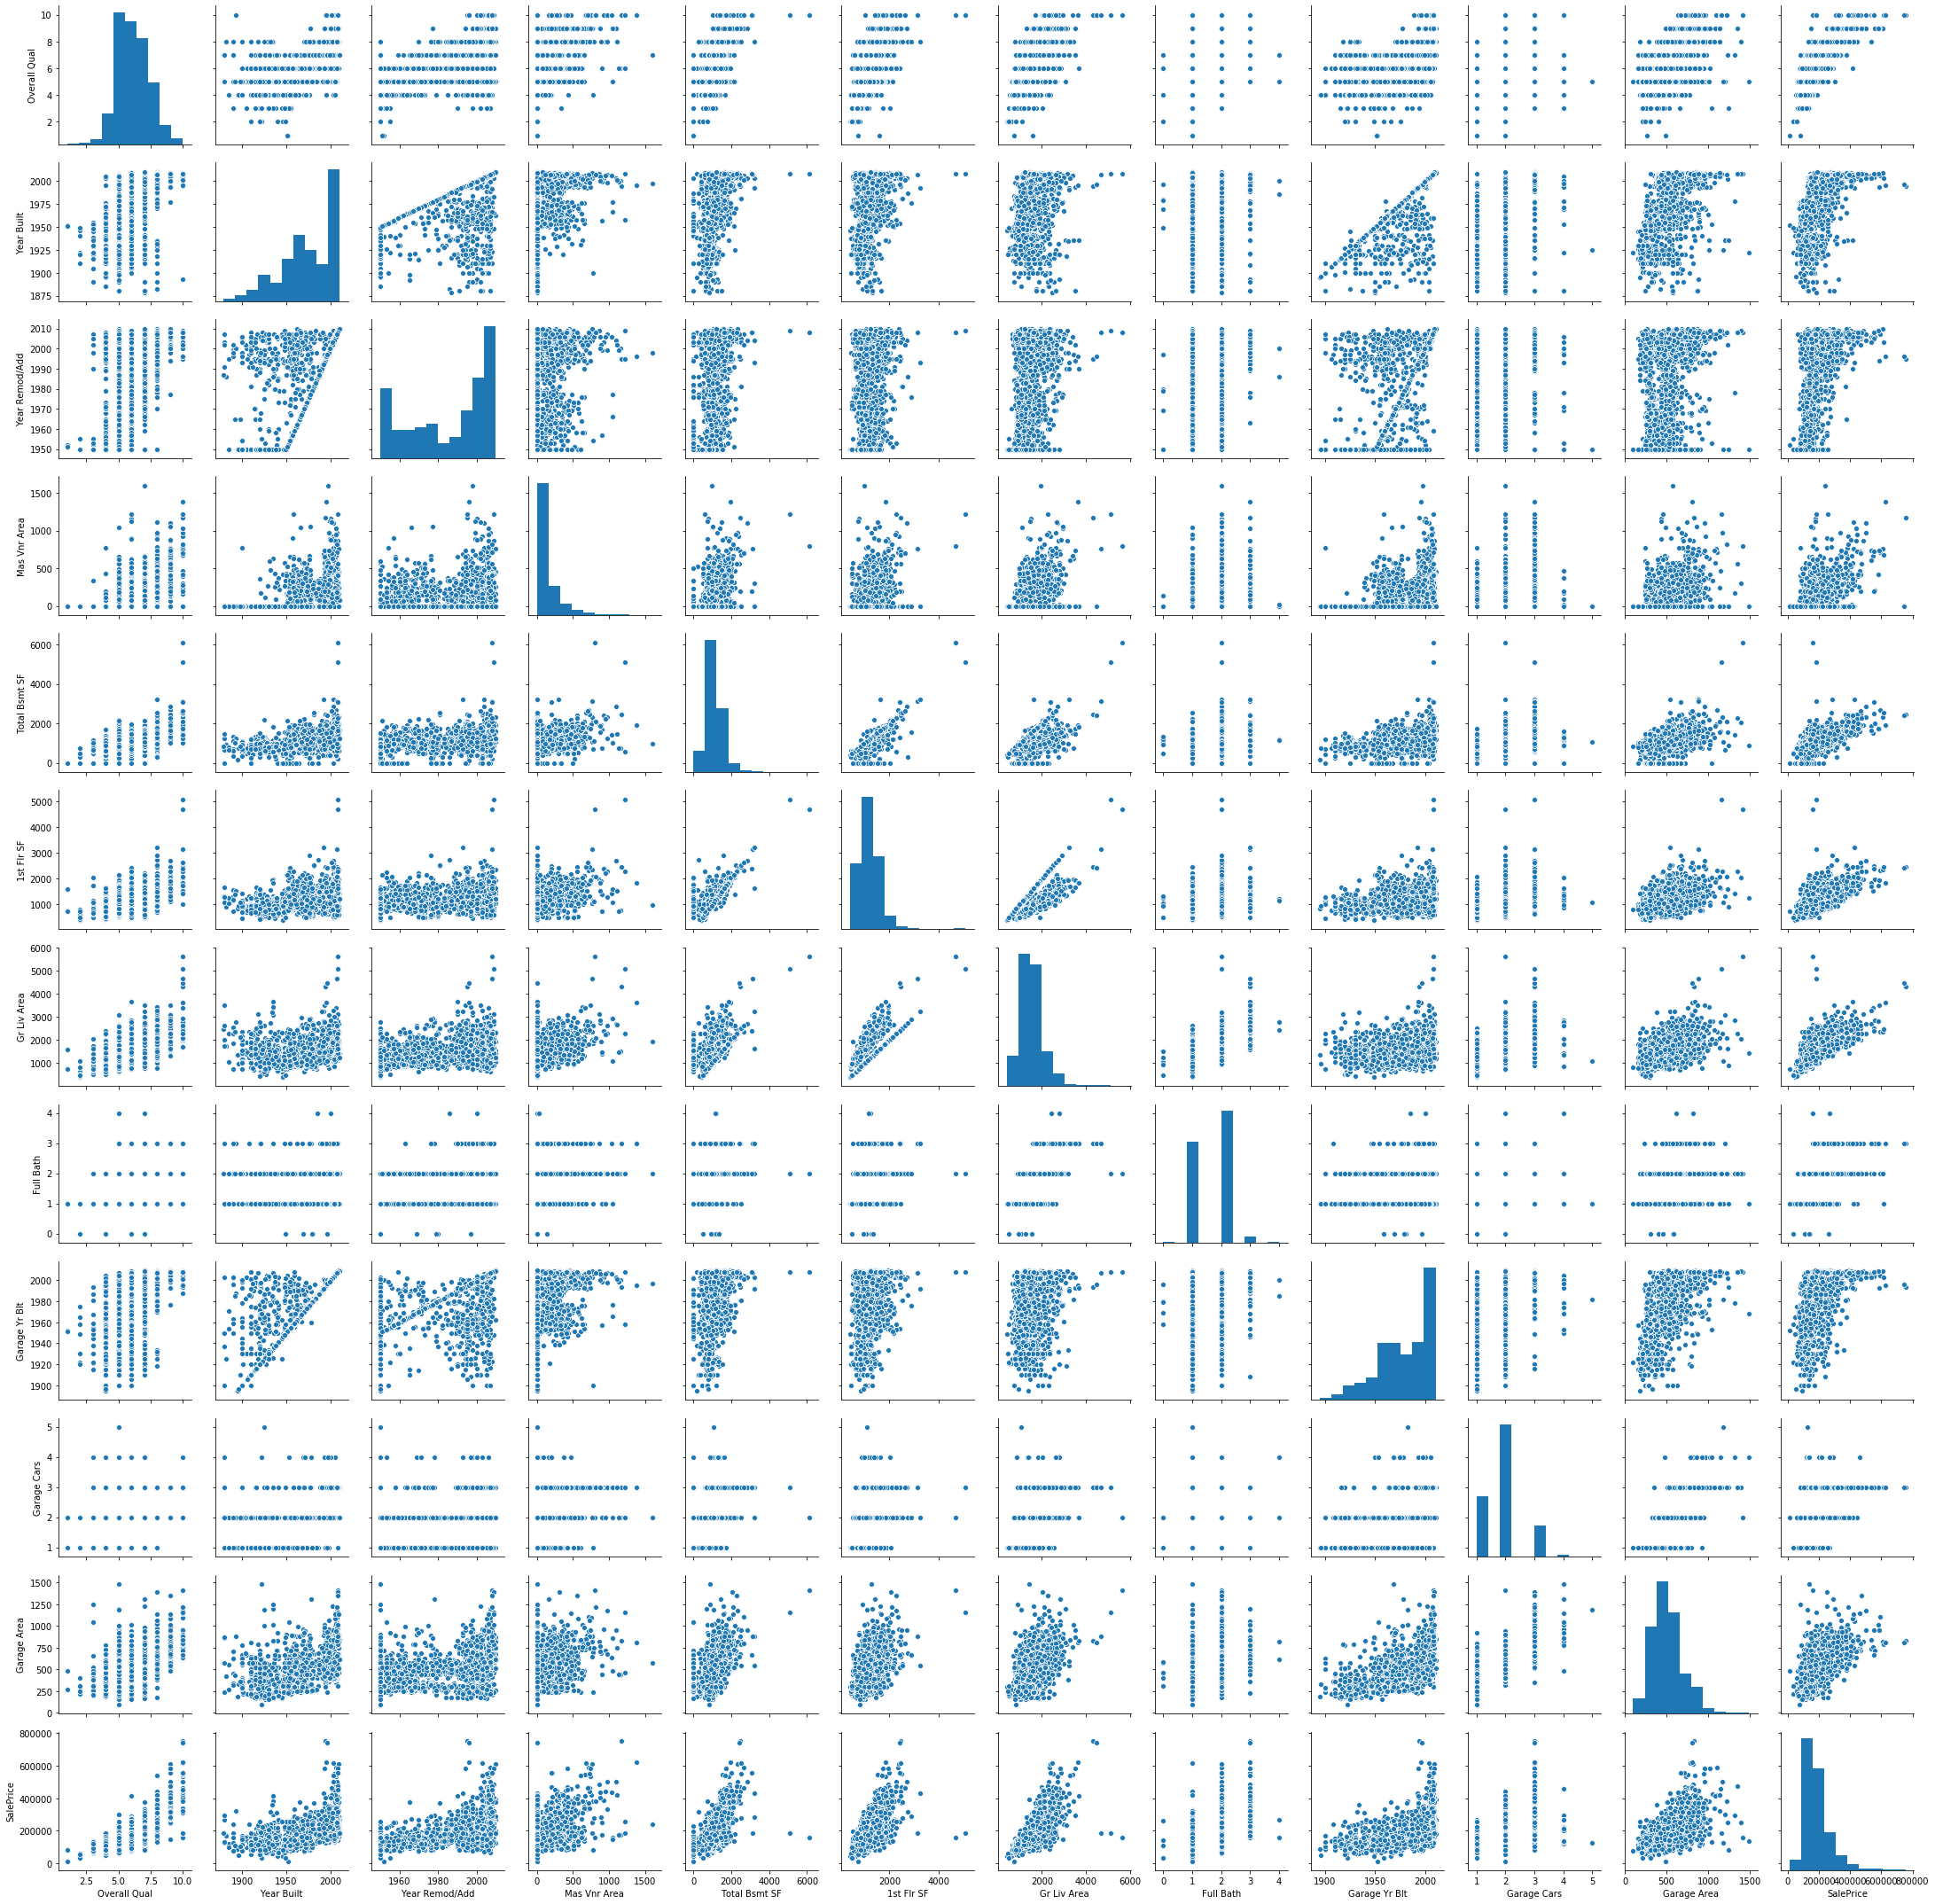

In [21]:
sns_plot = sns.pairplot(train[most_corr_cols].dropna())

In [22]:
unique_counts = pd.DataFrame.from_records([(col, train[col].dtype, train[col].nunique()) for col in nesessary],
                          columns=['Column_Name', 'Type', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Type,Num_Unique
1,Street,object,2
32,Central Air,object,2
4,Utilities,object,3
6,Land Slope,object,3
46,Paved Drive,object,3
41,Garage Finish,object,3
2,Lot Shape,object,4
3,Land Contour,object,4
26,Bsmt Exposure,object,4
21,Exter Qual,object,4


In [23]:
# 'Bsmt Qual'
for col in nesessary:
    if train[col].dtype == object:
        print(pd.crosstab(train[col], train['Bsmt Qual']))
        print()
        
# Foundation теряем 510 значений Garage Finish теряем 450 значений

Bsmt Qual   Ex  Fa   Gd  Po   TA
MS Zoning                       
C (all)      0   3    0   2   13
FV          15   0   97   0    1
I (all)      0   0    0   0    1
RH           0   1    5   0    9
RL         172  31  770   0  680
RM          11  36   58   0  225

Bsmt Qual   Ex  Fa   Gd  Po   TA
Street                          
Grvl         0   2    1   0    5
Pave       198  69  929   2  924

Bsmt Qual   Ex  Fa   Gd  Po   TA
Lot Shape                       
IR1        103   6  398   0  219
IR2          7   0   46   0    5
IR3          3   1    6   0    1
Reg         85  64  480   2  704

Bsmt Qual      Ex  Fa   Gd  Po   TA
Land Contour                       
Bnk             4   8   12   0   55
HLS            28   1   36   0   20
Low             1   2   26   0   12
Lvl           165  60  856   2  842

Bsmt Qual   Ex  Fa   Gd  Po   TA
Utilities                       
AllPub     198  71  930   2  927
NoSeWa       0   0    0   0    1
NoSewr       0   0    0   0    1

Bsmt Qual    Ex  Fa 

Bsmt Qual       Ex  Fa   Gd  Po   TA
Garage Finish                       
Fin            134   1  324   0   78
RFn             57   3  384   0  176
Unf              7  56  196   2  601

Bsmt Qual     Ex  Fa   Gd  Po   TA
Garage Qual                       
Ex             0   0    0   0    2
Fa             0  14   10   1   63
Gd             1   1    8   0    8
Po             0   2    0   1    2
TA           197  43  886   0  780

Bsmt Qual     Ex  Fa   Gd  Po   TA
Garage Cond                       
Ex             0   0    0   0    3
Fa             0   8    6   1   36
Gd             0   1    6   0    3
Po             0   5    0   0    7
TA           198  46  892   1  806

Bsmt Qual     Ex  Fa   Gd  Po   TA
Paved Drive                       
N              0  24   14   1  101
P              0   3    4   0   40
Y            198  44  912   1  788

Bsmt Qual   Ex  Fa   Gd  Po   TA
Sale Type                       
COD          0   3   15   0   44
CWD          0   0    3   0    6
Con          0

In [24]:
# 'Garage Type'
for col in nesessary:
    if train[col].dtype == object:
        print(pd.crosstab(train[col], train['Garage Finish']))
        print()
        
# 

Garage Finish  Fin  RFn  Unf
MS Zoning                   
A (agr)          0    0    2
C (all)          0    3    6
FV              35   54   24
I (all)          0    0    2
RH               3    0   11
RL             471  546  617
RM              35   26  240

Garage Finish  Fin  RFn  Unf
Street                      
Grvl             0    3    4
Pave           544  626  898

Garage Finish  Fin  RFn  Unf
Lot Shape                   
IR1            269  259  191
IR2             28   17   15
IR3              5    3    3
Reg            242  350  693

Garage Finish  Fin  RFn  Unf
Land Contour                
Bnk              7    6   62
HLS             39   19   26
Low              9   12   19
Lvl            489  592  795

Garage Finish  Fin  RFn  Unf
Utilities                   
AllPub         544  628  900
NoSeWa           0    1    0
NoSewr           0    0    2

Garage Finish  Fin  RFn  Unf
Lot Config                  
Corner         100   86  170
CulDSac         50   51   39
FR2      

Garage Finish  Fin  RFn  Unf
Garage Qual                 
Ex               1    0    1
Fa               1    1   91
Gd               4    7    7
Po               0    0    5
TA             538  621  798

Garage Finish  Fin  RFn  Unf
Garage Cond                 
Ex               2    0    1
Fa               1    0   54
Gd               3    5    3
Po               0    0   13
TA             538  624  831

Garage Finish  Fin  RFn  Unf
Paved Drive                 
N                2    6   98
P                4    5   39
Y              538  618  765

Garage Finish  Fin  RFn  Unf
Sale Type                   
COD              5   18   38
CWD              0    6    3
Con              1    0    2
ConLD            2    5   10
ConLI            0    2    3
ConLw            0    2    3
New            104   69    9
Oth              0    0    2
VWD              0    0    1
WD             432  527  831

Garage Finish   Fin  RFn  Unf
Sale Condition               
Abnorml          13   28   70
AdjLand

In [25]:
# 'Garage Finish'
for col in nesessary:
    if train[col].dtype == object:
        print(pd.crosstab(train[col], train['Garage Type'][(train['Garage Cars'] == 1) & (train['Garage Qual'] == 'TA')]))
        print()

Garage Type  2Types  Attchd  Basment  BuiltIn  CarPort  Detchd
MS Zoning                                                     
C (all)           0       0        0        0        0       4
I (all)           0       0        0        0        0       2
RH                0       2        1        0        1       2
RL                1     217        7        4        2     107
RM                0      23        1        5        2      96

Garage Type  2Types  Attchd  Basment  BuiltIn  CarPort  Detchd
Street                                                        
Grvl              0       0        0        0        0       2
Pave              1     242        9        9        5     209

Garage Type  2Types  Attchd  Basment  BuiltIn  CarPort  Detchd
Lot Shape                                                     
IR1               0      59        2        1        1      33
IR2               0       1        0        0        0       2
Reg               1     182        7        8        

Garage Type   2Types  Attchd  Basment  BuiltIn  CarPort  Detchd
Mas Vnr Type                                                   
BrkCmn             0       5        0        0        1       3
BrkFace            0      66        5        2        1      25
CBlock             0       1        0        0        0       0
None               1     162        3        7        3     181
Stone              0       8        1        0        0       2

Garage Type  2Types  Attchd  Basment  BuiltIn  CarPort  Detchd
Exter Qual                                                    
Ex                0       1        0        0        0       0
Fa                0       1        0        0        1       5
Gd                0      12        0        0        1      16
TA                1     228        9        9        3     190

Garage Type  2Types  Attchd  Basment  BuiltIn  CarPort  Detchd
Exter Cond                                                    
Ex                0       1        0        0 

Garage Type     2Types  Attchd  Basment  BuiltIn  CarPort  Detchd
Sale Condition                                                   
Abnorml              0      12        4        0        2      18
AdjLand              0       0        0        0        0       3
Alloca               0       0        0        0        0       1
Family               0       6        0        0        0       4
Normal               1     222        5        9        3     183
Partial              0       2        0        0        0       2



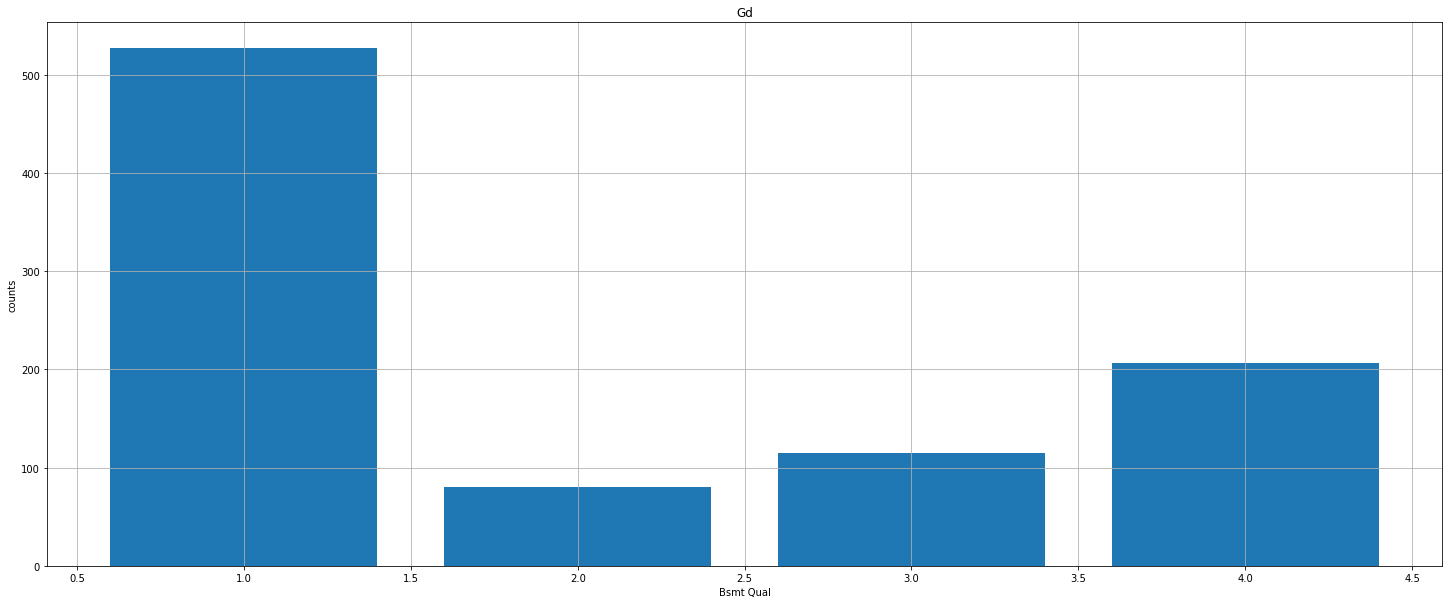

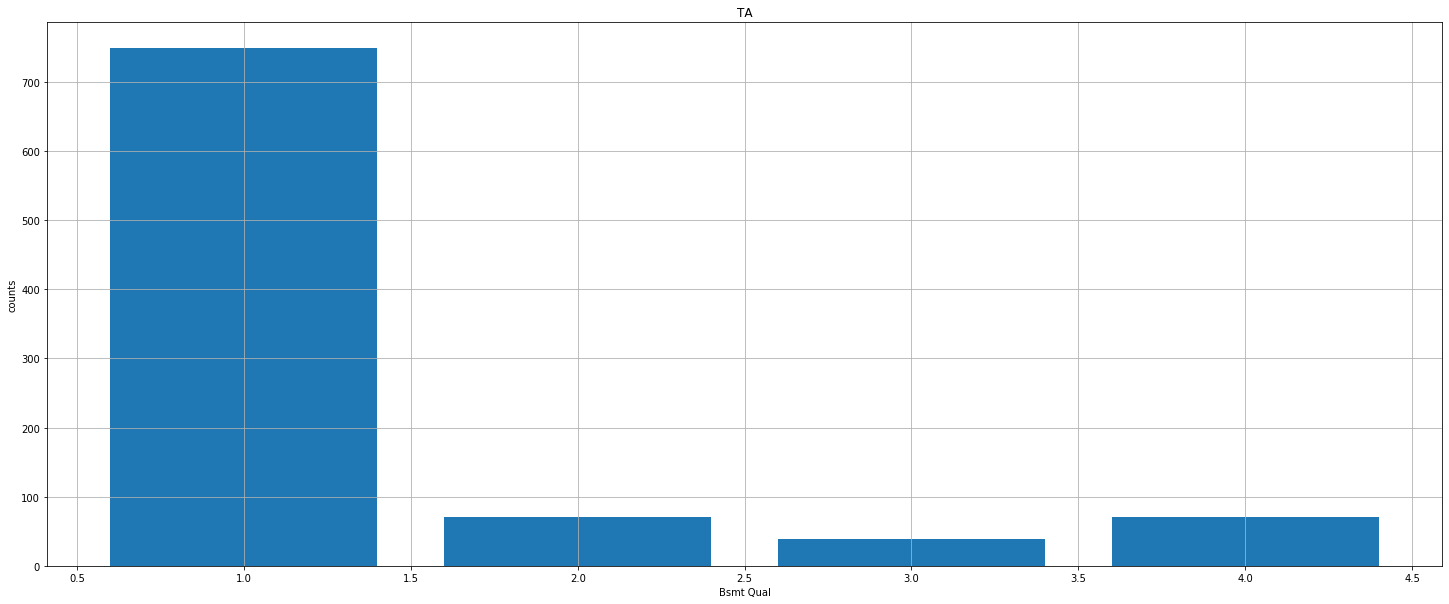

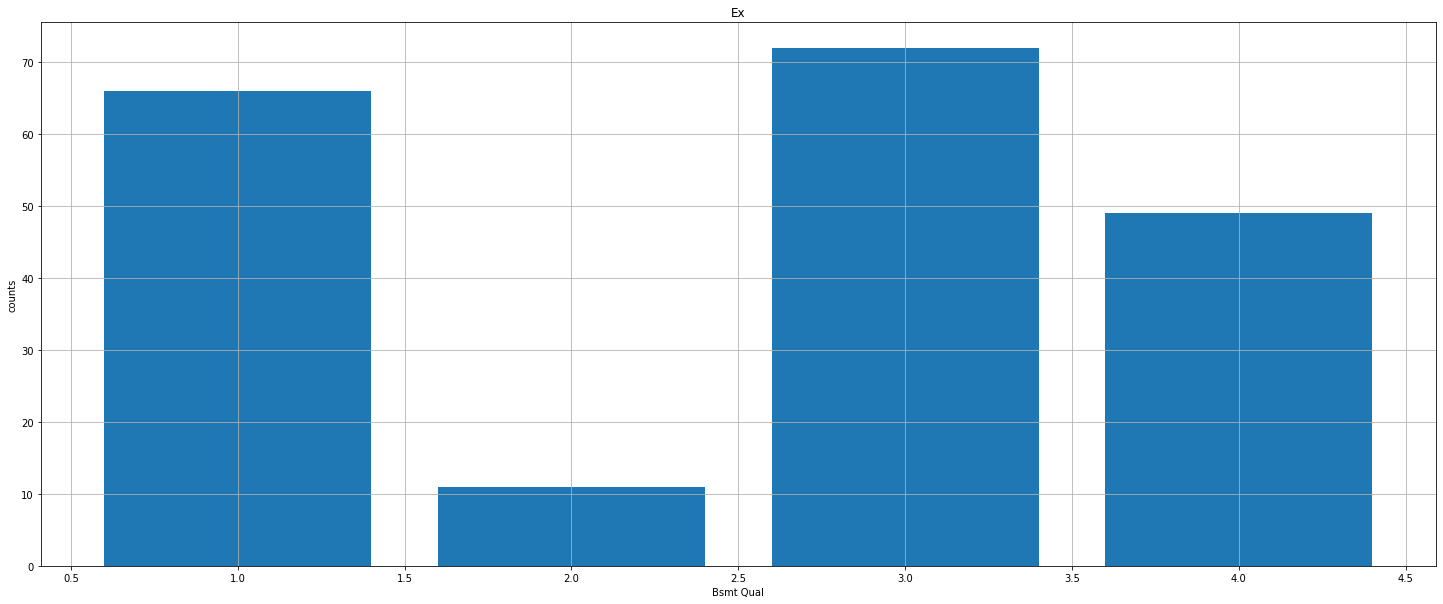

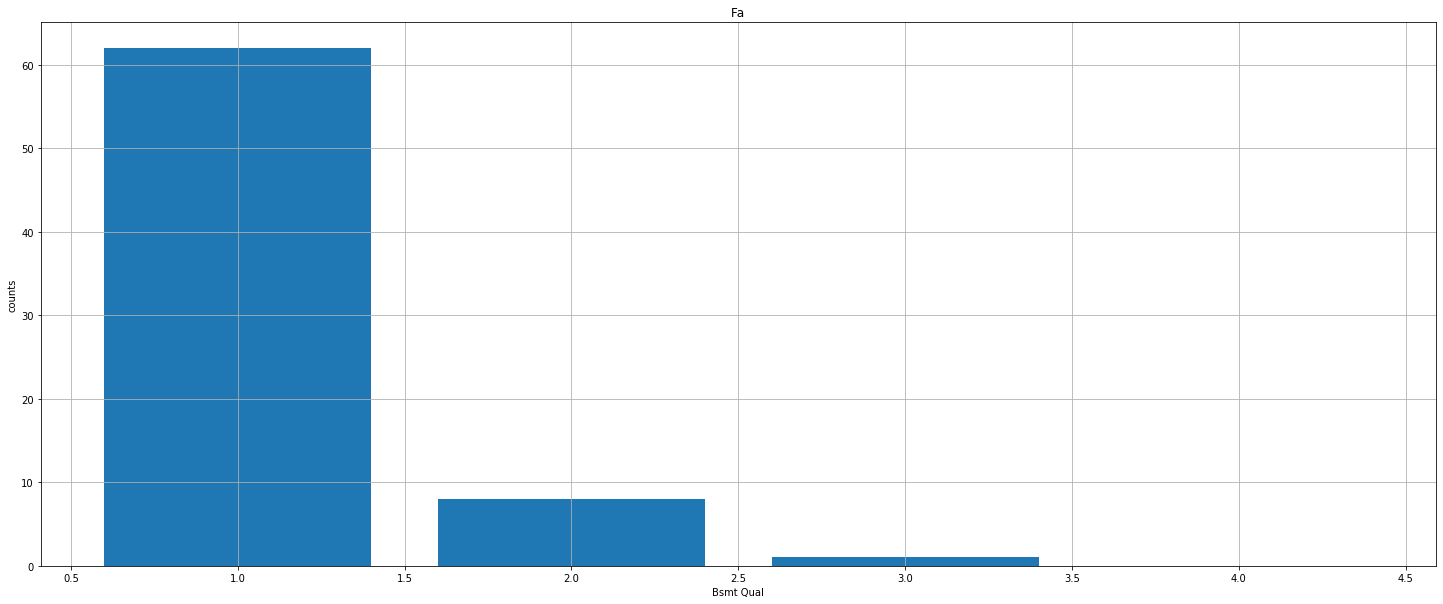

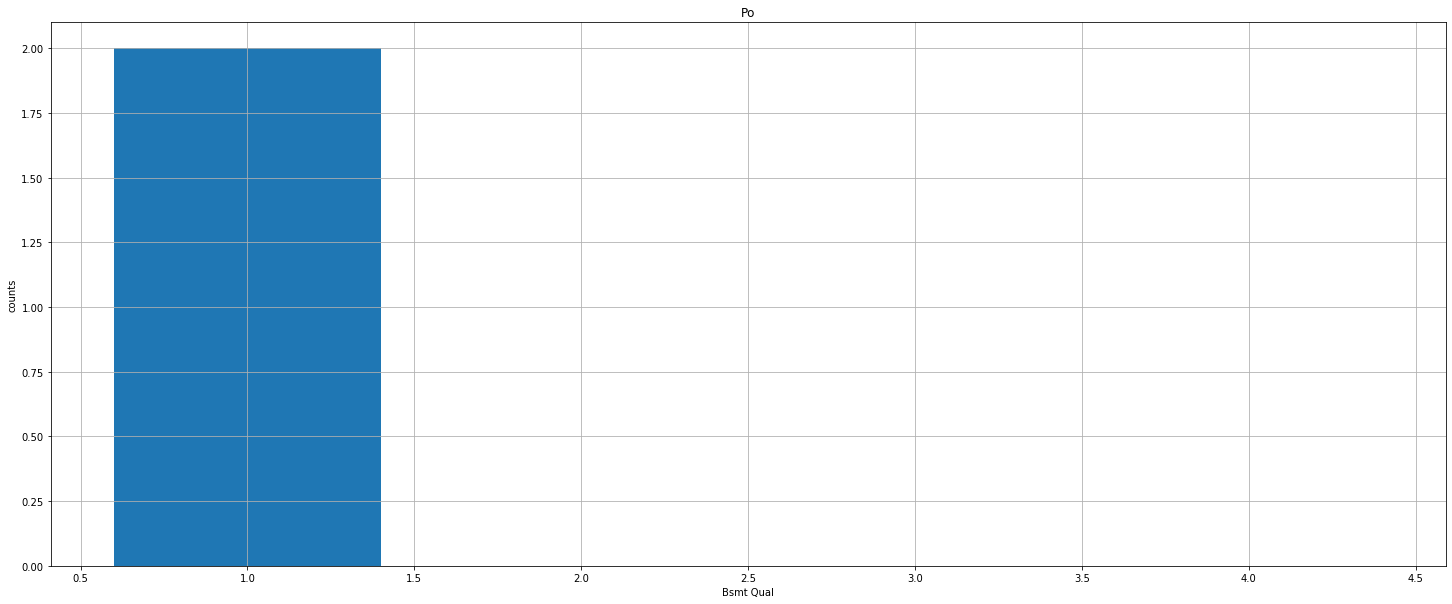

In [26]:
cols = [1, 2, 3, 4]
cols_1 = ['Gd', 'TA', 'Ex', 'Fa', 'Po'] #'Bsmt Qual'
#cols_2 = ['TA', 'Fa', 'Gd', 'Po', 'Ex'] #'Bsmt Cond' 
cols_2 = ['No', 'Mn', 'Gd', 'Av'] #'Bsmt Exposure' 
    

for col_1 in cols_1:  
    cls = []
    for col_2 in cols_2:        
        cls.append(train[(train['Bsmt Exposure'  ] == col_2) & (train['Bsmt Qual'] == col_1)][['Bsmt Qual']]['Bsmt Qual'].count())

    fig = plt.figure(figsize= (25,10))
    ax1 = fig.add_subplot()
    ax1.set_xlabel('Bsmt Qual')
    ax1.set_ylabel('counts')
    ax1.set_title('{0}'.format(col_1))
    ax1.grid()
    ax1.bar(cols, cls) 

In [27]:
pd.crosstab(train['Garage Type'], train['Garage Qual'], normalize = True)

Garage Qual,Ex,Fa,Gd,Po,TA
Garage Type,,,,,
2Types,0.000000,0.000482,0.000000,0.00000,0.007711
Attchd,0.000000,0.006265,0.005783,0.00000,0.623133
Basment,0.000000,0.001928,0.000000,0.00000,0.011566
BuiltIn,0.000000,0.000964,0.000482,0.00000,0.064578
CarPort,0.000000,0.000482,0.000000,0.00000,0.003855
Detchd,0.000964,0.034699,0.002410,0.00241,0.232289


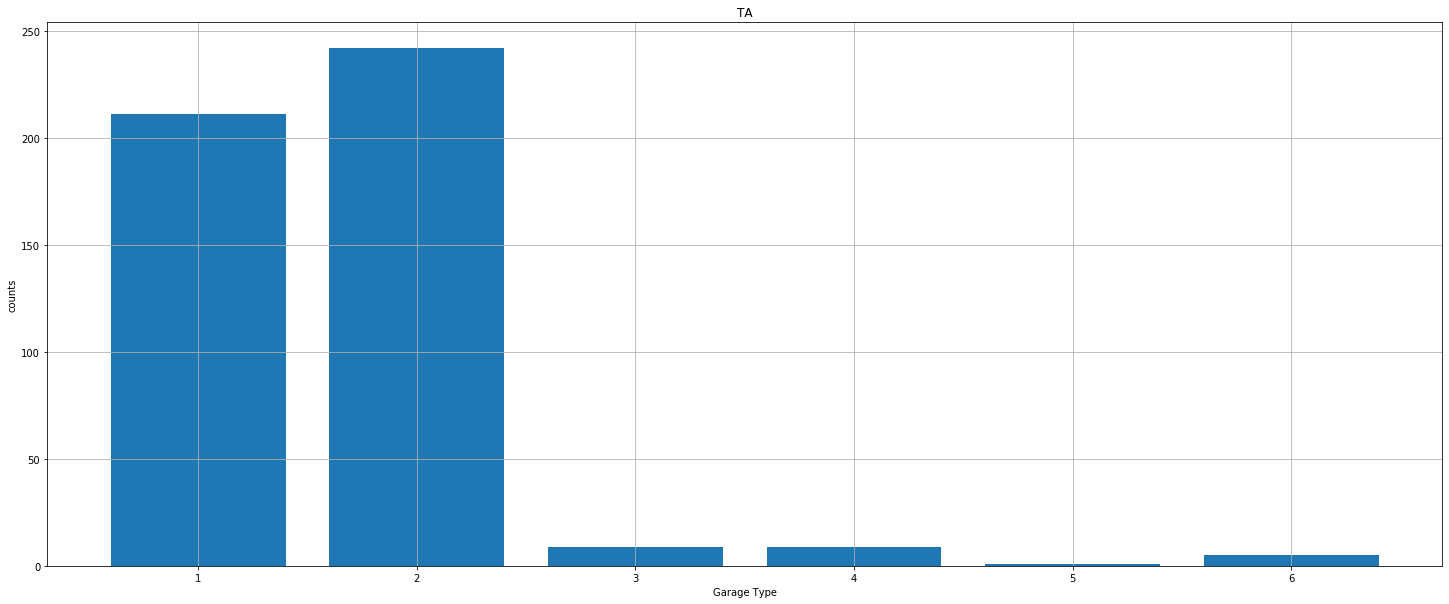

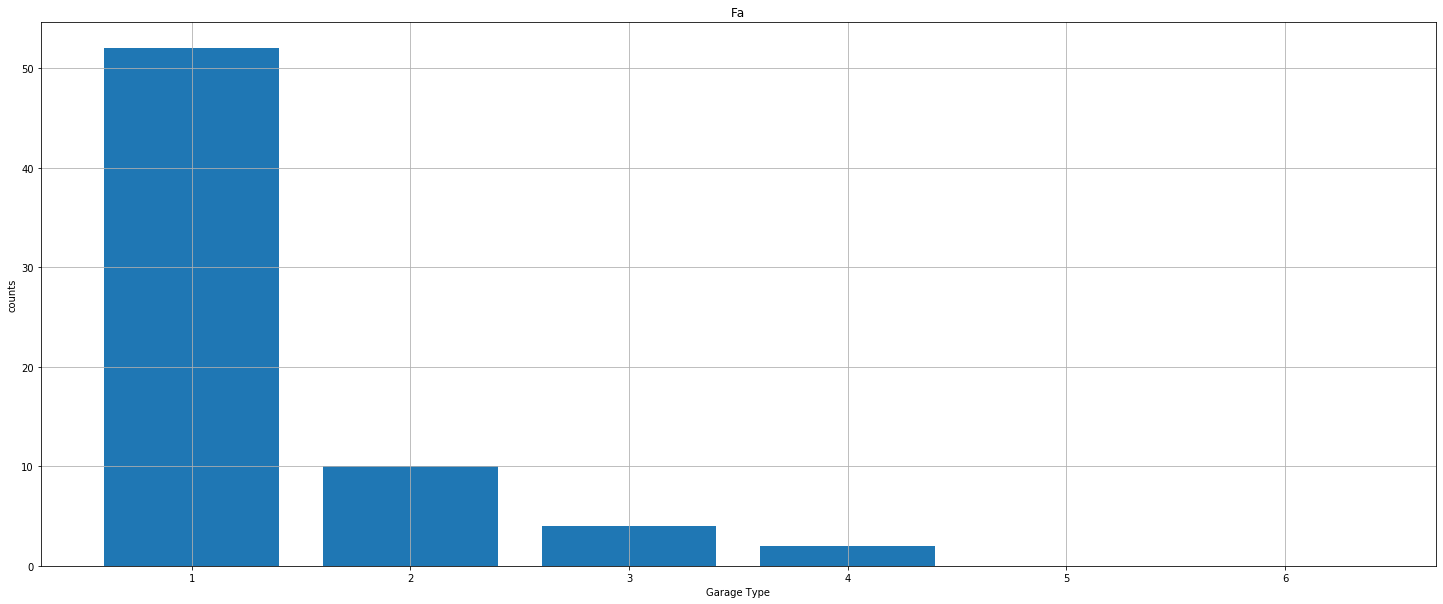

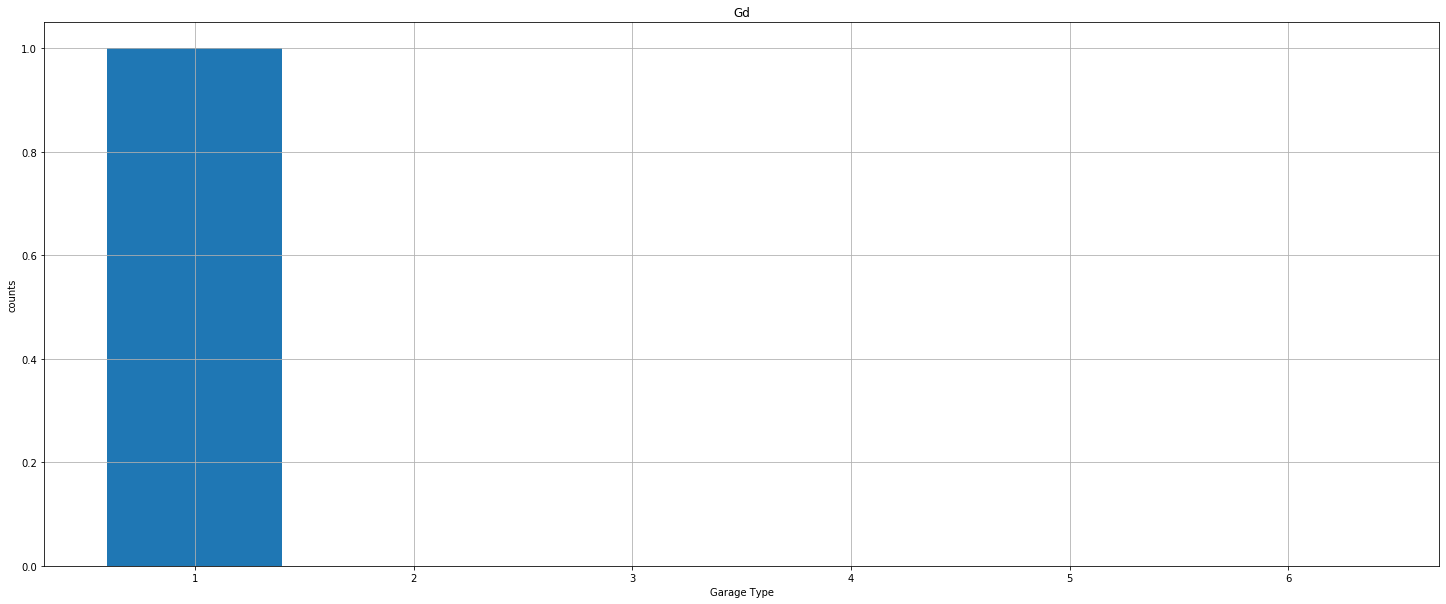

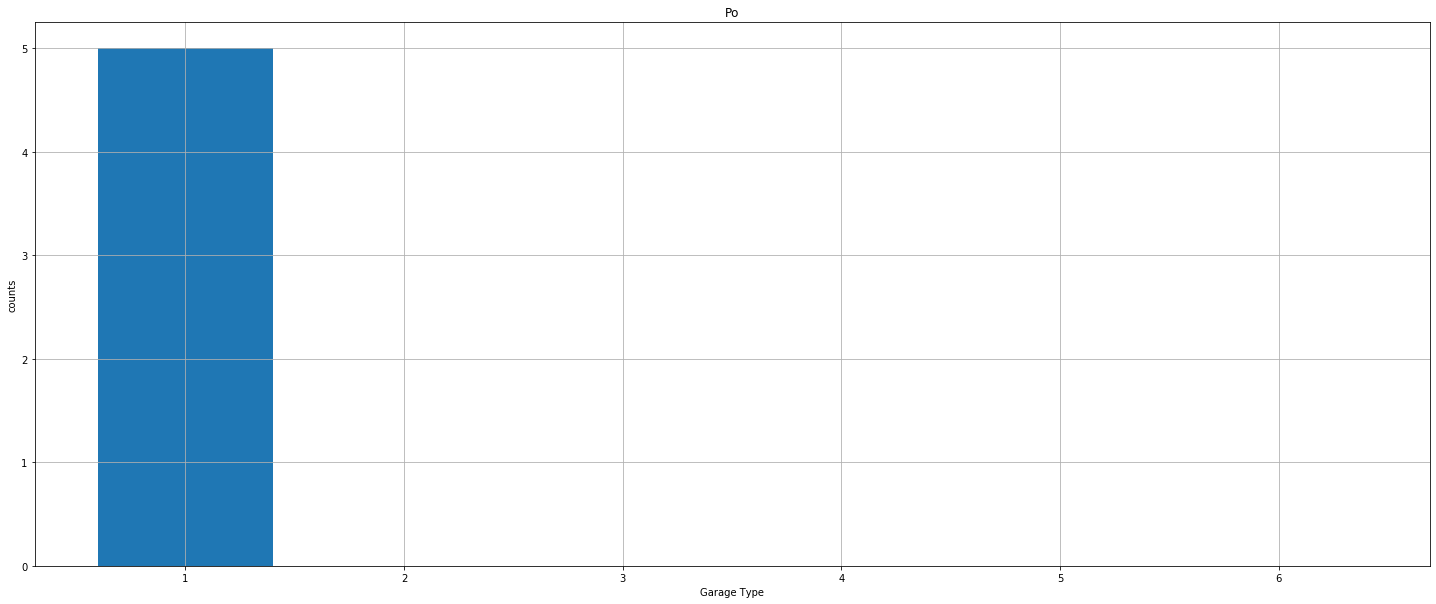

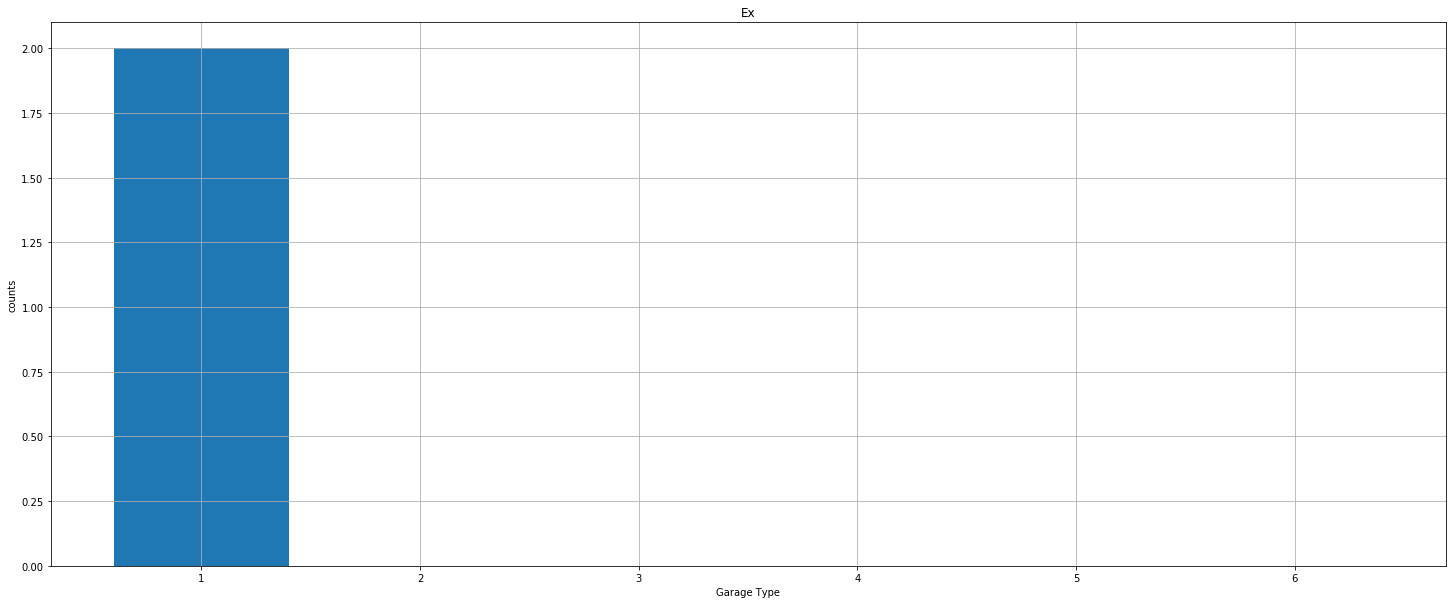

In [28]:
cols = [1, 2, 3, 4, 5, 6]
cols_1 = ['Detchd', 'Attchd', 'Basment', 'BuiltIn', '2Types', 'CarPort']
cols_2 = ['TA', 'Fa', 'Gd', 'Po', 'Ex']
    

for col_2 in cols_2:  
    cls = []
    for col_1 in cols_1:        
        cls.append(train[(train['Garage Type'] == col_1) & (train['Garage Qual'] == col_2) & (train['Garage Cars'] == 1)][['Garage Type']]['Garage Type'].count())

    fig = plt.figure(figsize= (25,10))
    ax1 = fig.add_subplot()
    ax1.set_xlabel('Garage Type')
    ax1.set_ylabel('counts')
    ax1.set_title('{0}'.format(col_2))
    ax1.grid()
    ax1.bar(cols, cls) 

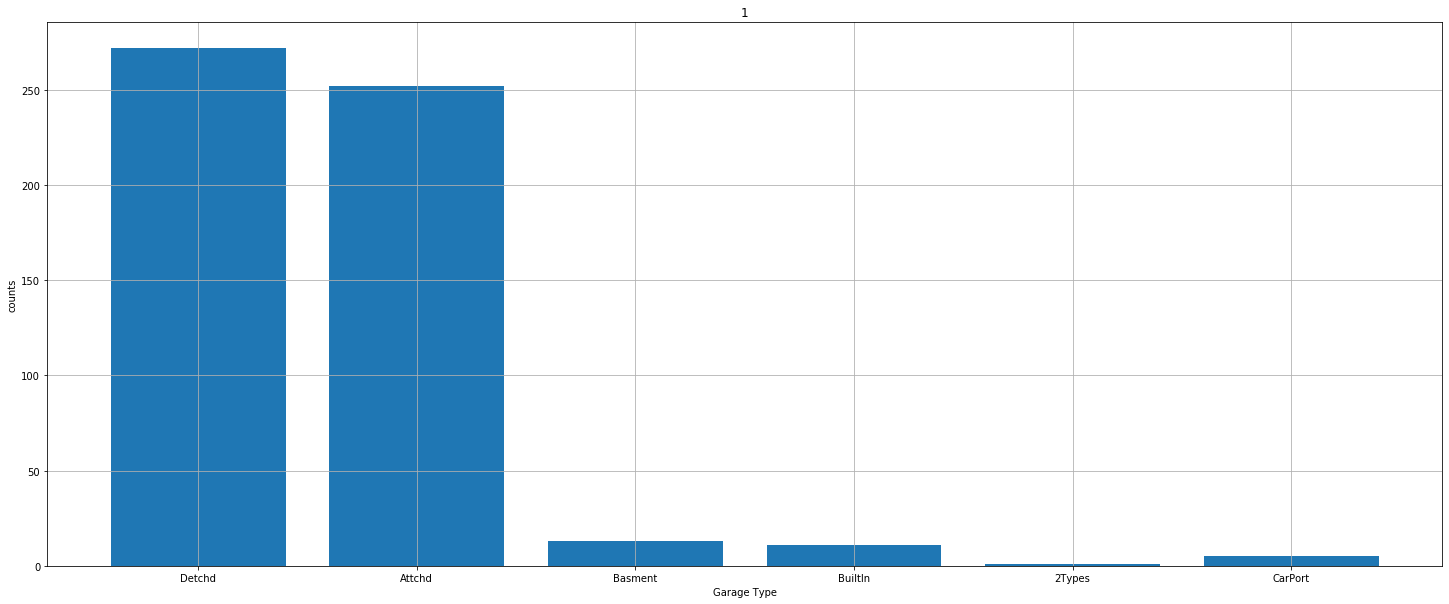

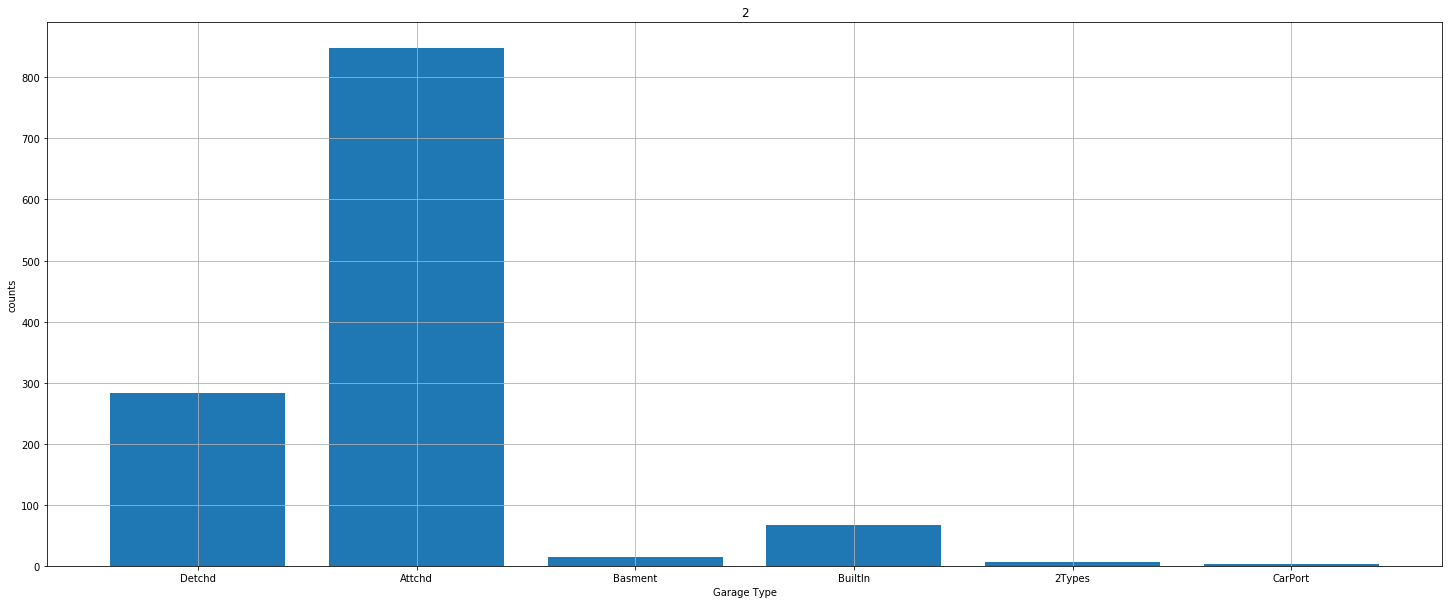

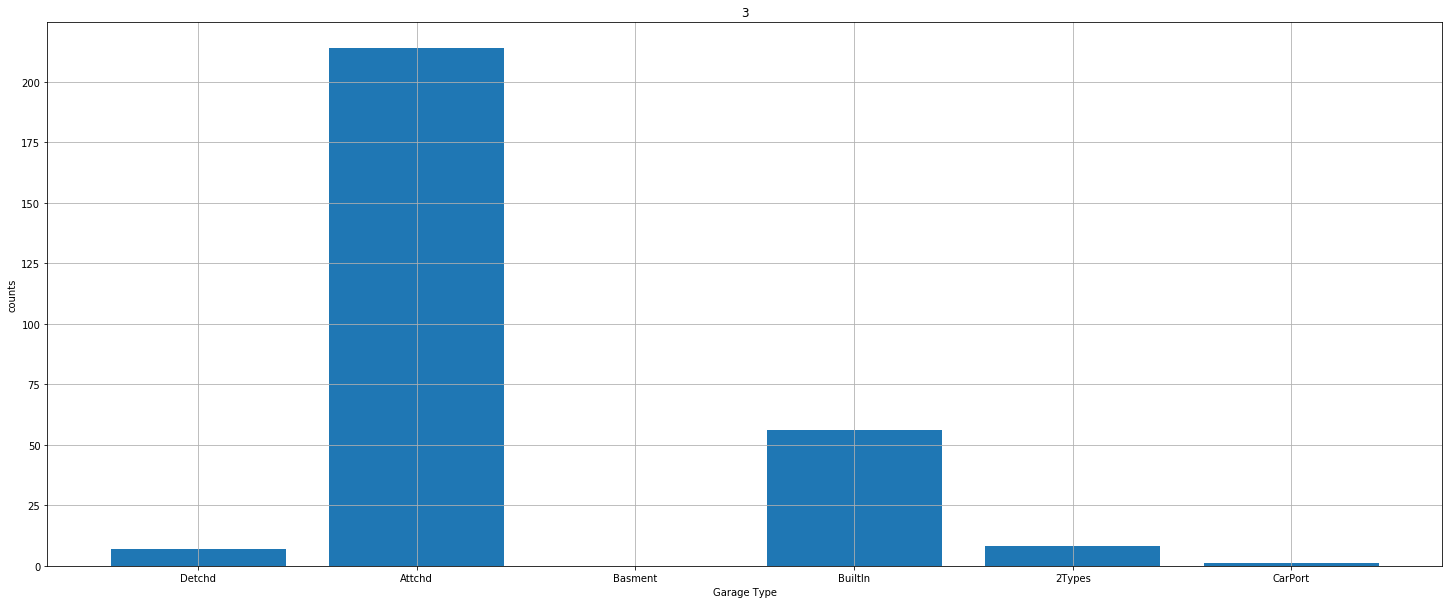

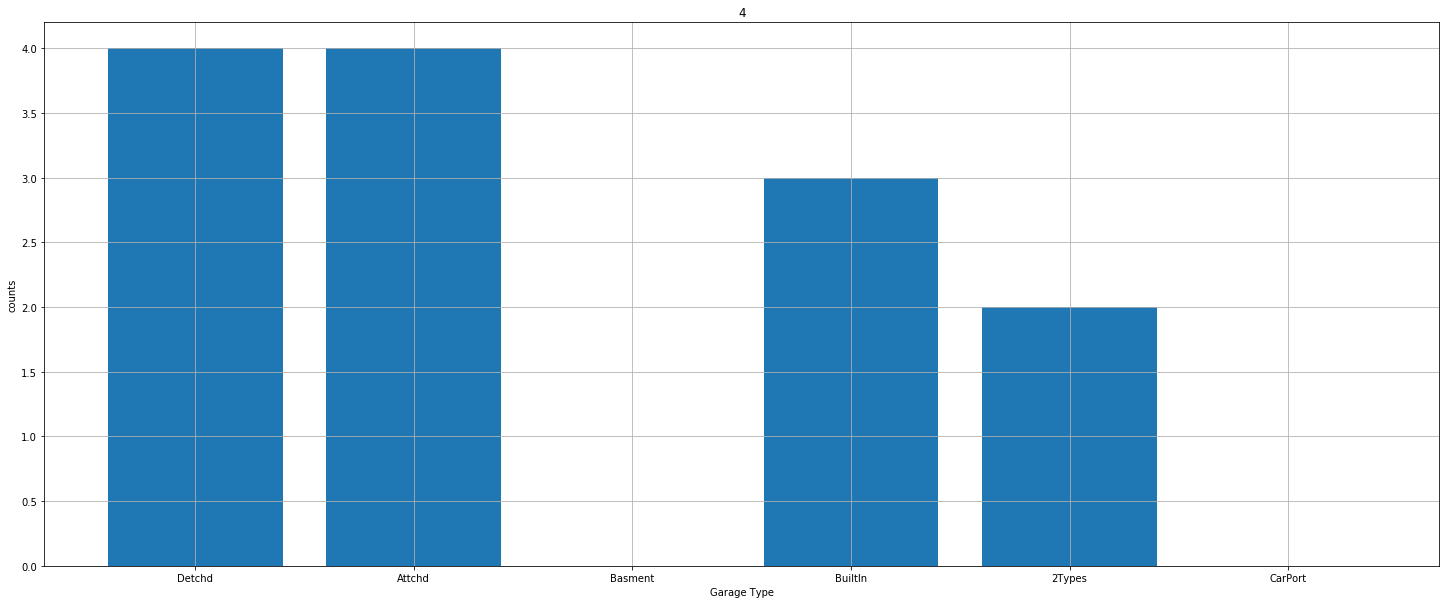

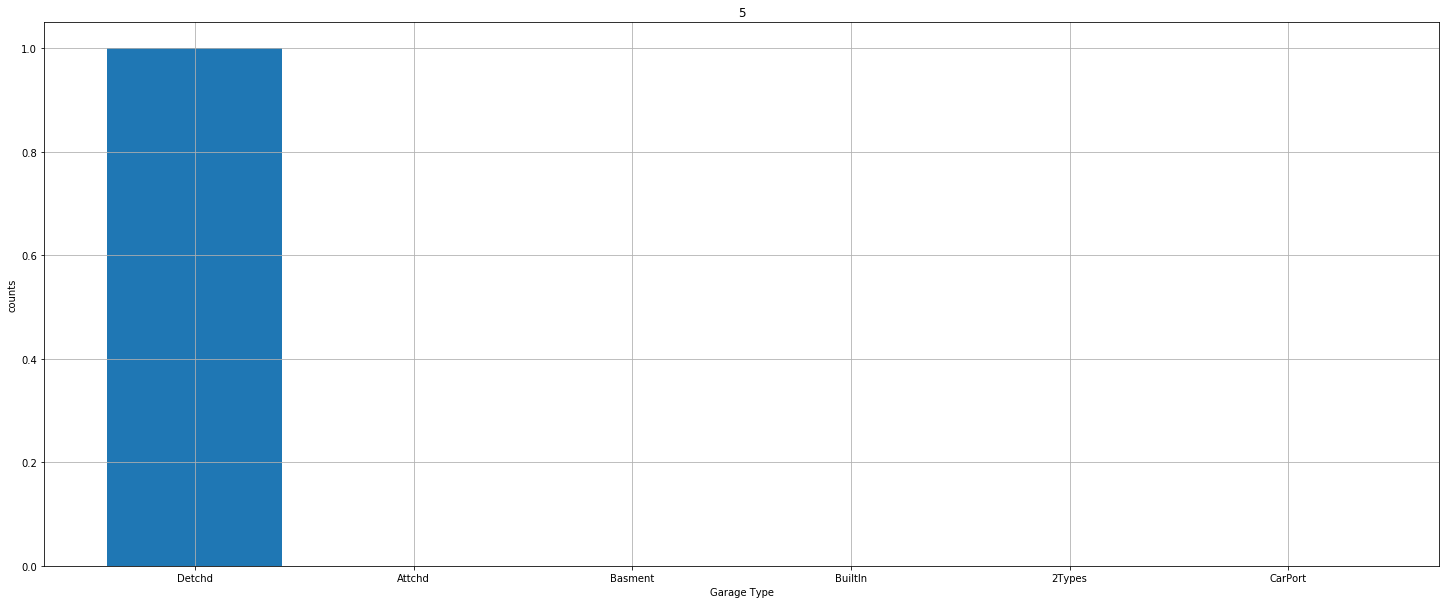

In [29]:
# 'Garage Type' ОТ 'Garage Cars'
for i in range(1, 6):
    cols = ['Detchd', 'Attchd', 'Basment', 'BuiltIn', '2Types', 'CarPort']

    cls = []

    for col in cols:
        cls.append(train[(train['Garage Type'] == col) & (train['Garage Cars'] == i)][['Garage Type']]['Garage Type'].count())

    fig = plt.figure(figsize= (25,10))
    ax1 = fig.add_subplot()
    ax1.set_xlabel('Garage Type')
    ax1.set_ylabel('counts')
    ax1.set_title('{0}'.format(i))
    ax1.grid()
    ax1.bar(cols, cls) 

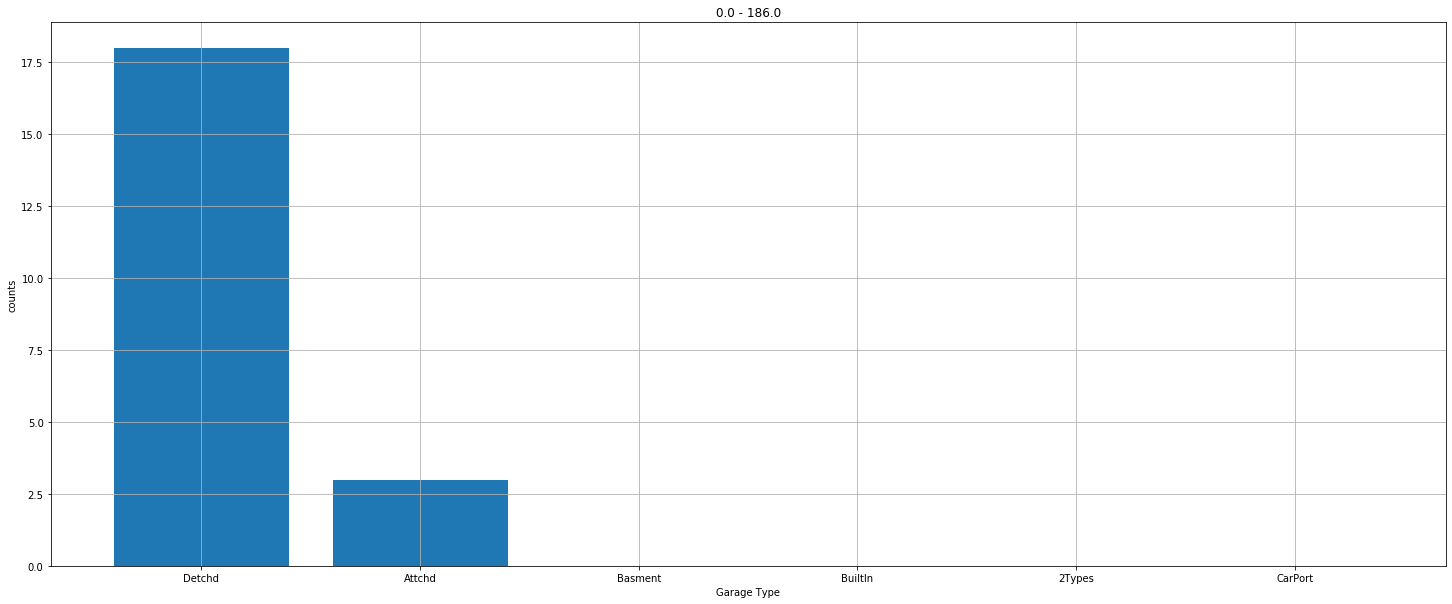

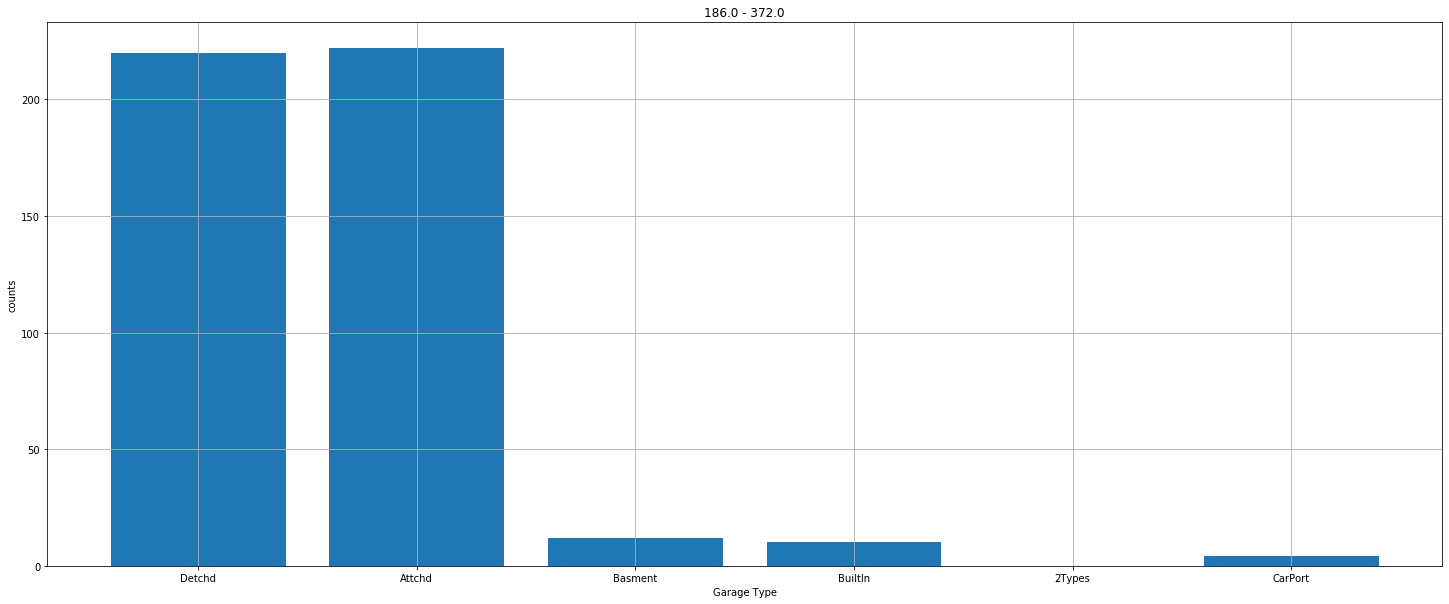

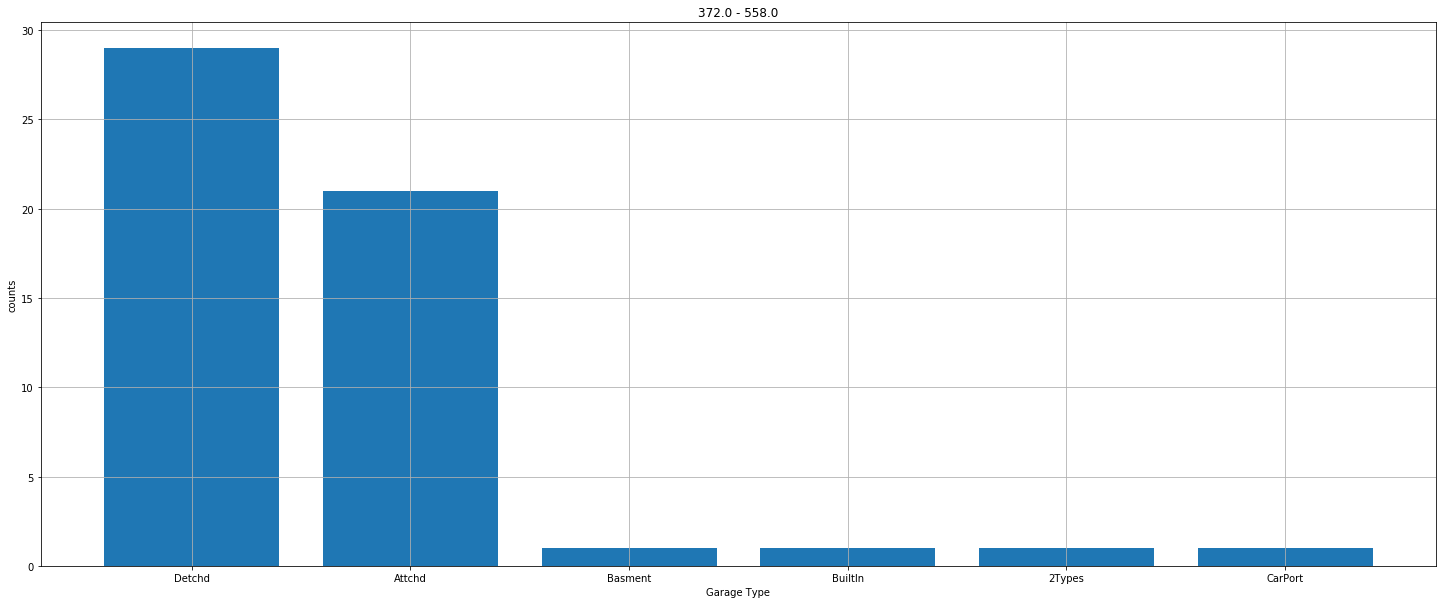

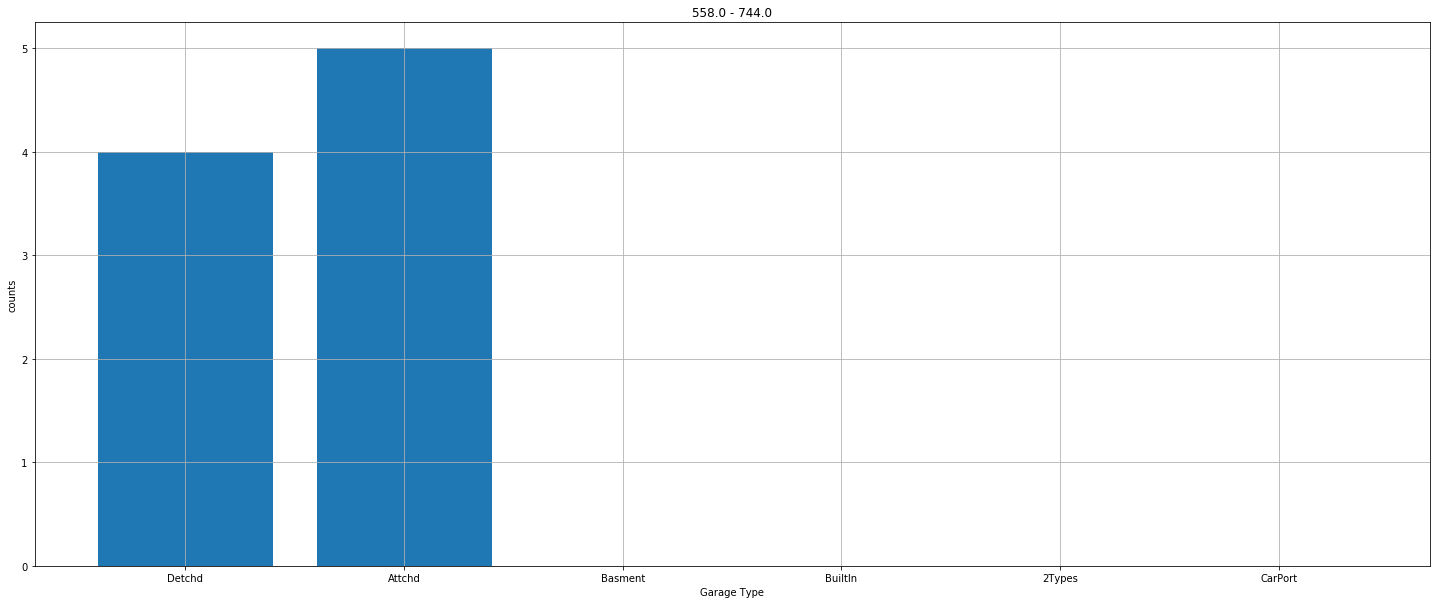

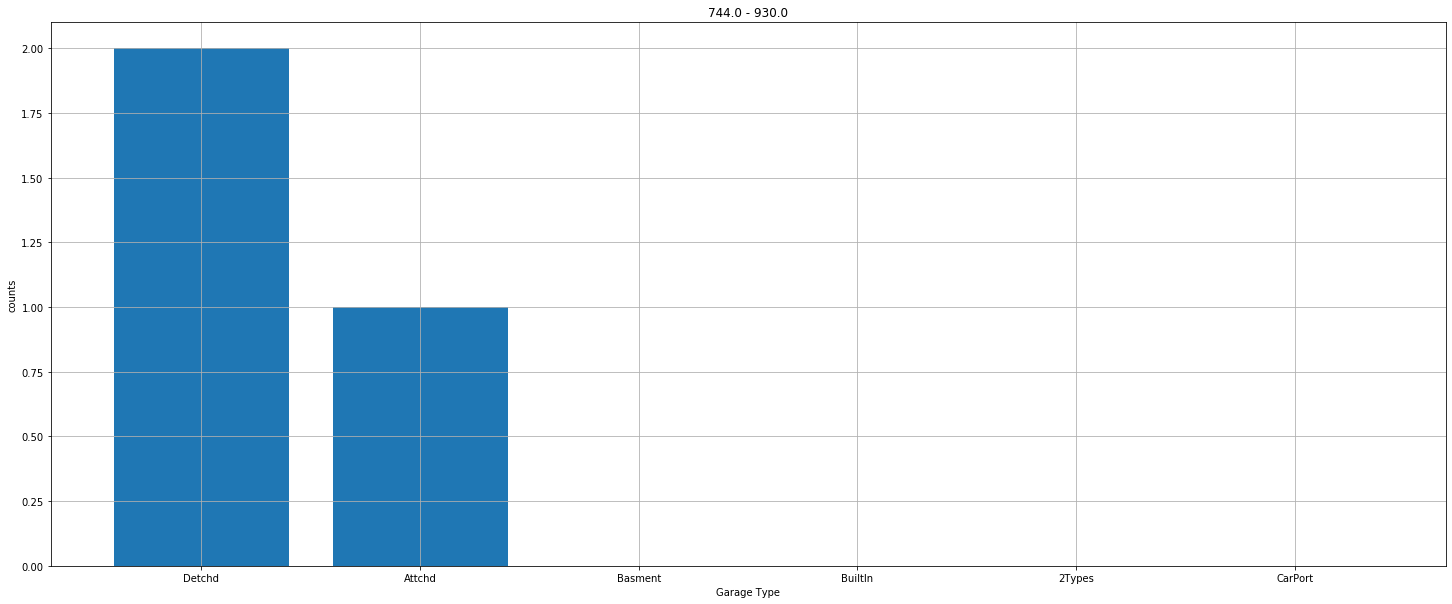

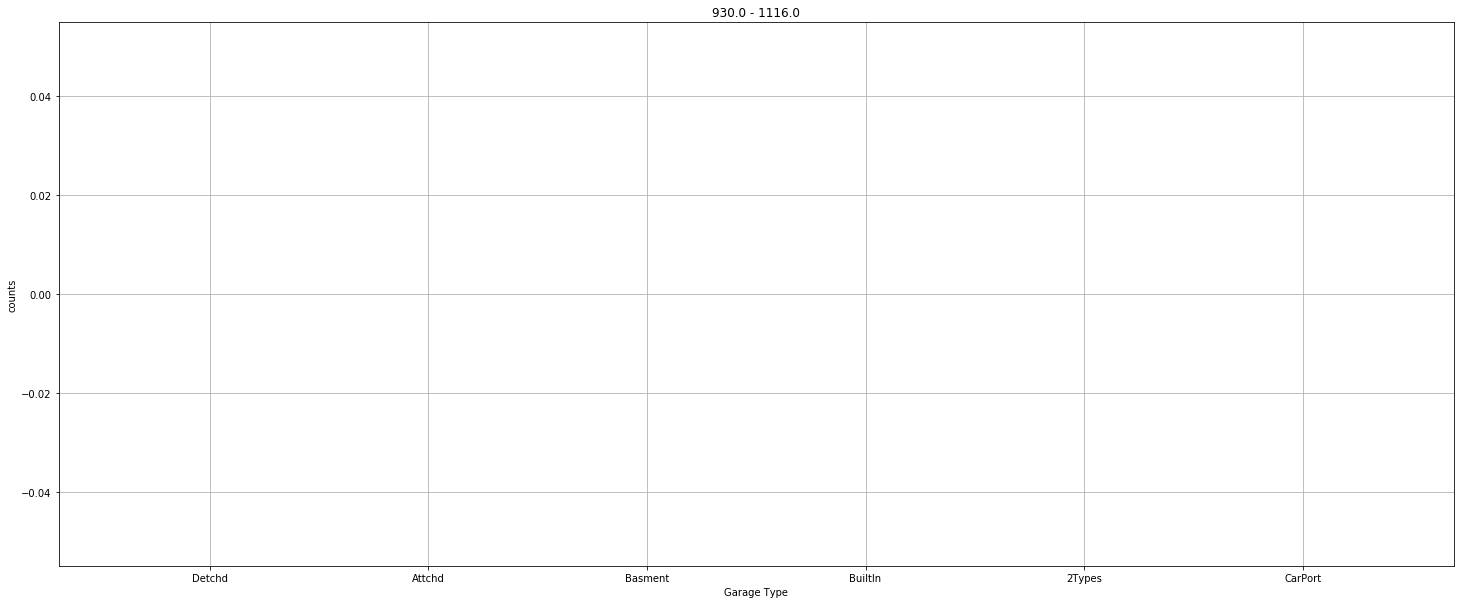

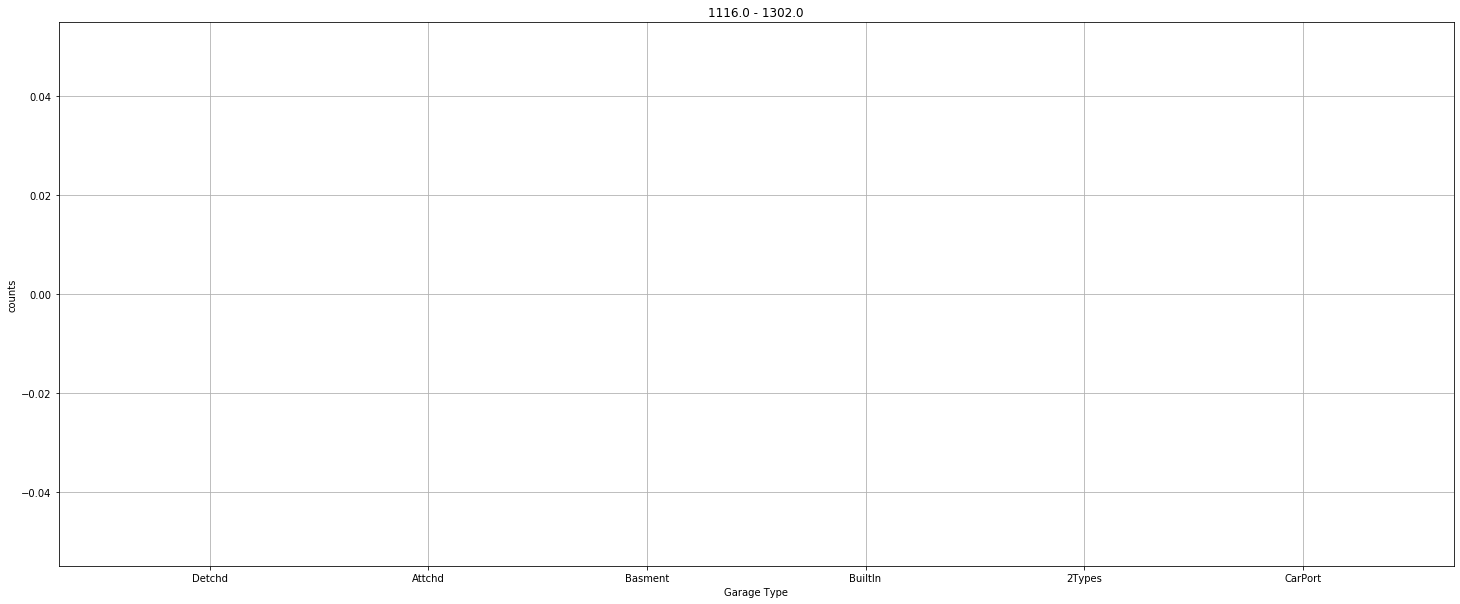

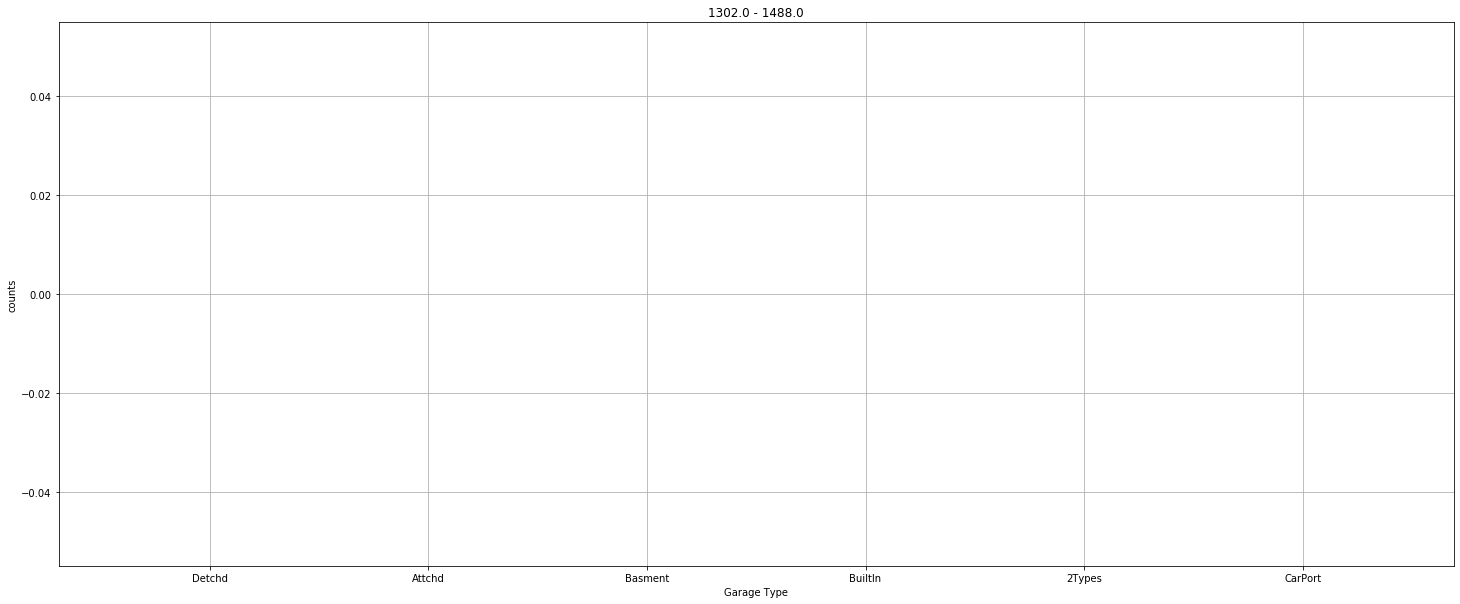

In [30]:
# 'Garage Type' ОТ 'Garage Area'
period = (train['Garage Area'].max() - train['Garage Area'].min()) / 8
start = train['Garage Area'].min()
fin = start + period + 1
for i in range(8):
    cols = ['Detchd', 'Attchd', 'Basment', 'BuiltIn', '2Types', 'CarPort']

    cls = []

    for col in cols:
        cls.append(train[(train['Garage Type'] == col) & (train['Garage Area'] >= start) & (train['Garage Area'] < fin) & (train['Garage Cars'] == 1)][['Garage Type']]['Garage Type'].count())

    fig = plt.figure(figsize= (25,10))
    ax1 = fig.add_subplot()
    ax1.set_xlabel('Garage Type')
    ax1.set_ylabel('counts')
    ax1.set_title('{0} - {1}'.format(start, fin - 1))
    ax1.grid()
    ax1.bar(cols, cls) 
    start = fin - 1
    fin = start + period + 1

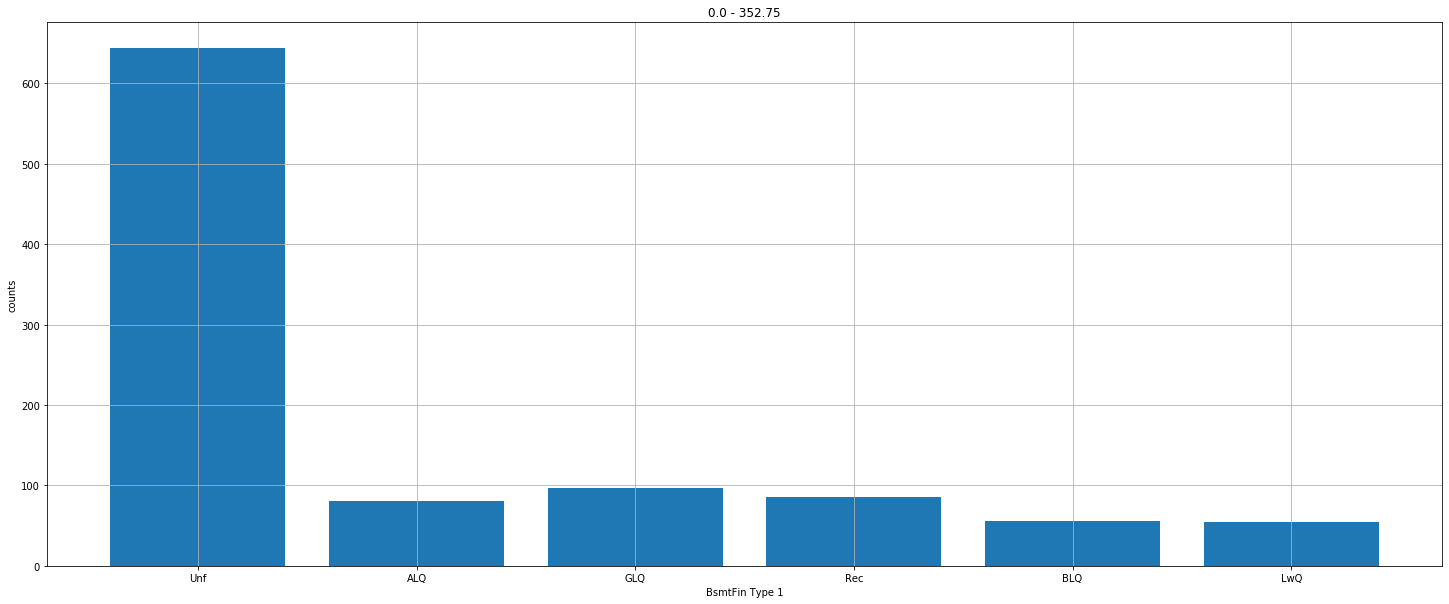

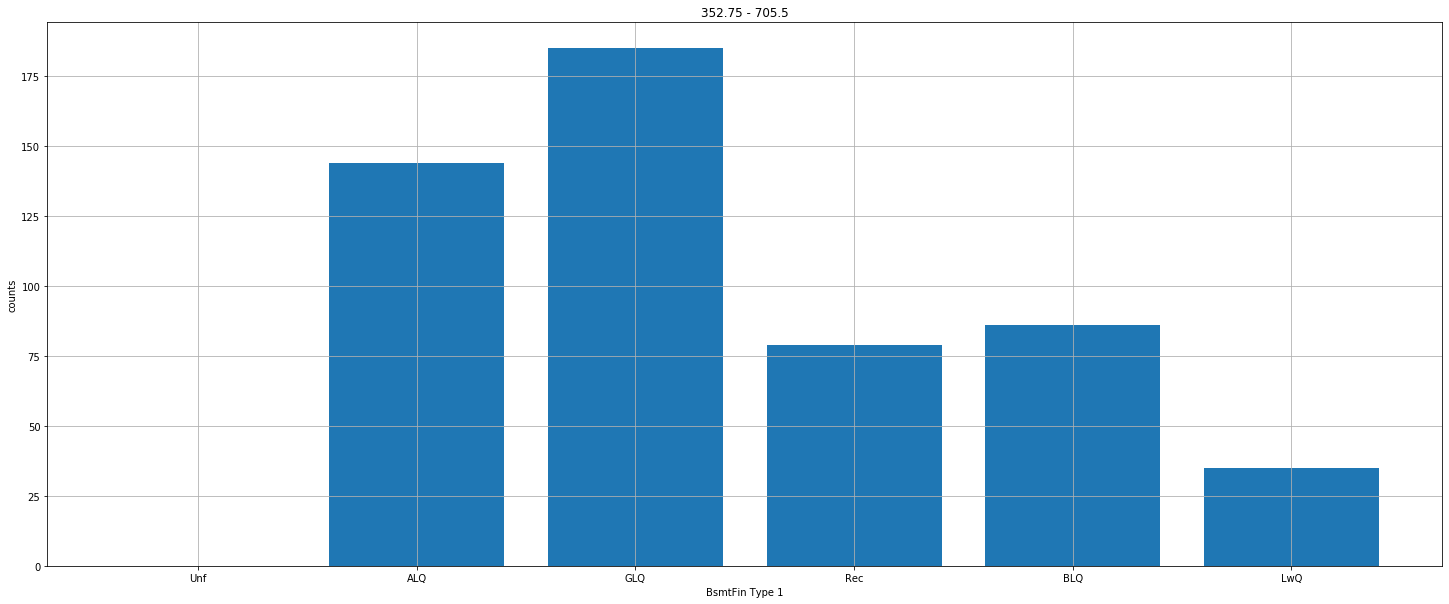

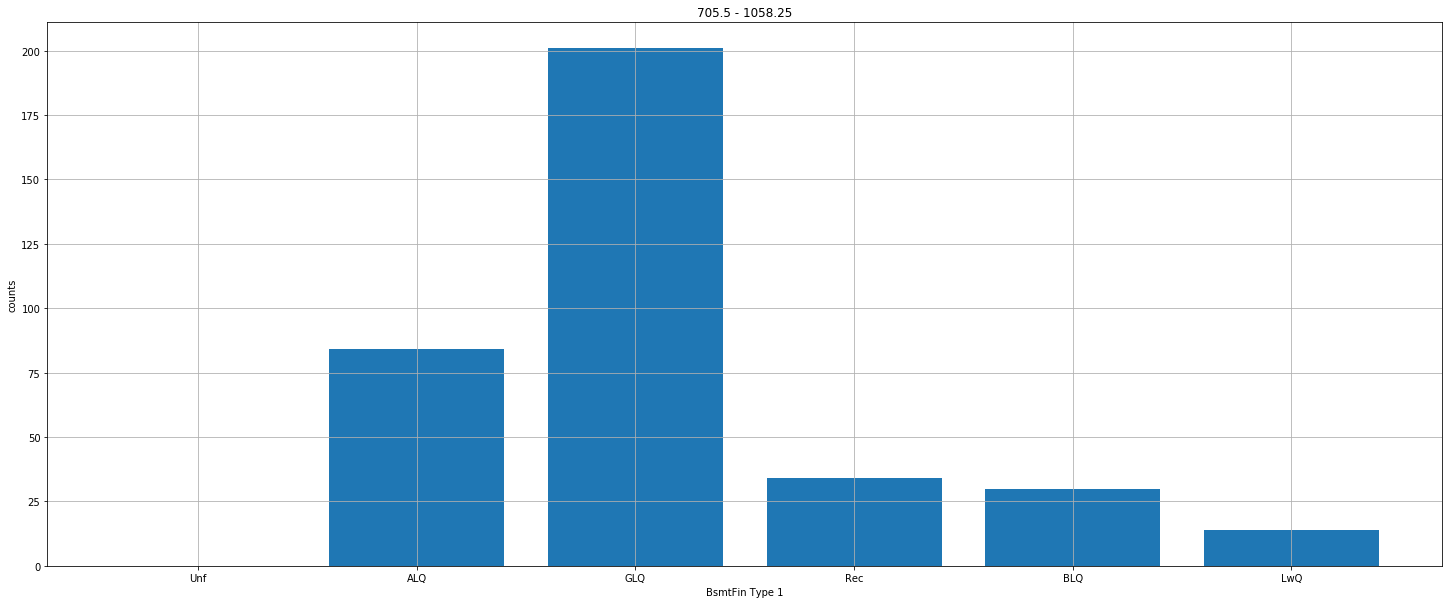

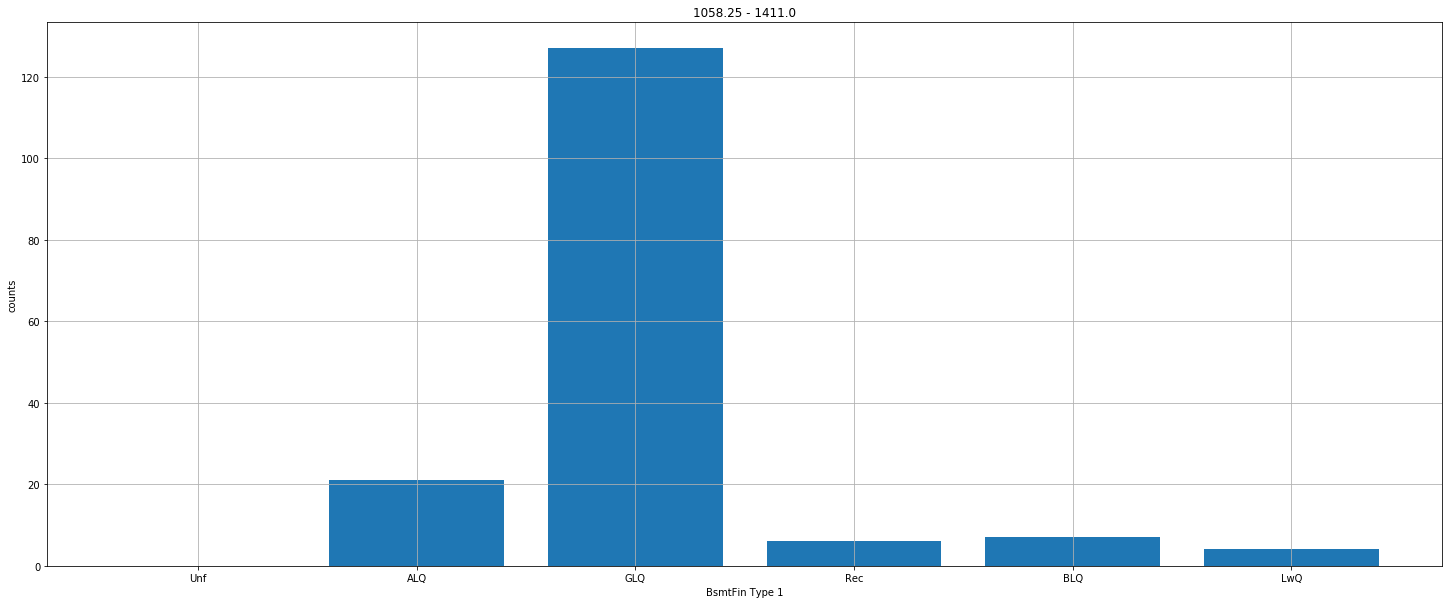

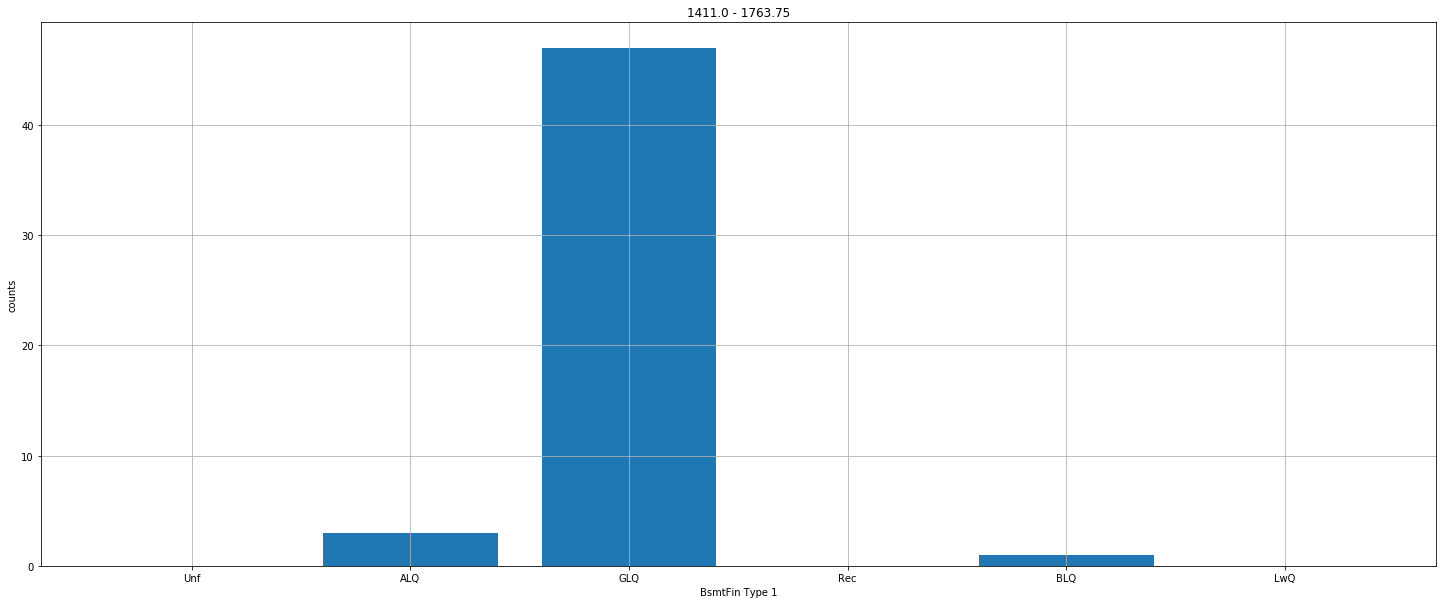

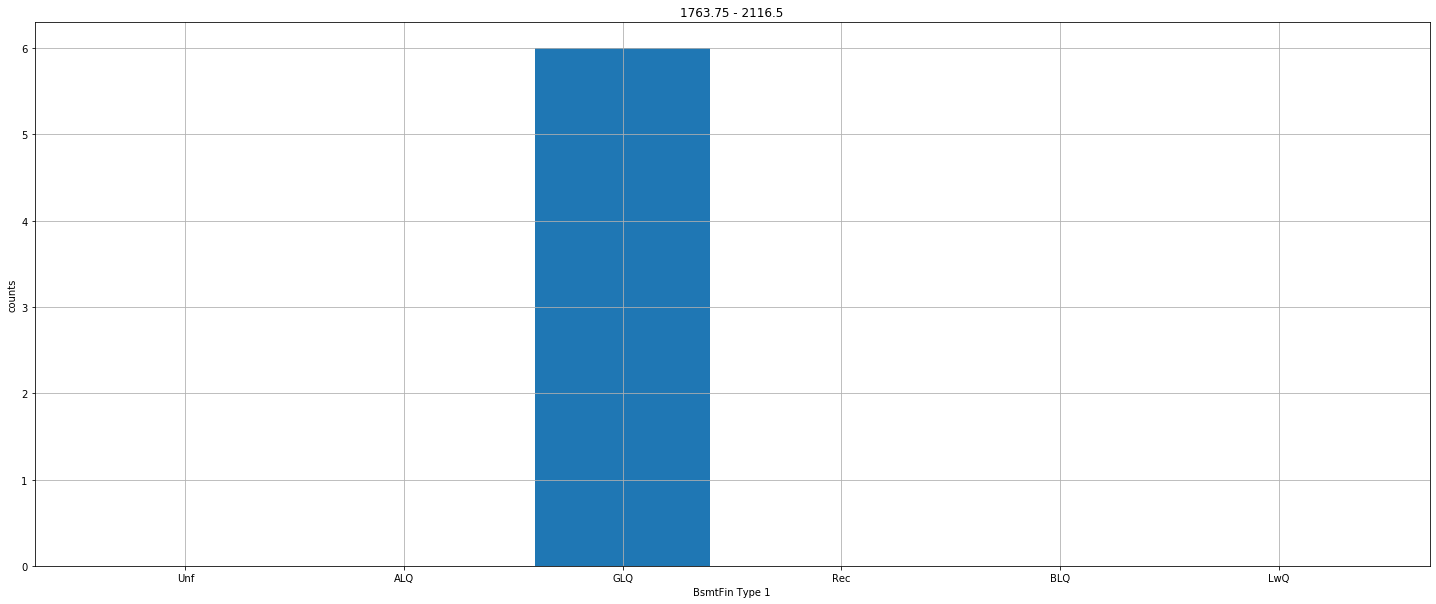

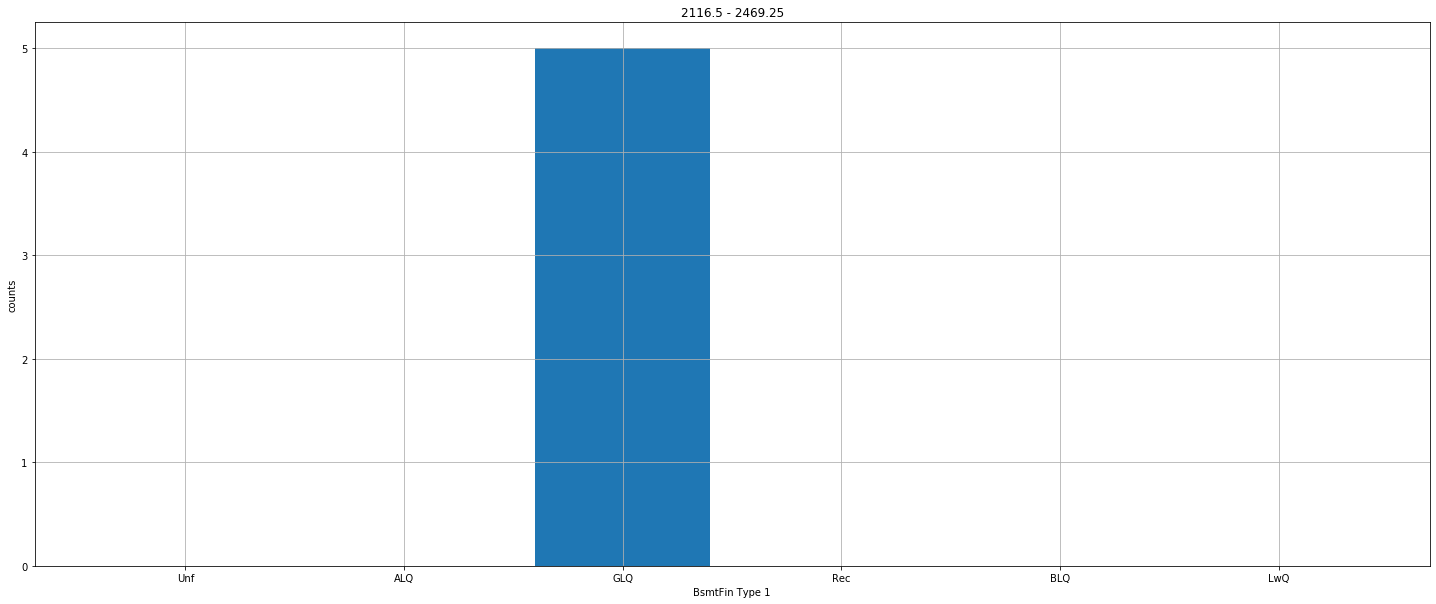

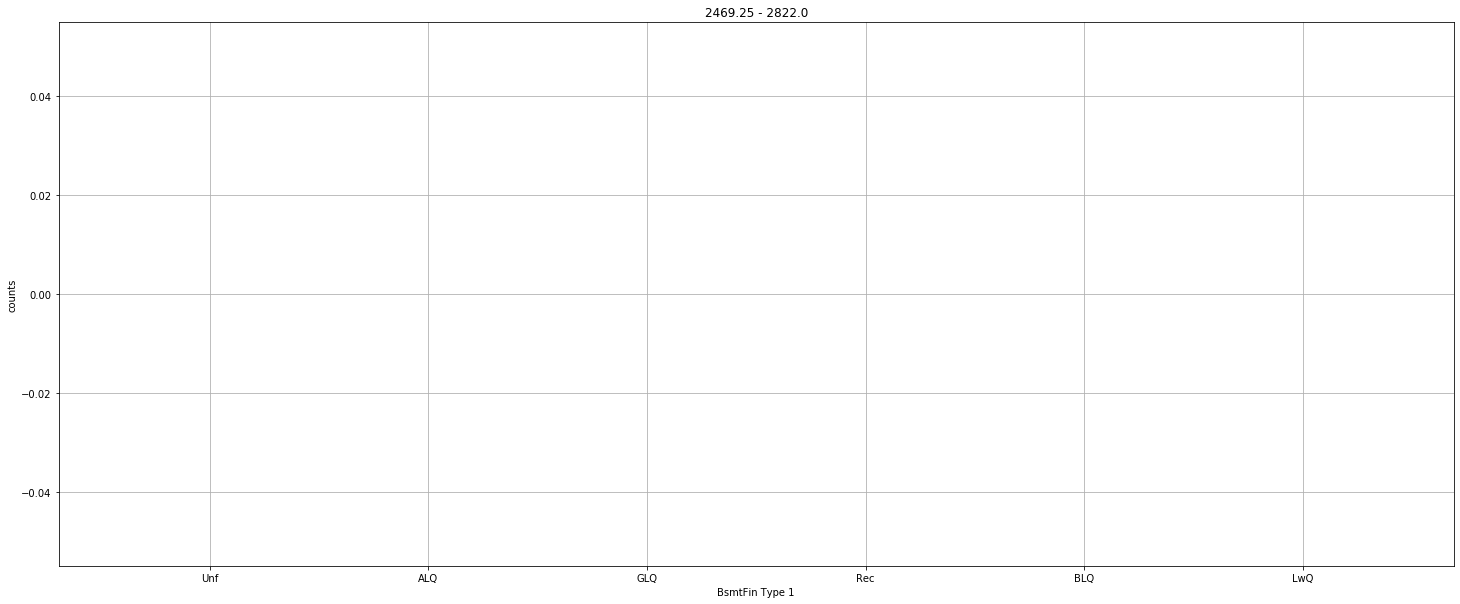

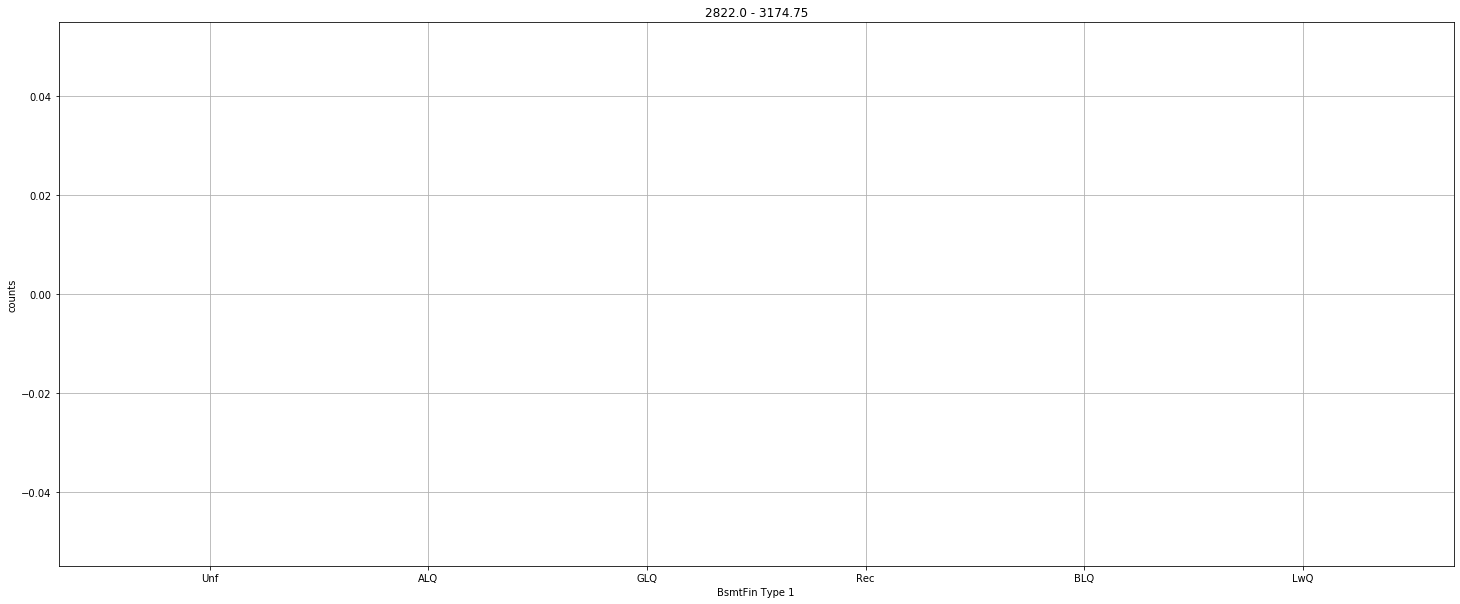

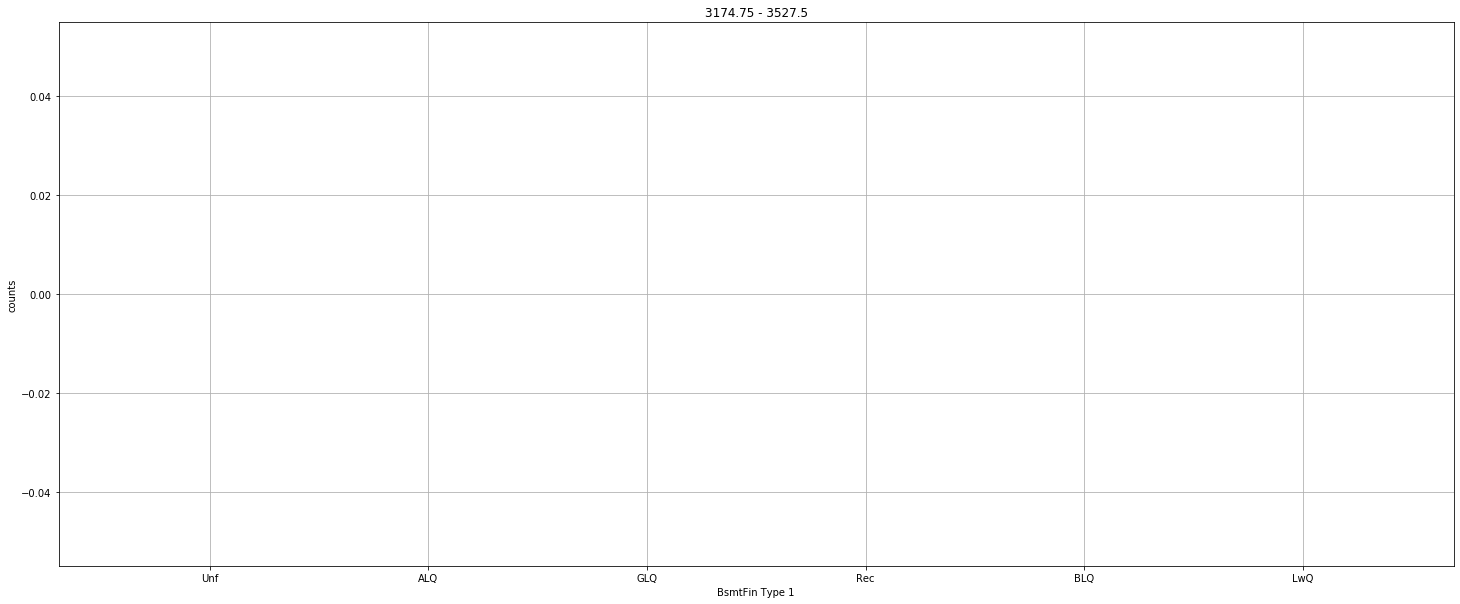

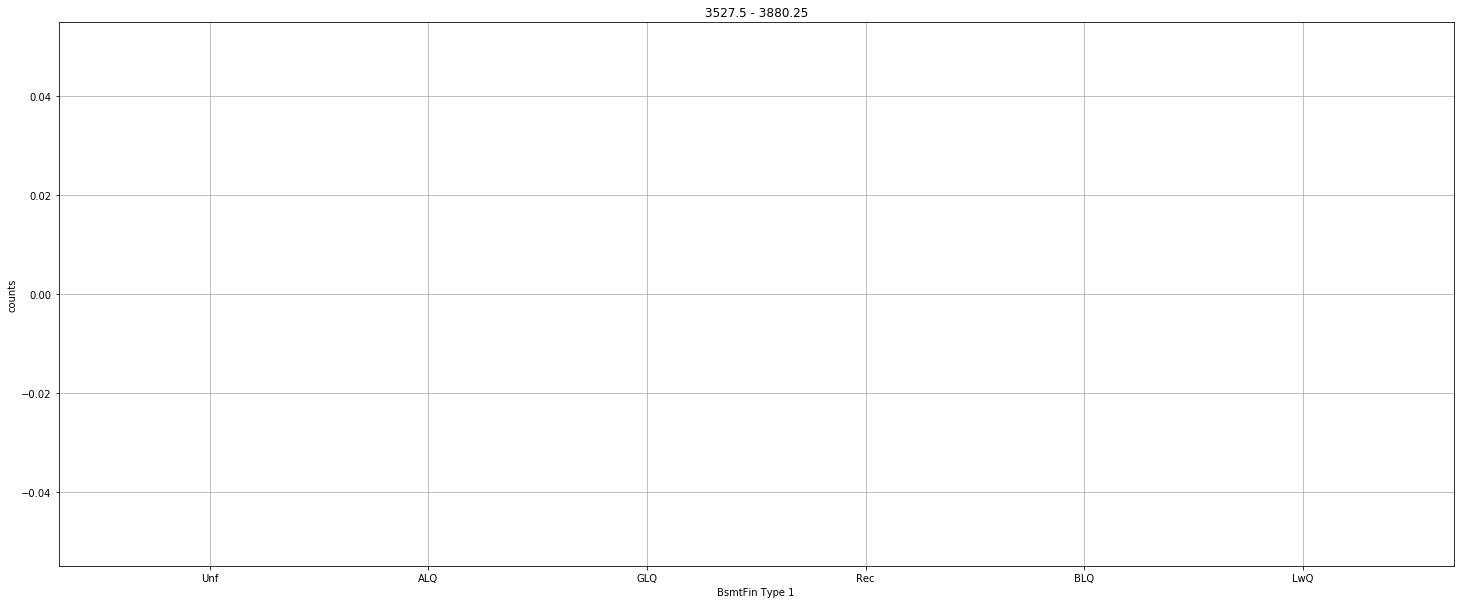

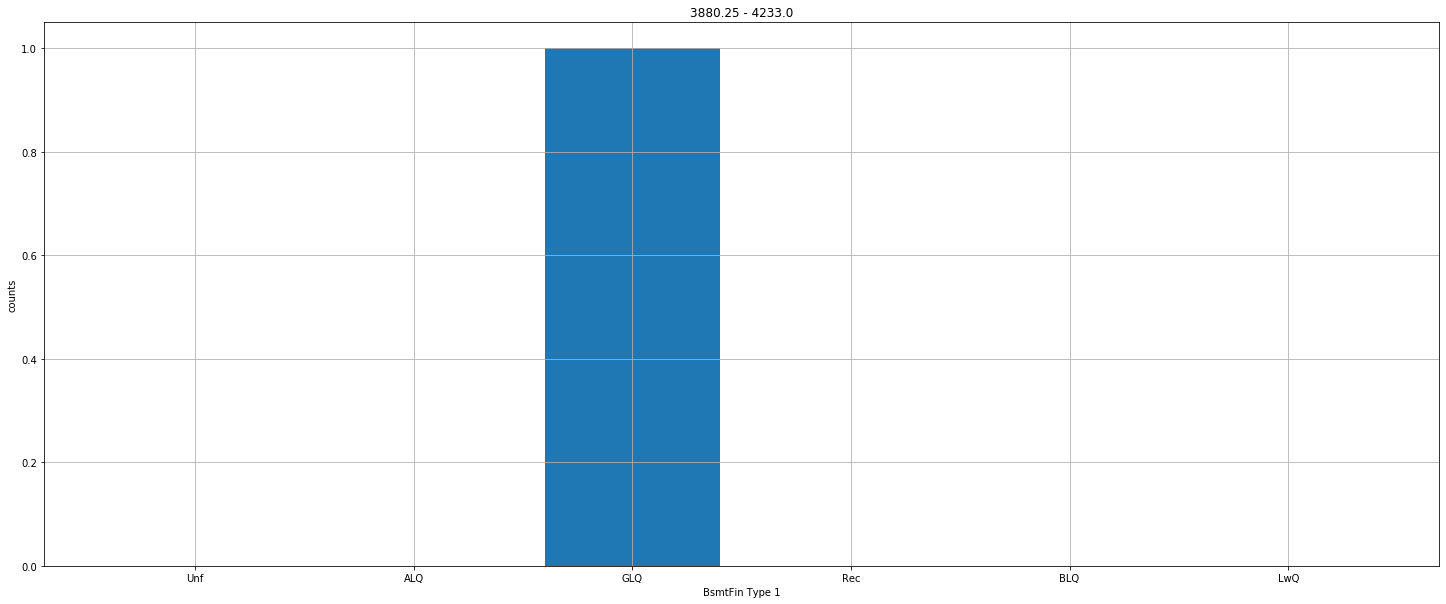

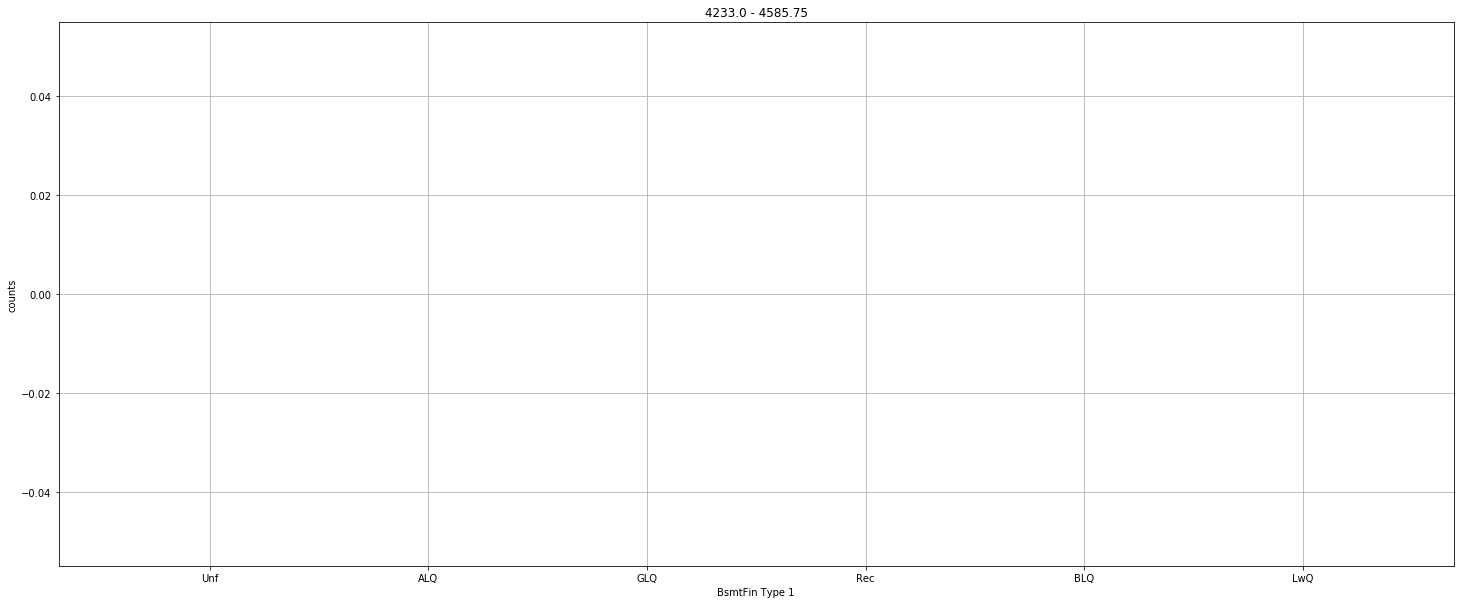

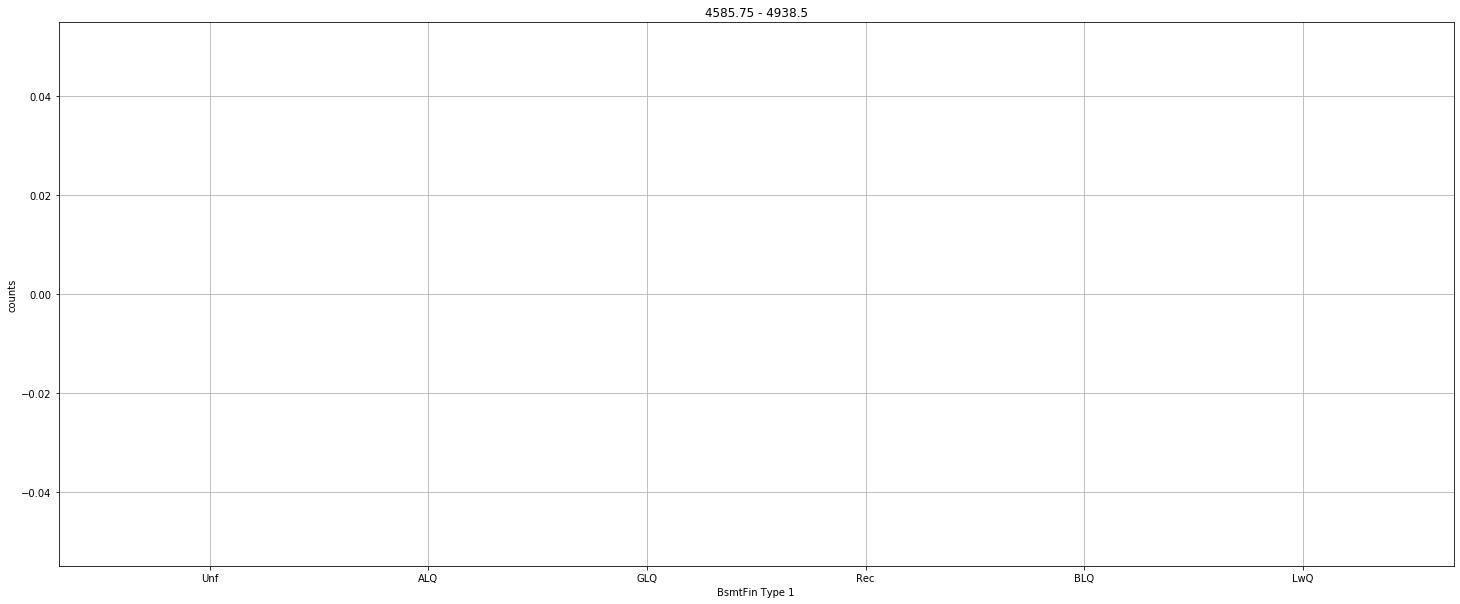

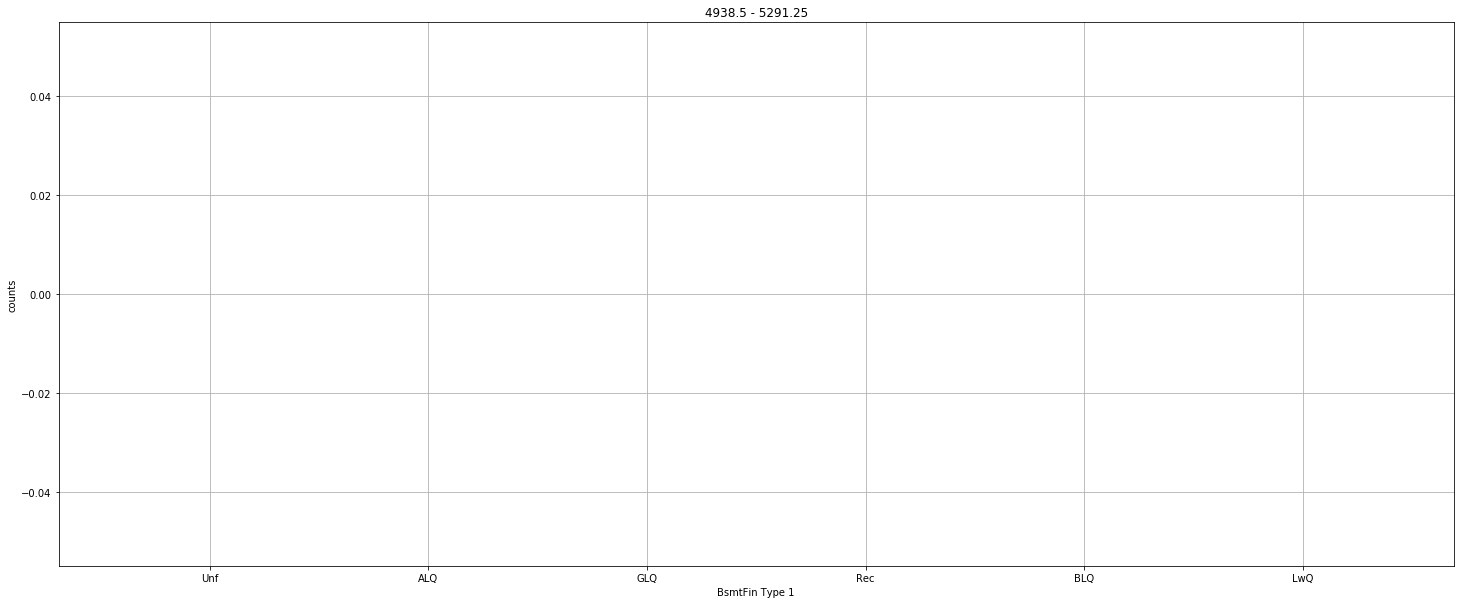

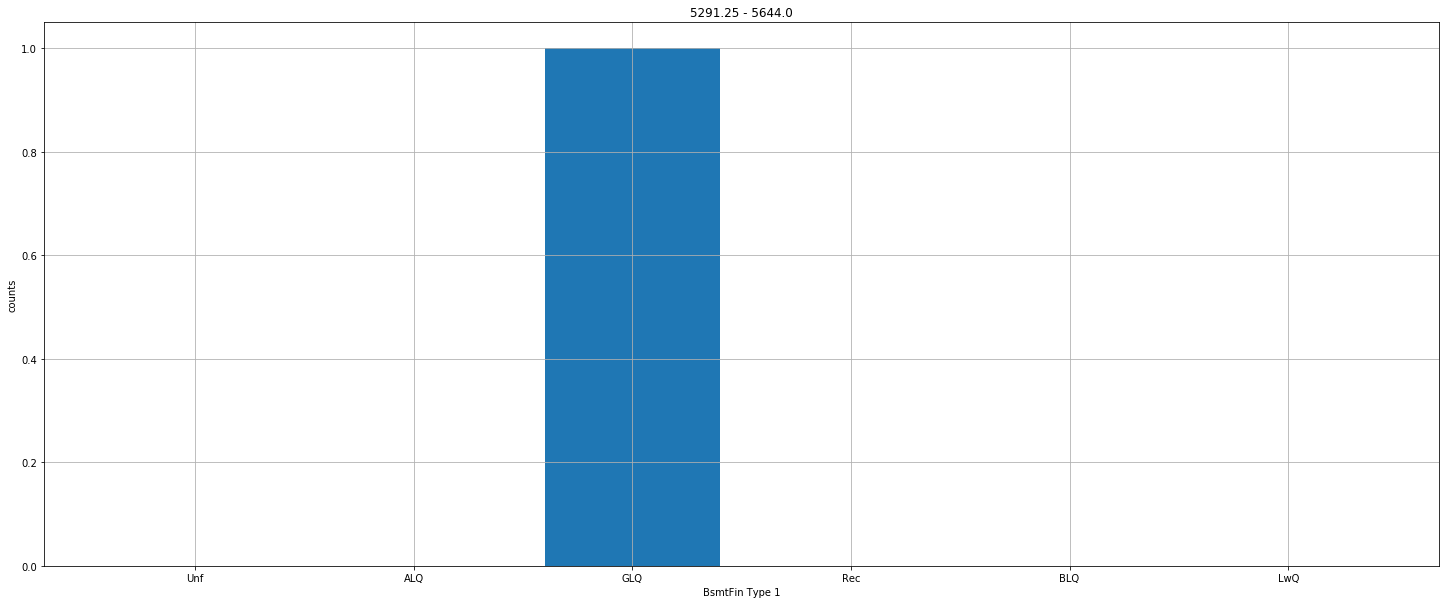

In [31]:
# 'BsmtFin Type 1' ОТ 'BsmtFin SF 1'
period = (train['BsmtFin SF 1'].max() - train['BsmtFin SF 1'].min()) / 16
start = train['BsmtFin SF 1'].min()
fin = start + period + 1
for i in range(16):
    cols = ['Unf', 'ALQ', 'GLQ', 'Rec', 'BLQ', 'LwQ']

    cls = []

    for col in cols:
        cls.append(train[(train['BsmtFin Type 1'] == col) & (train['BsmtFin SF 1'] >= start) & (train['BsmtFin SF 1'] < fin)][['BsmtFin Type 1']]['BsmtFin Type 1'].count())

    fig = plt.figure(figsize= (25,10))
    ax1 = fig.add_subplot()
    ax1.set_xlabel('BsmtFin Type 1')
    ax1.set_ylabel('counts')
    ax1.set_title('{0} - {1}'.format(start, fin - 1))
    ax1.grid()
    ax1.bar(cols, cls) 
    start = fin - 1
    fin = start + period + 1

<BarContainer object of 5 artists>

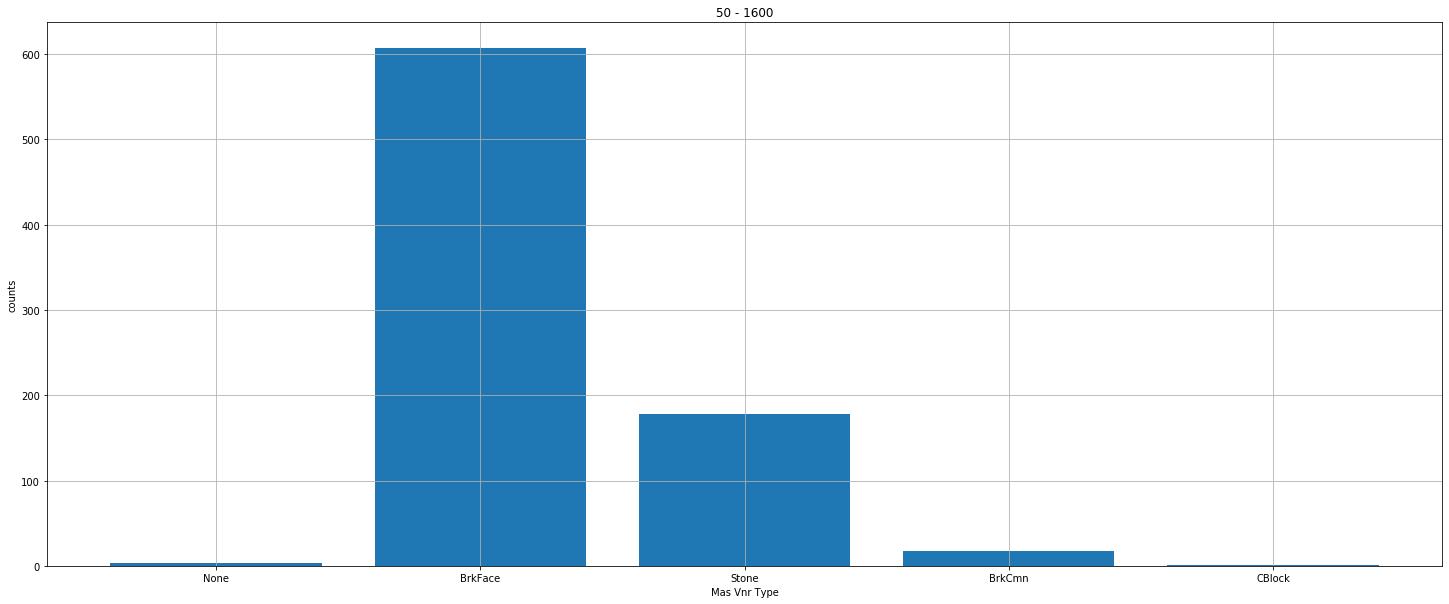

In [32]:
cols = ['None', 'BrkFace', 'Stone', 'BrkCmn', 'CBlock']

cls = []

for col in cols:    
    cls.append(train[(train['Mas Vnr Type'] == col) & (train['Mas Vnr Area'] > 50) ][['Mas Vnr Type']]['Mas Vnr Type'].count())

fig = plt.figure(figsize= (25,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('Mas Vnr Type')
ax1.set_ylabel('counts')
ax1.set_title('{0} - {1}'.format(50, 1600))
ax1.grid()
ax1.bar(cols, cls) 

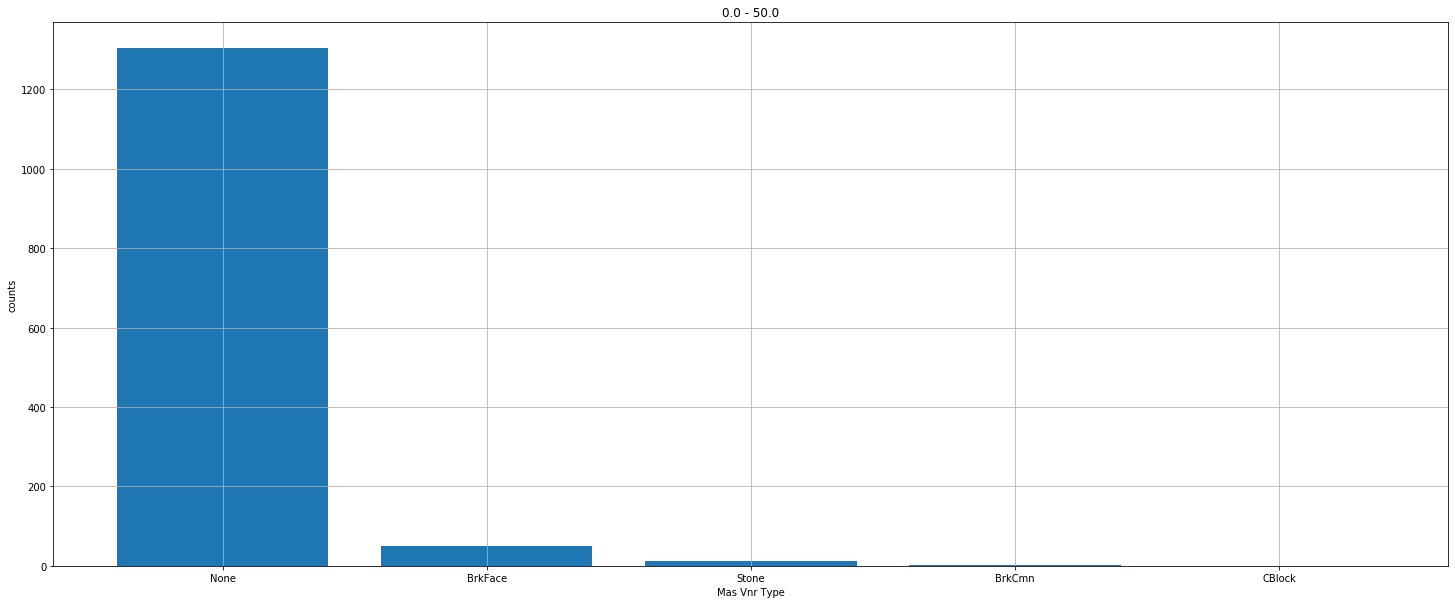

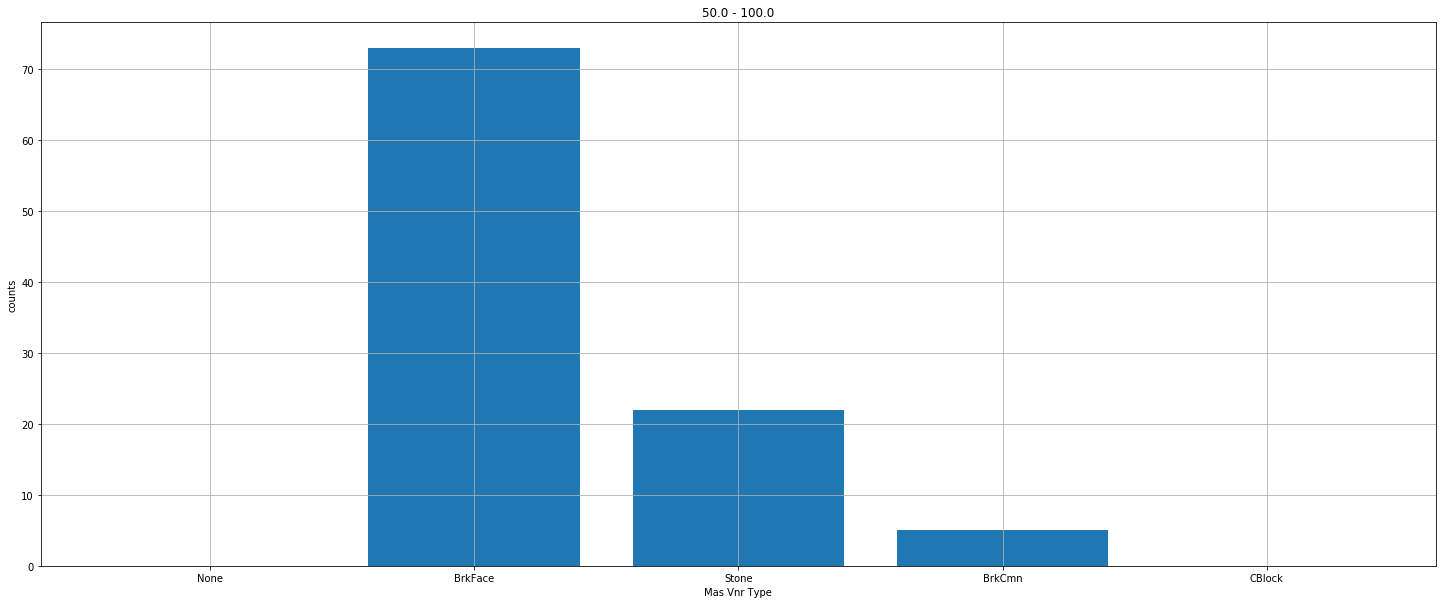

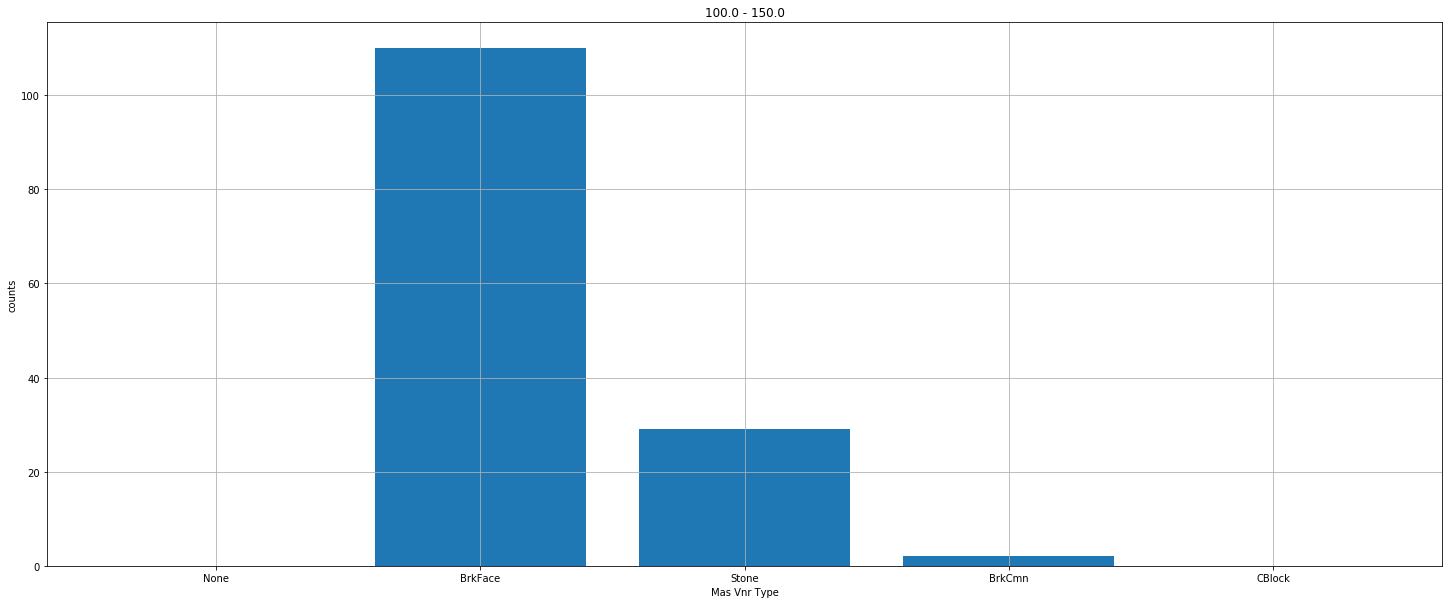

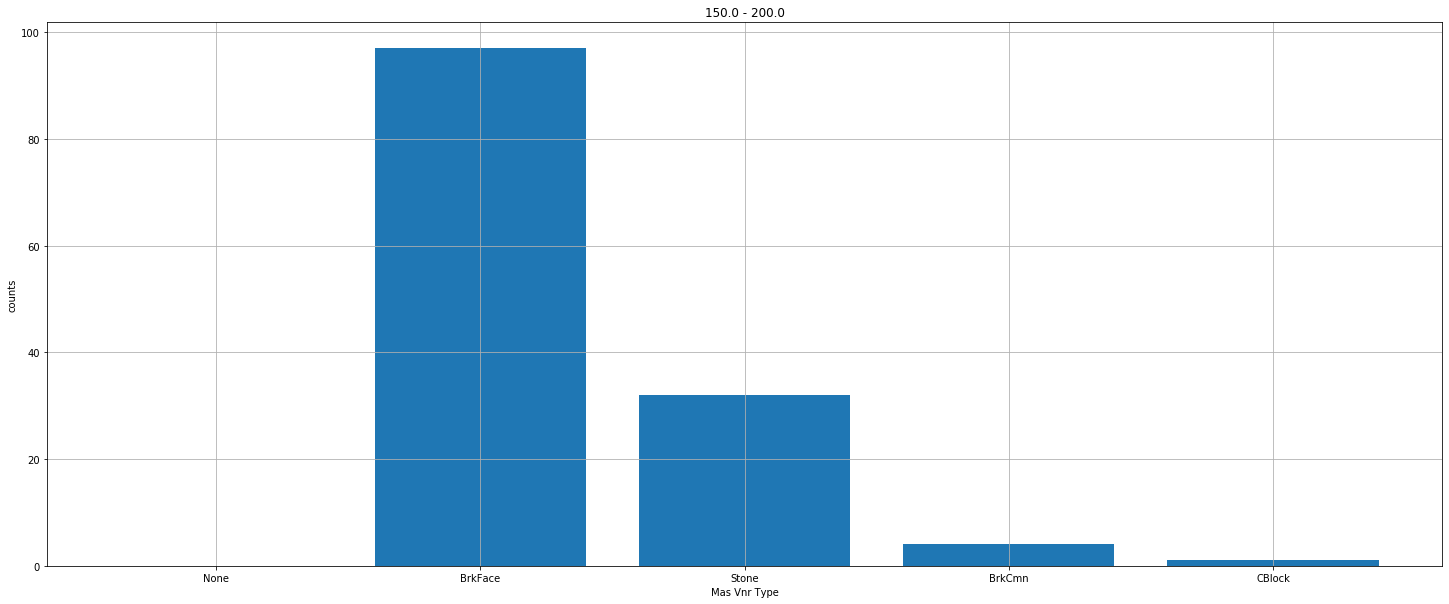

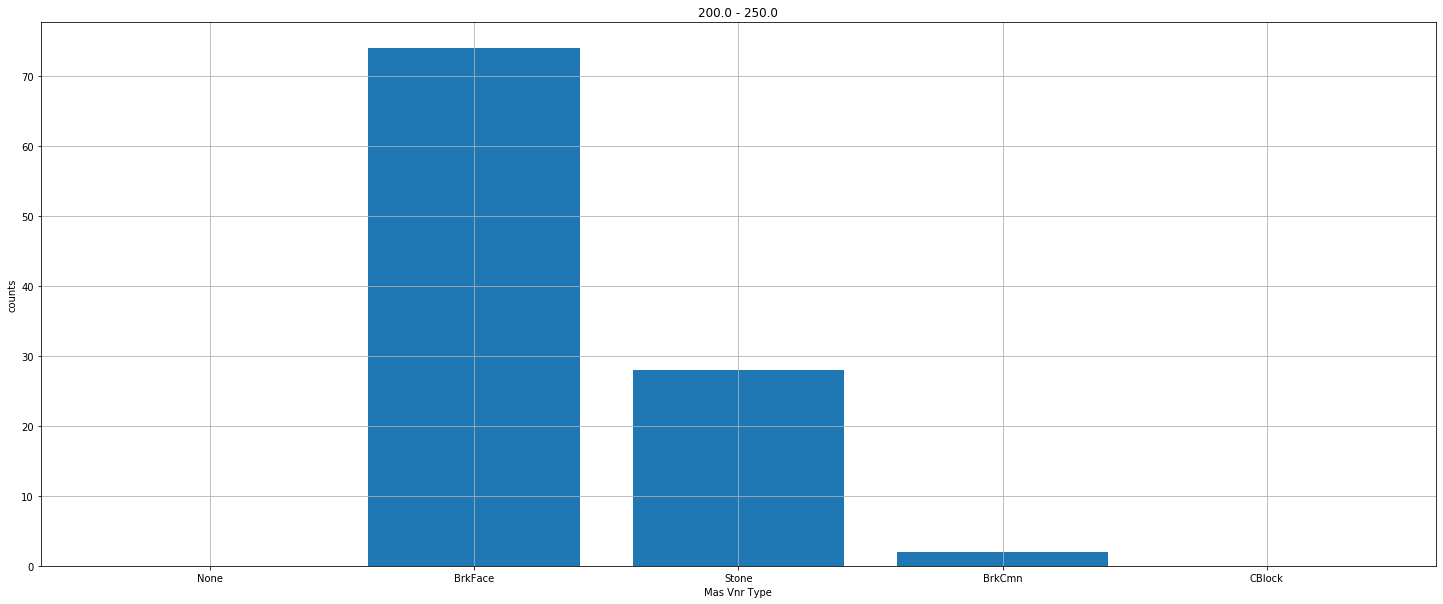

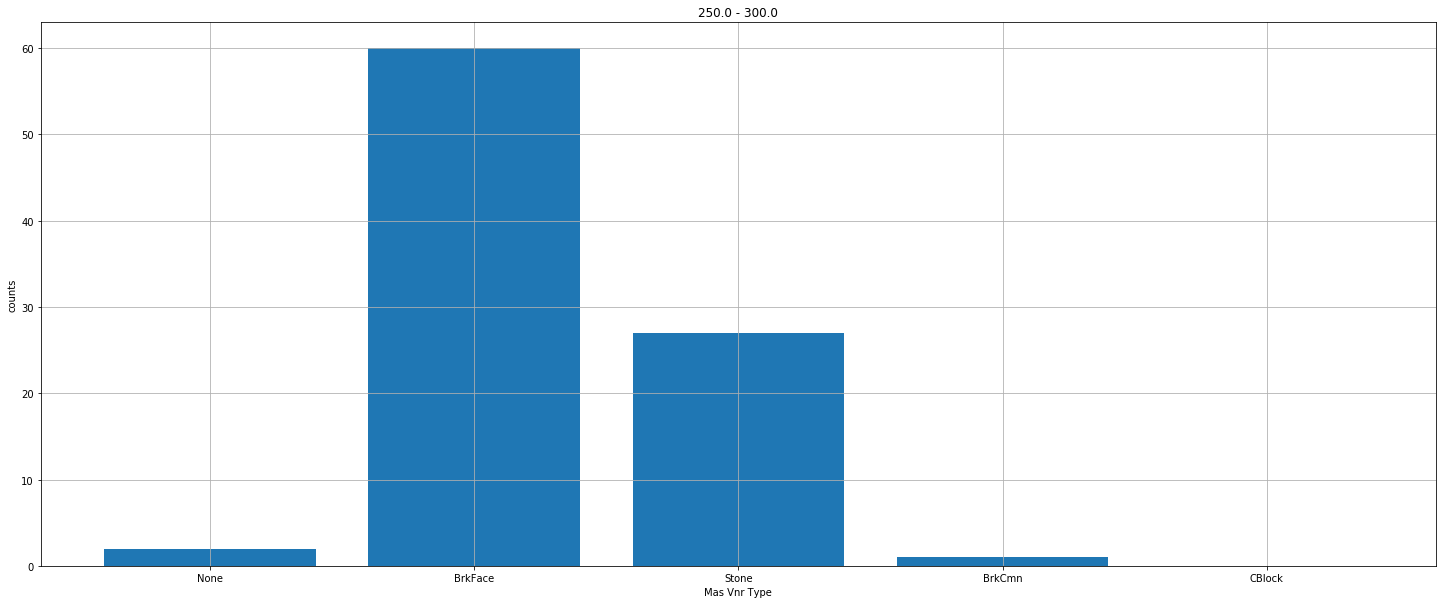

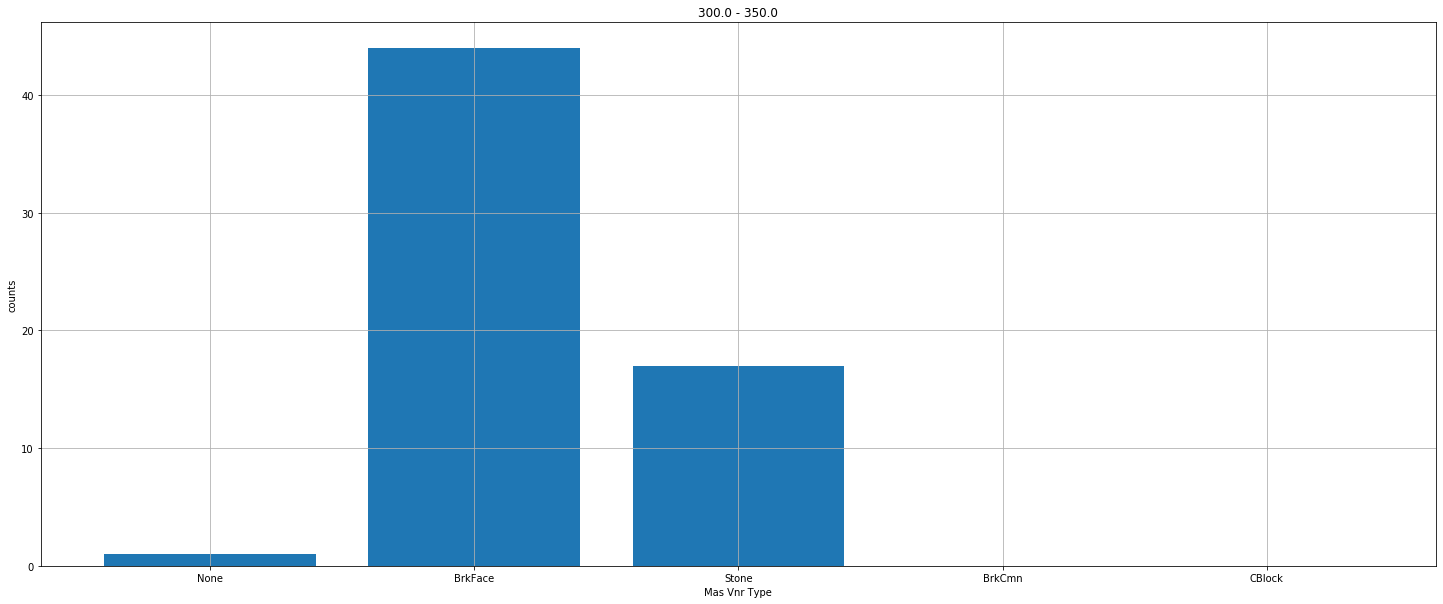

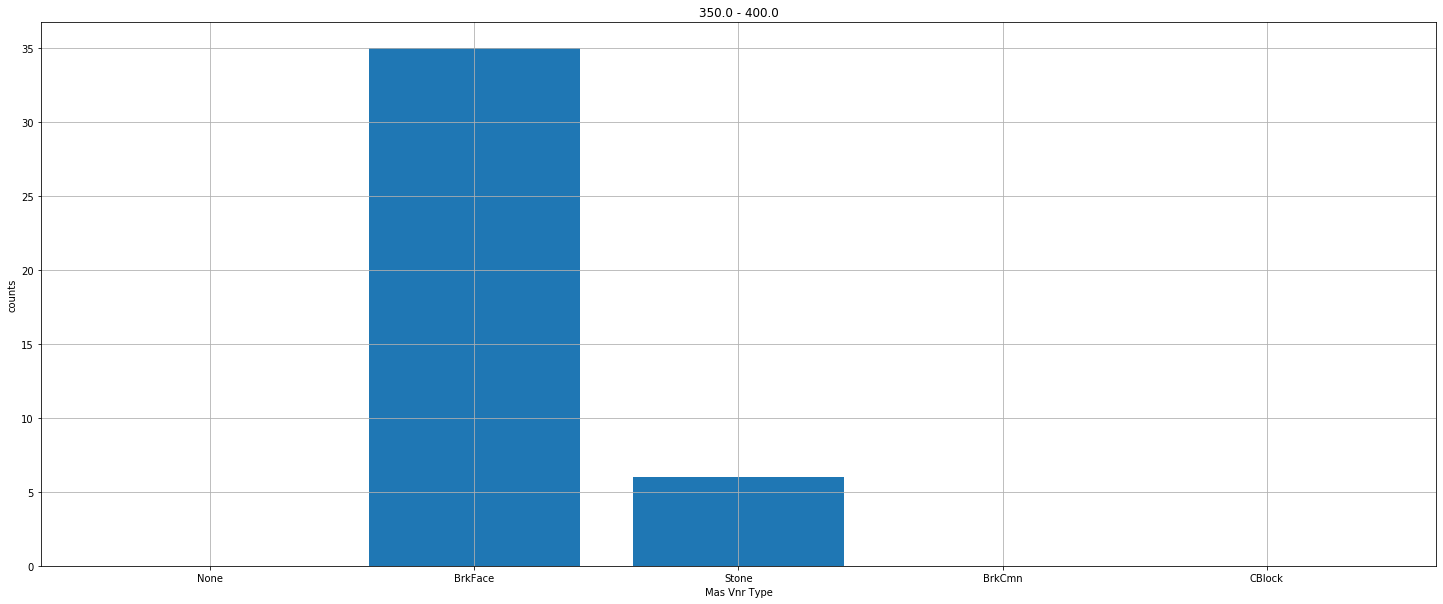

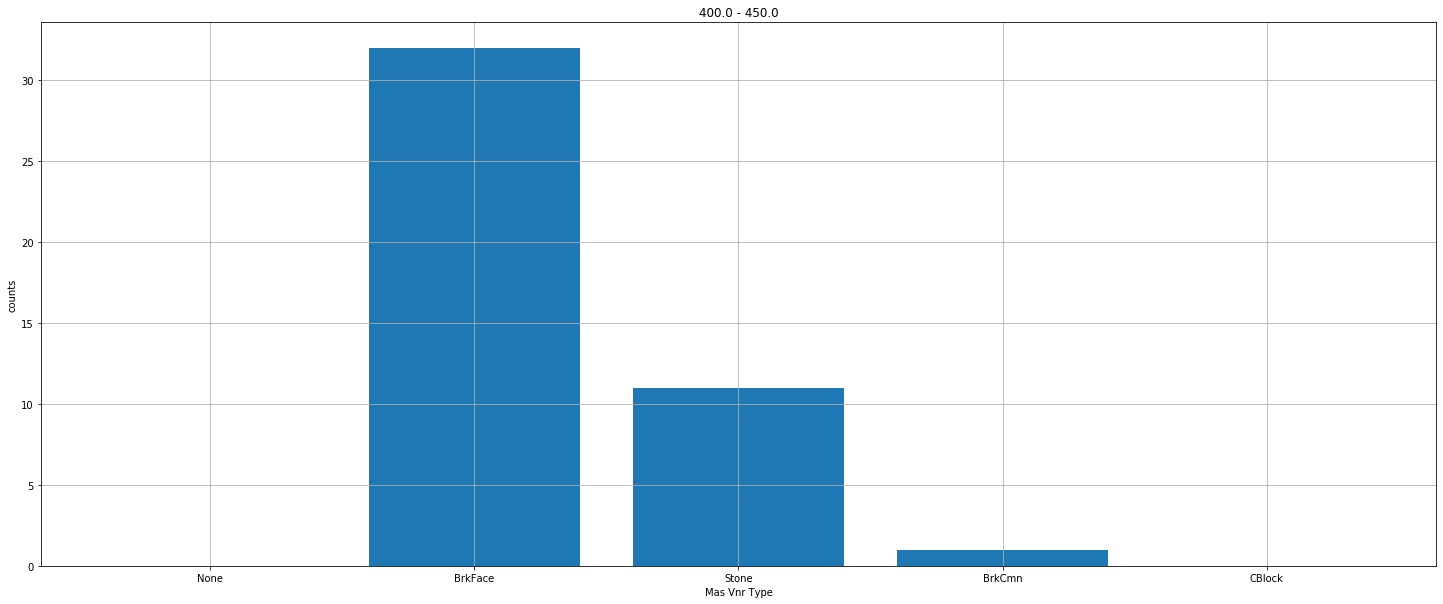

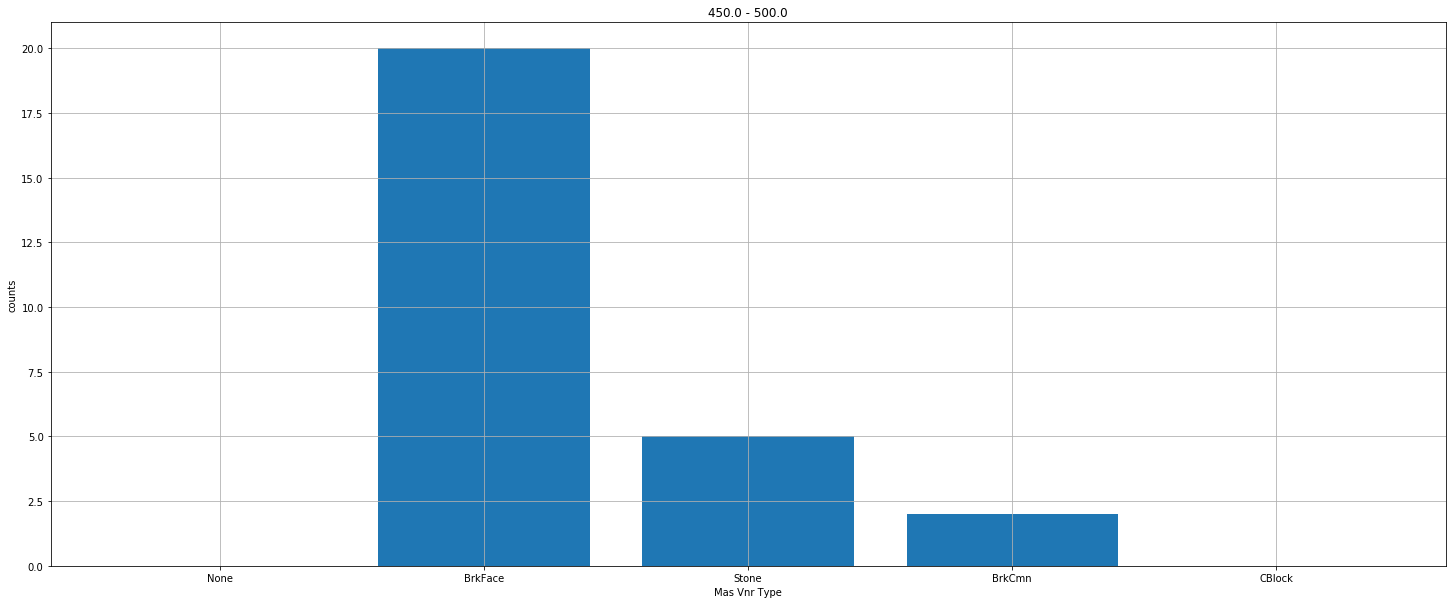

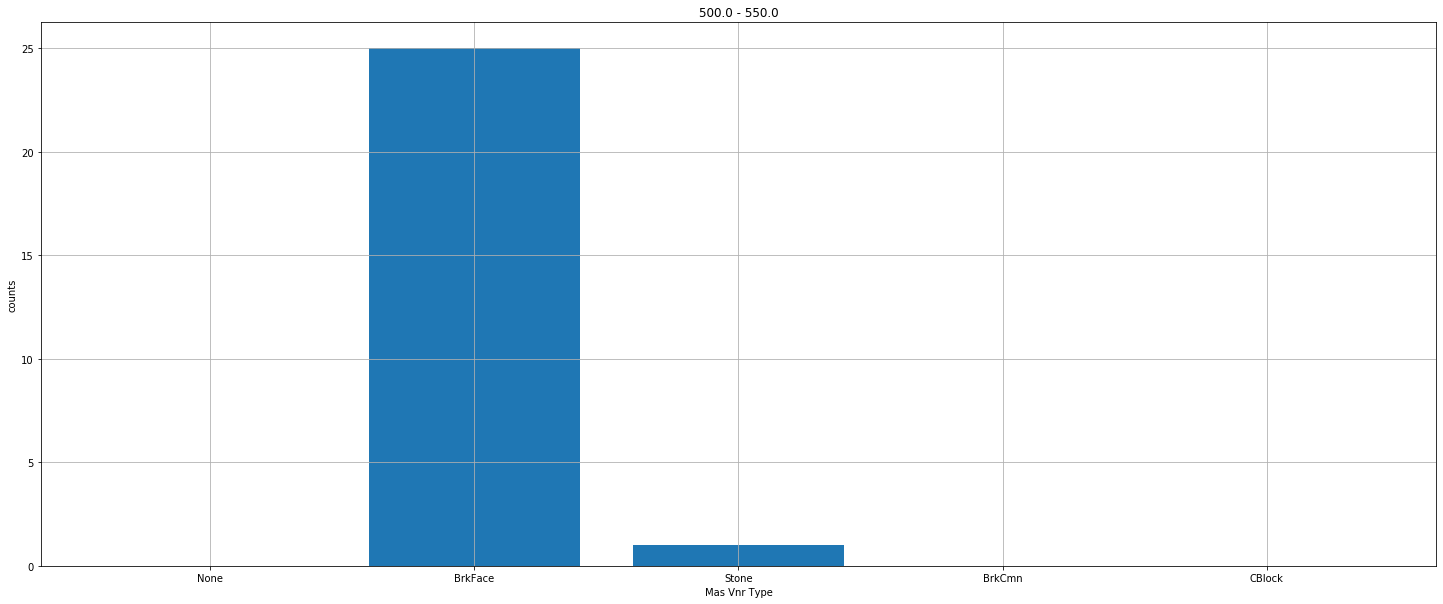

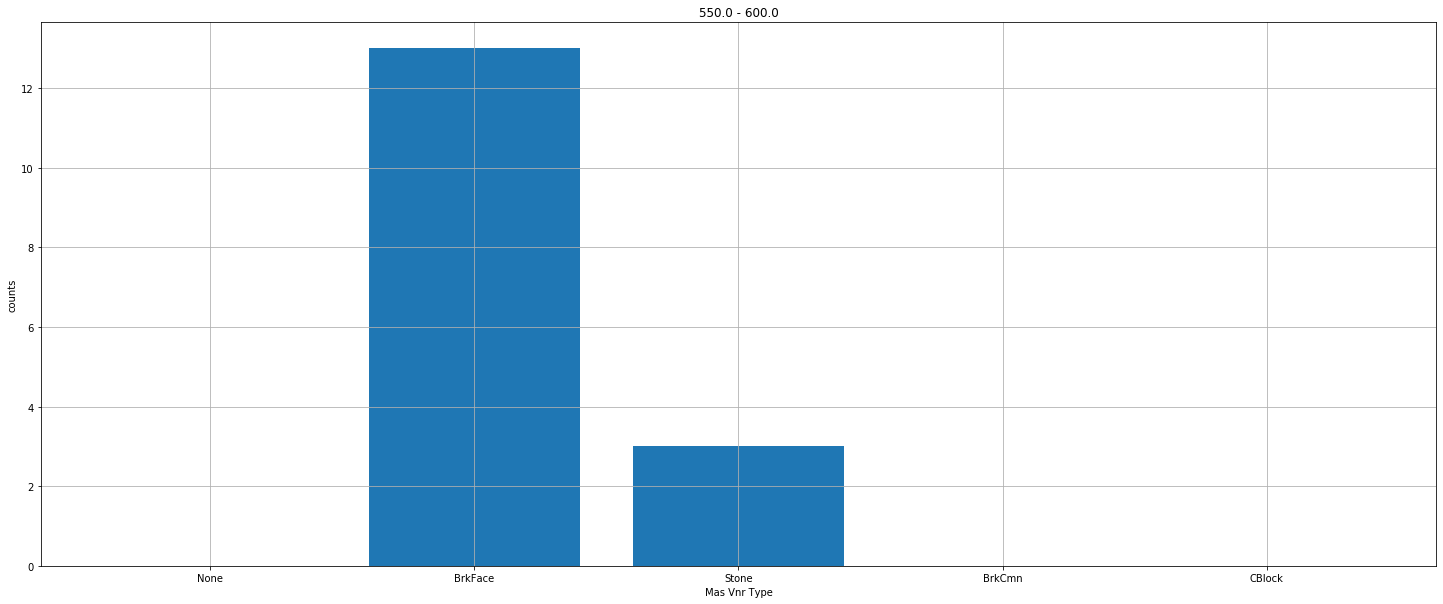

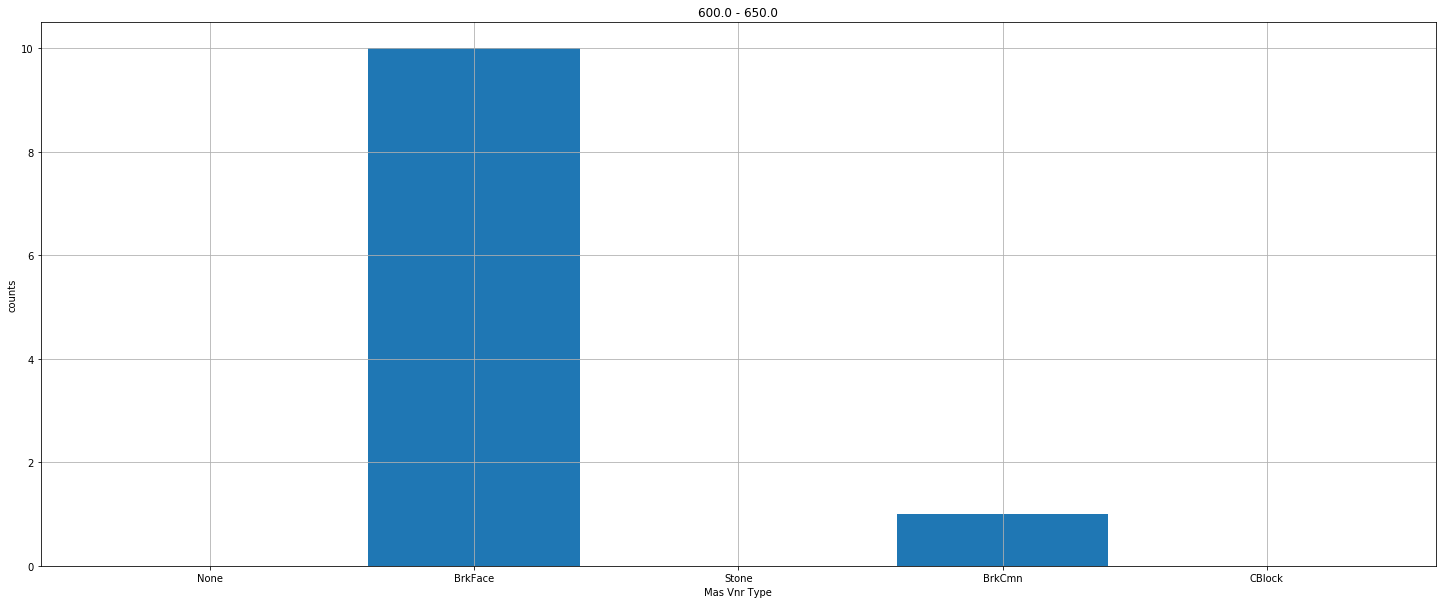

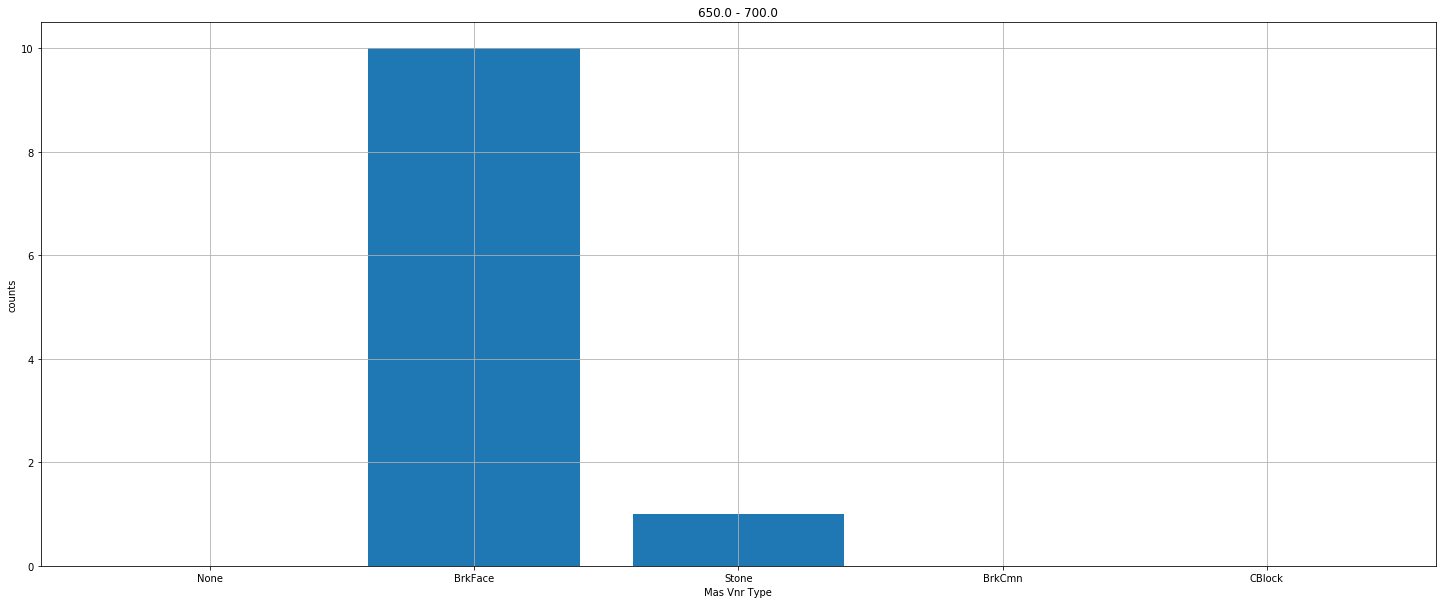

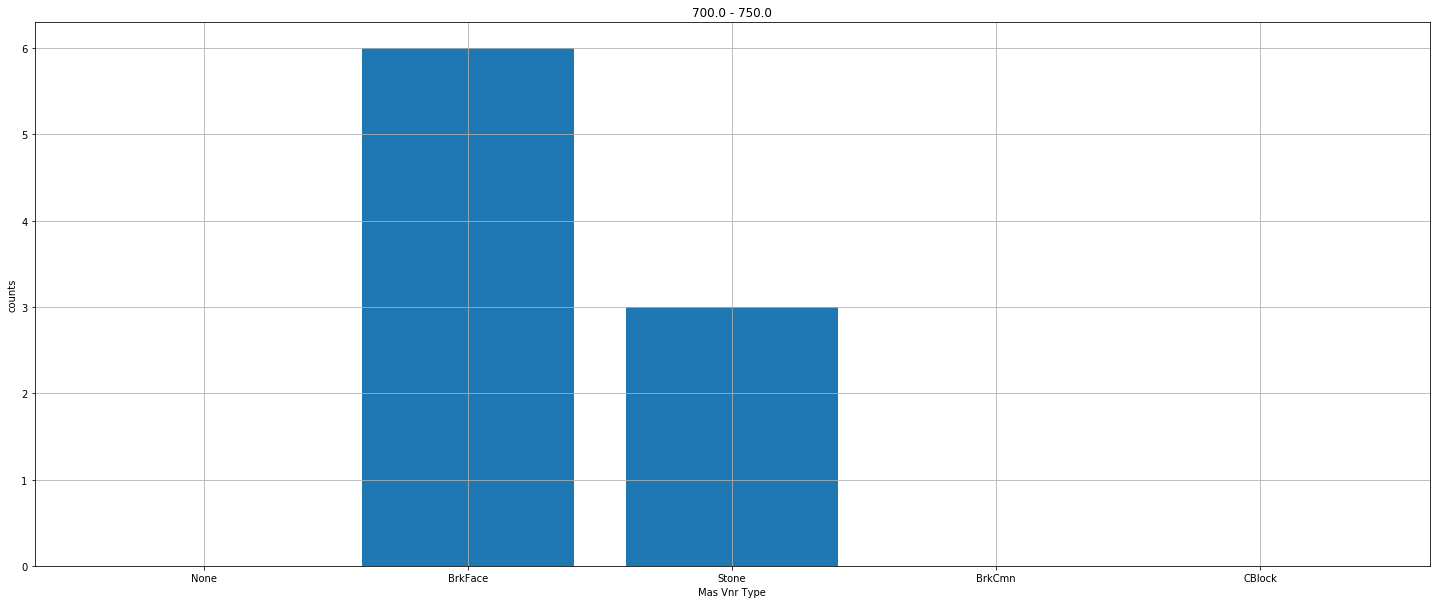

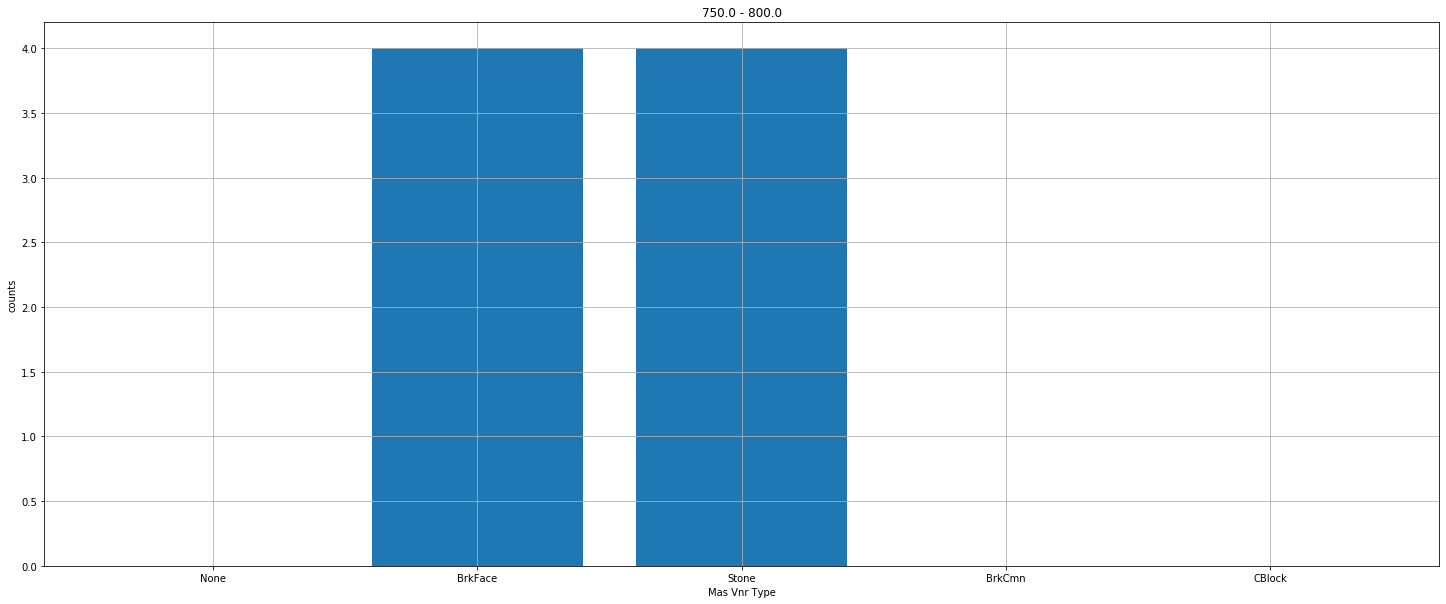

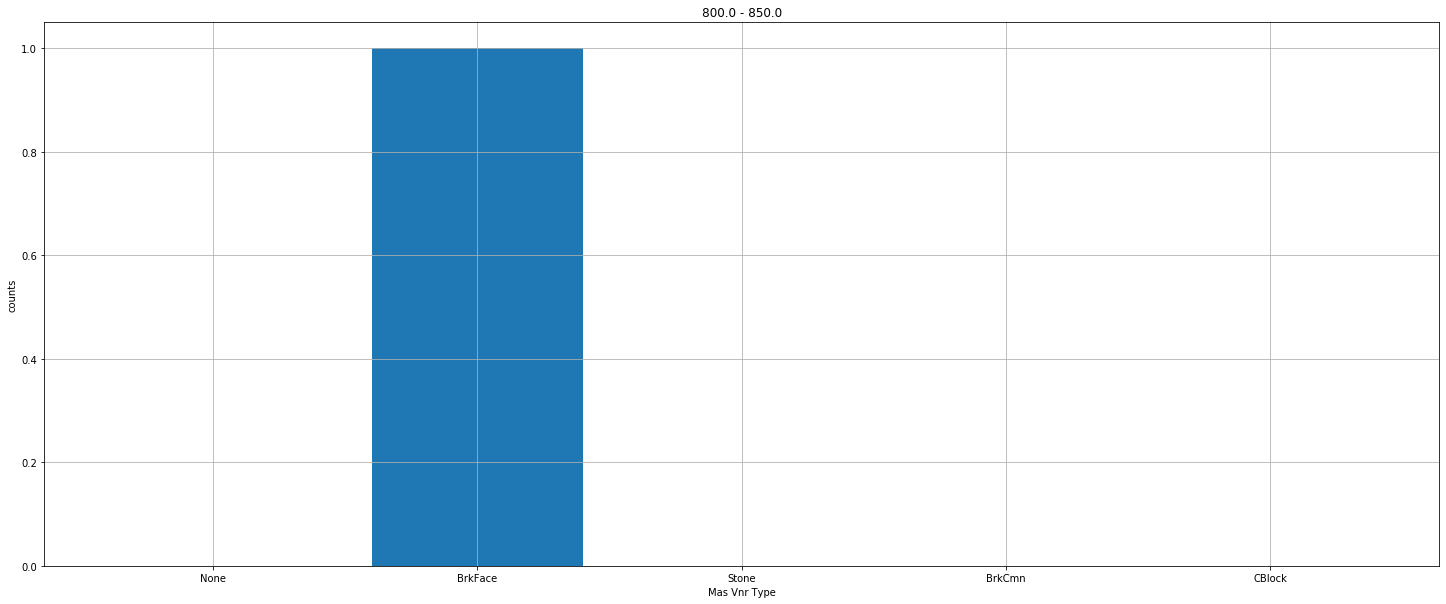

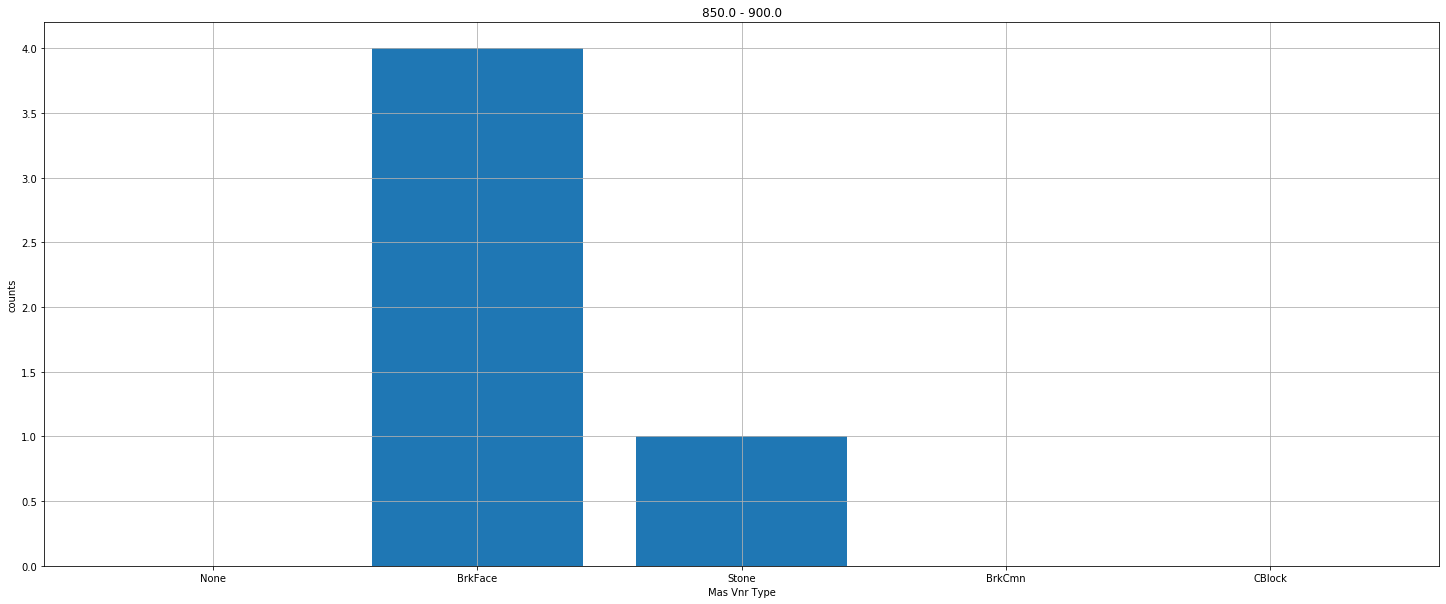

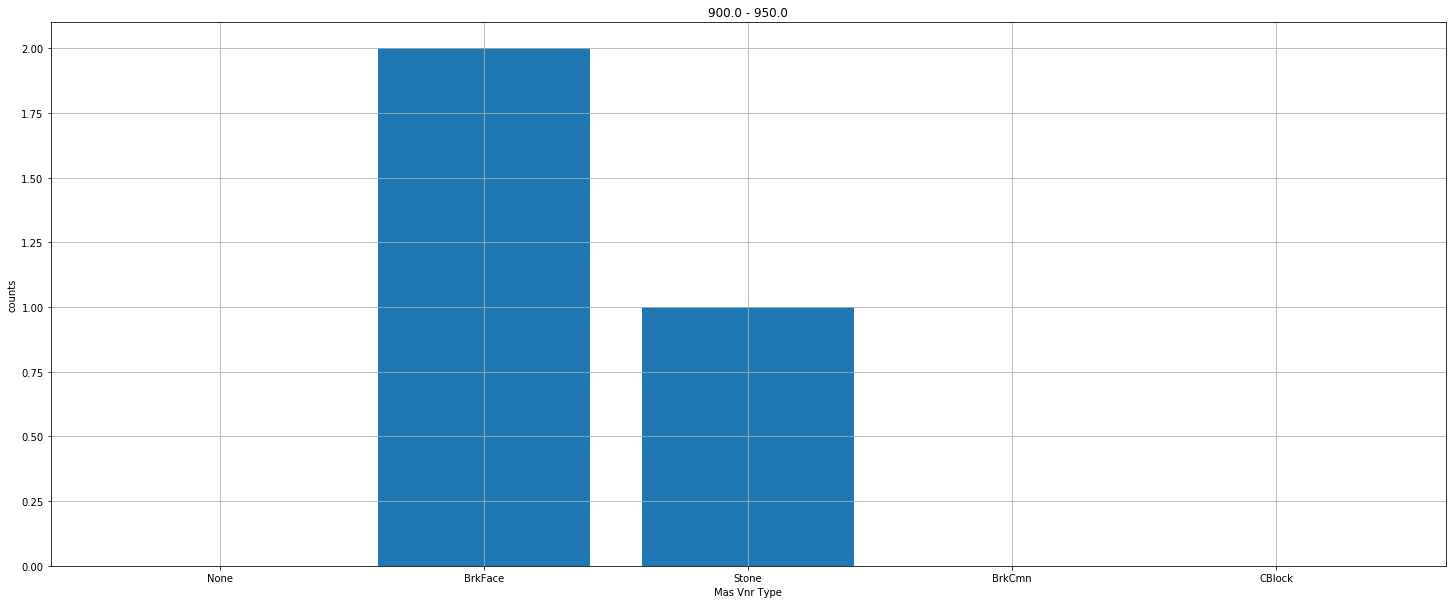

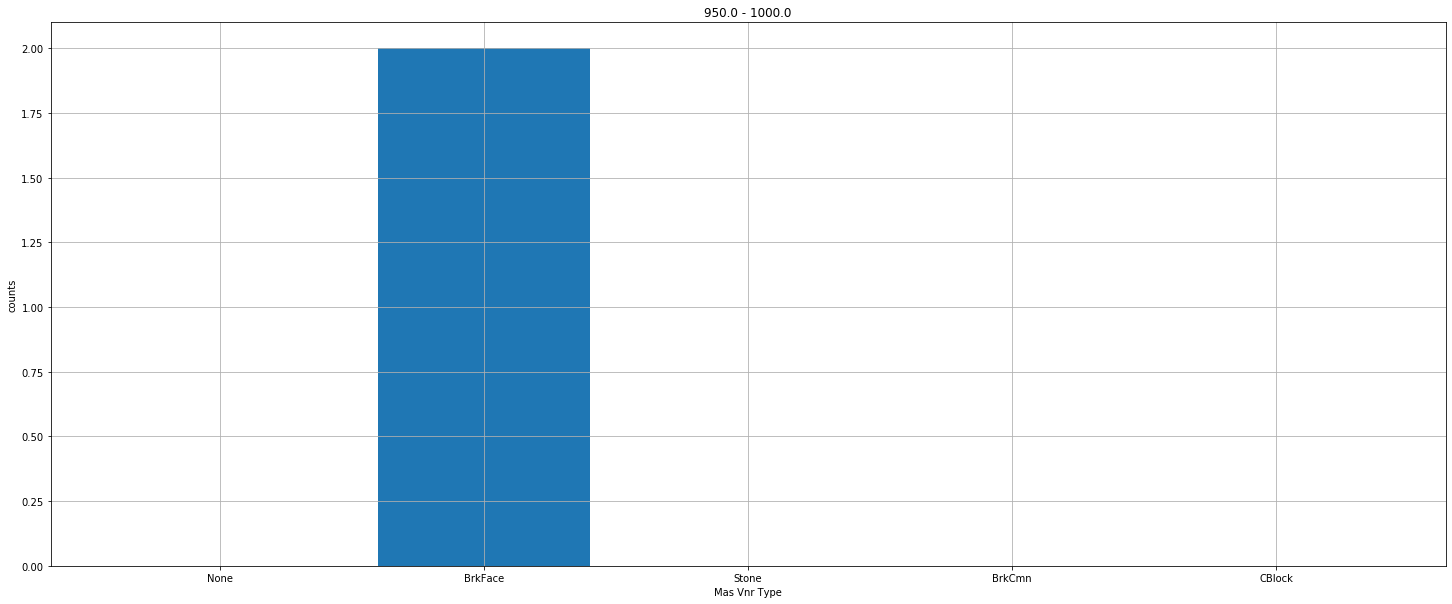

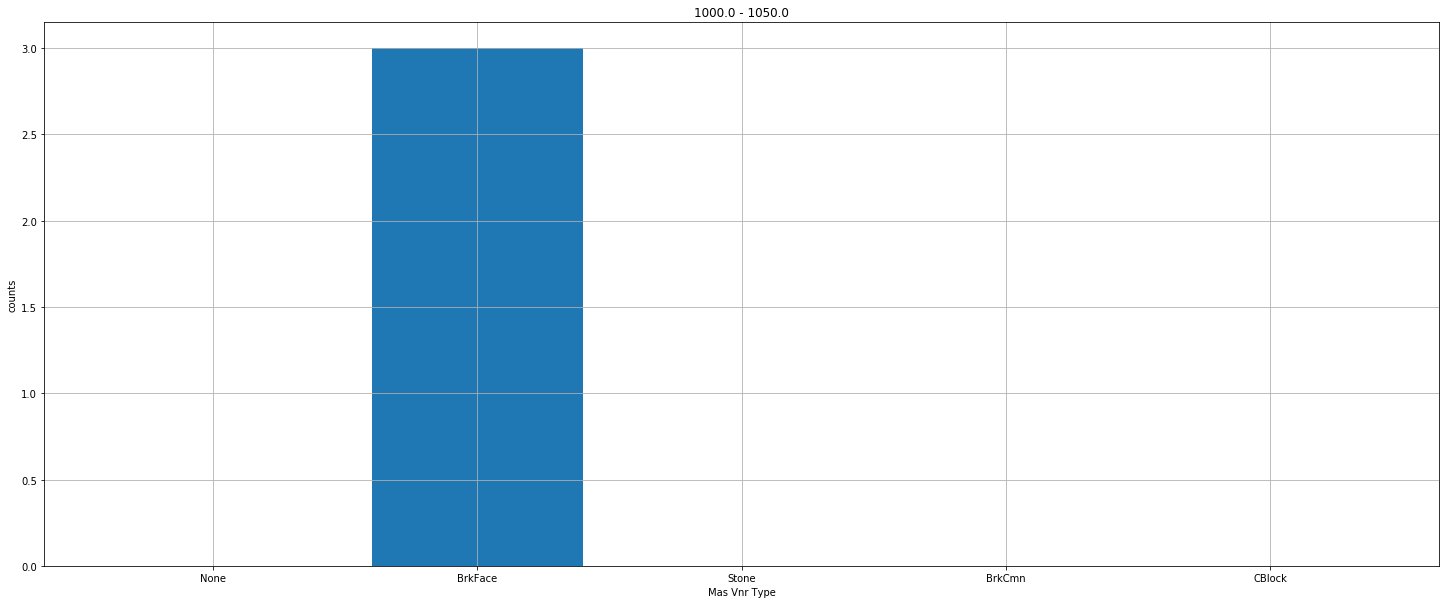

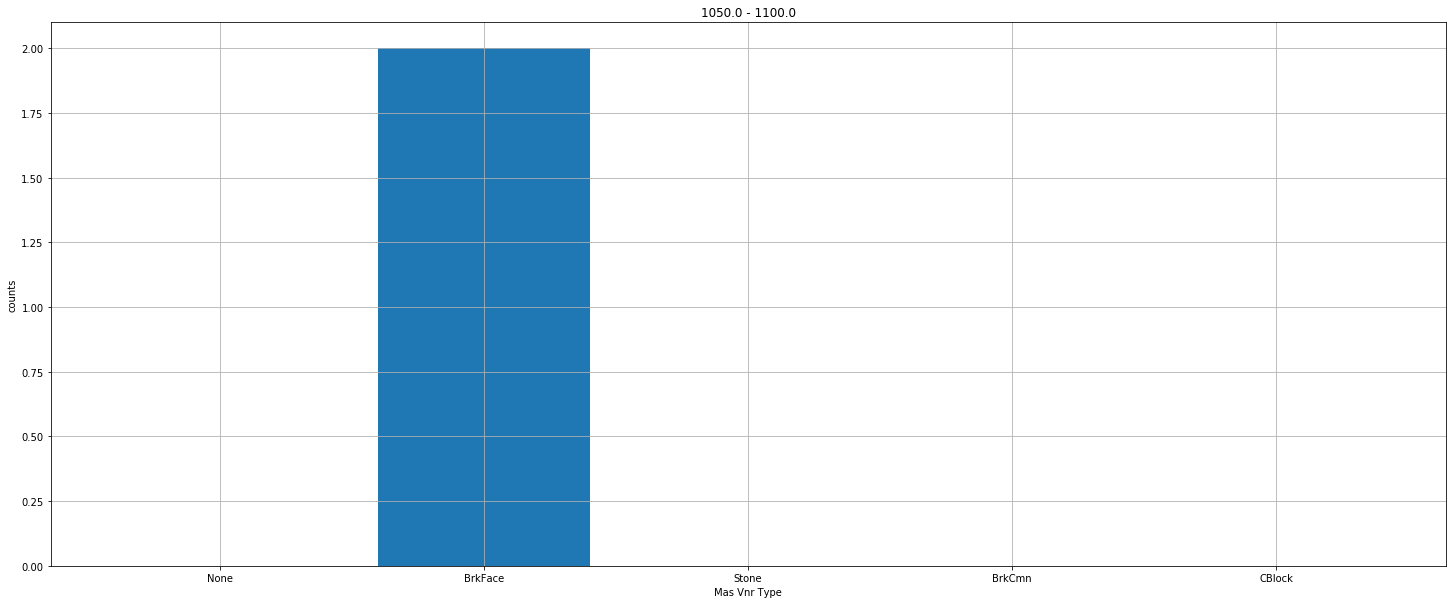

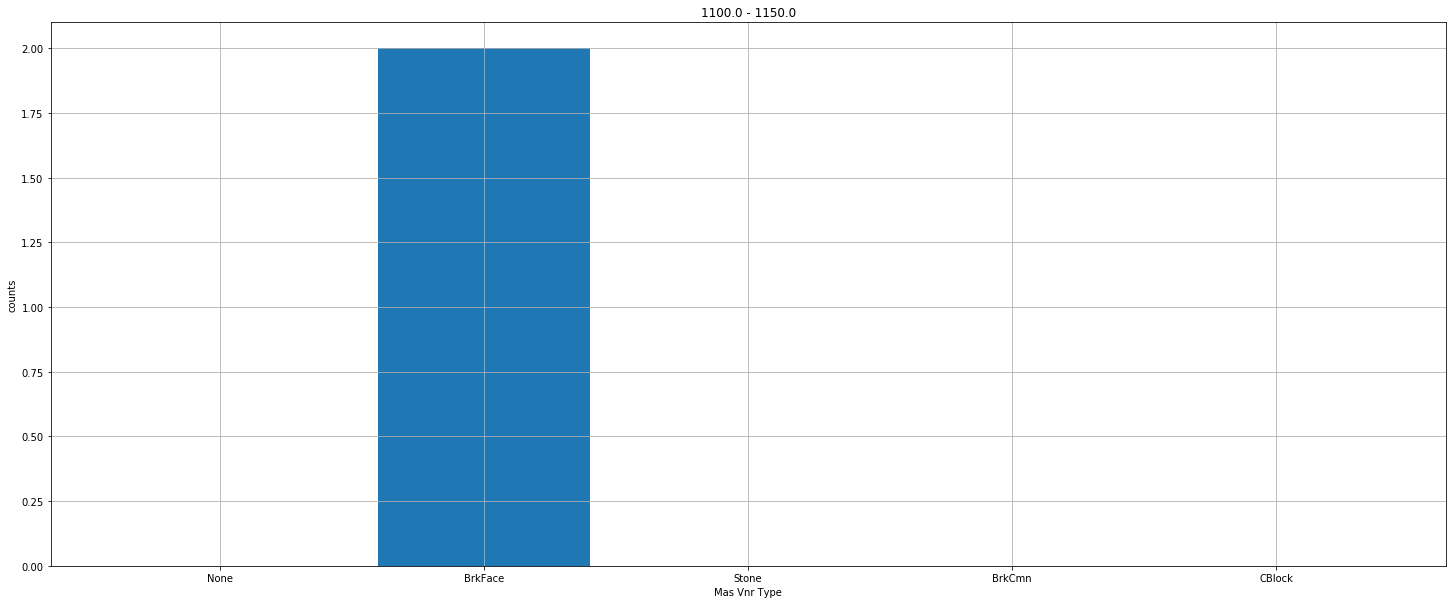

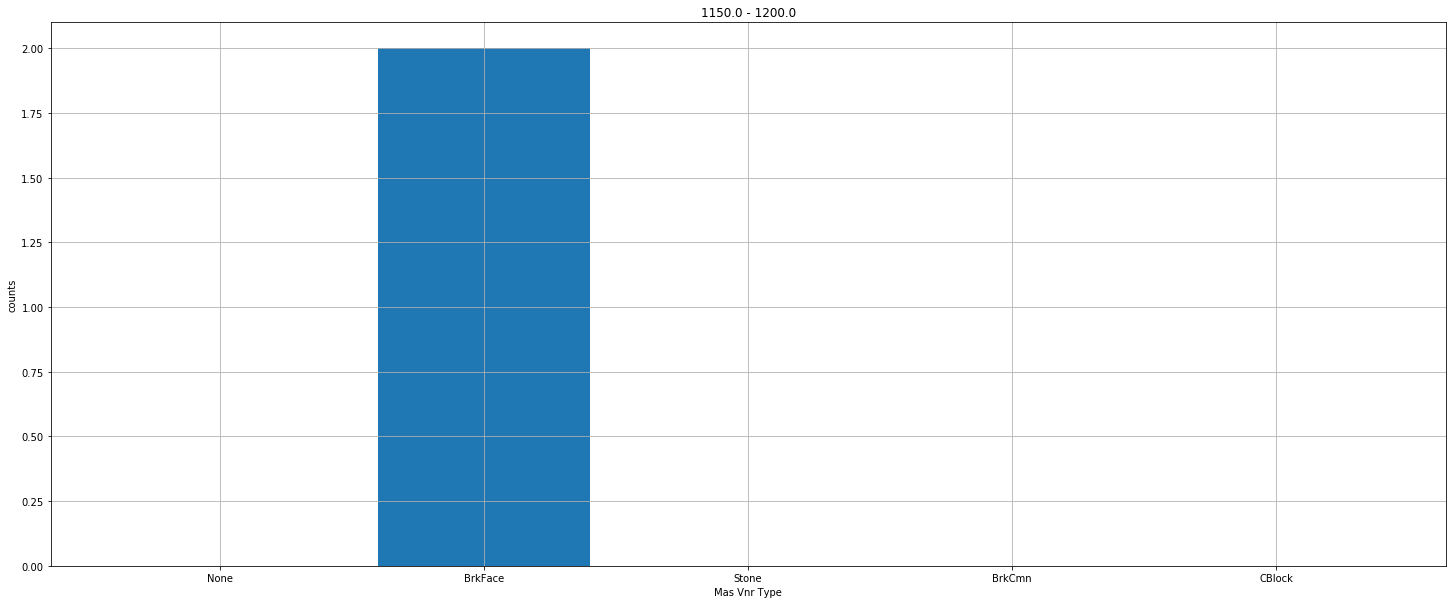

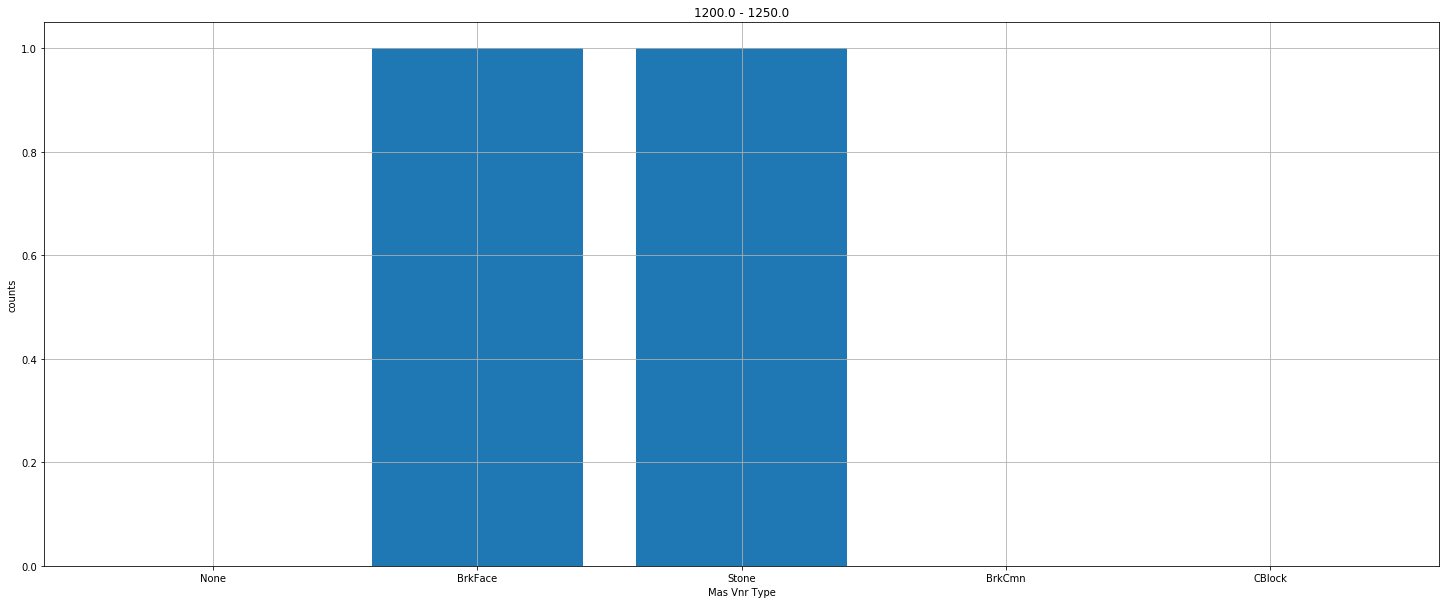

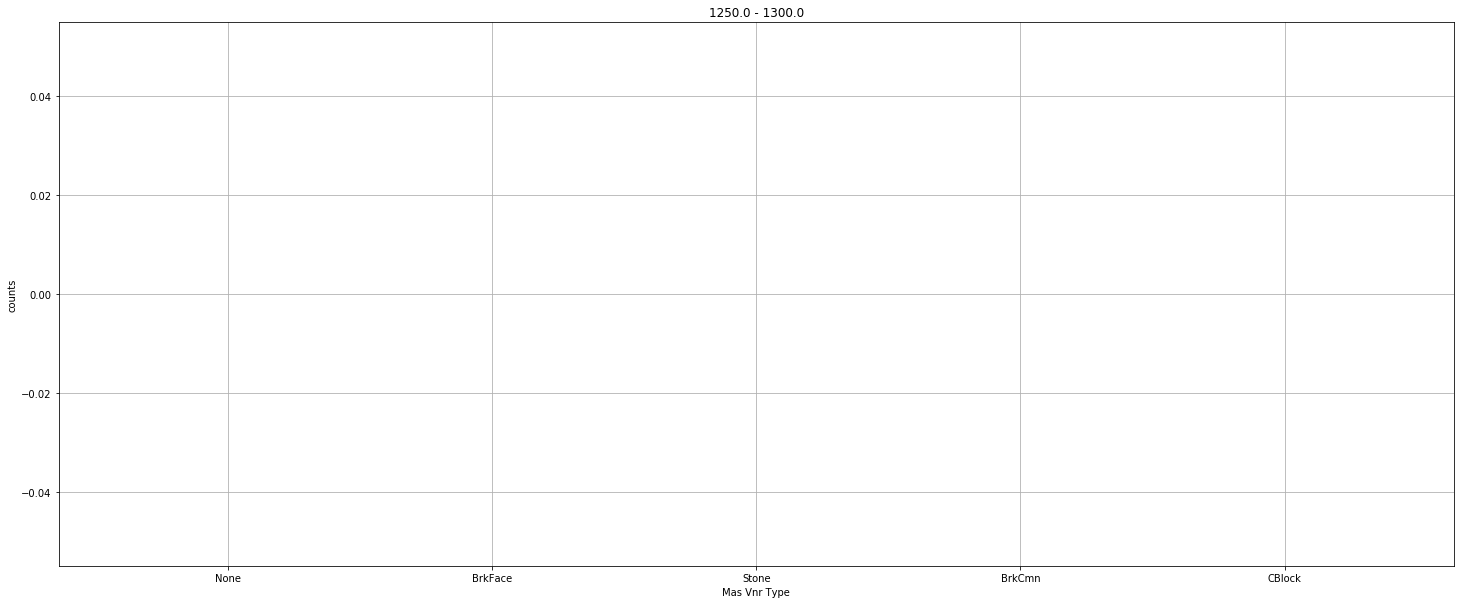

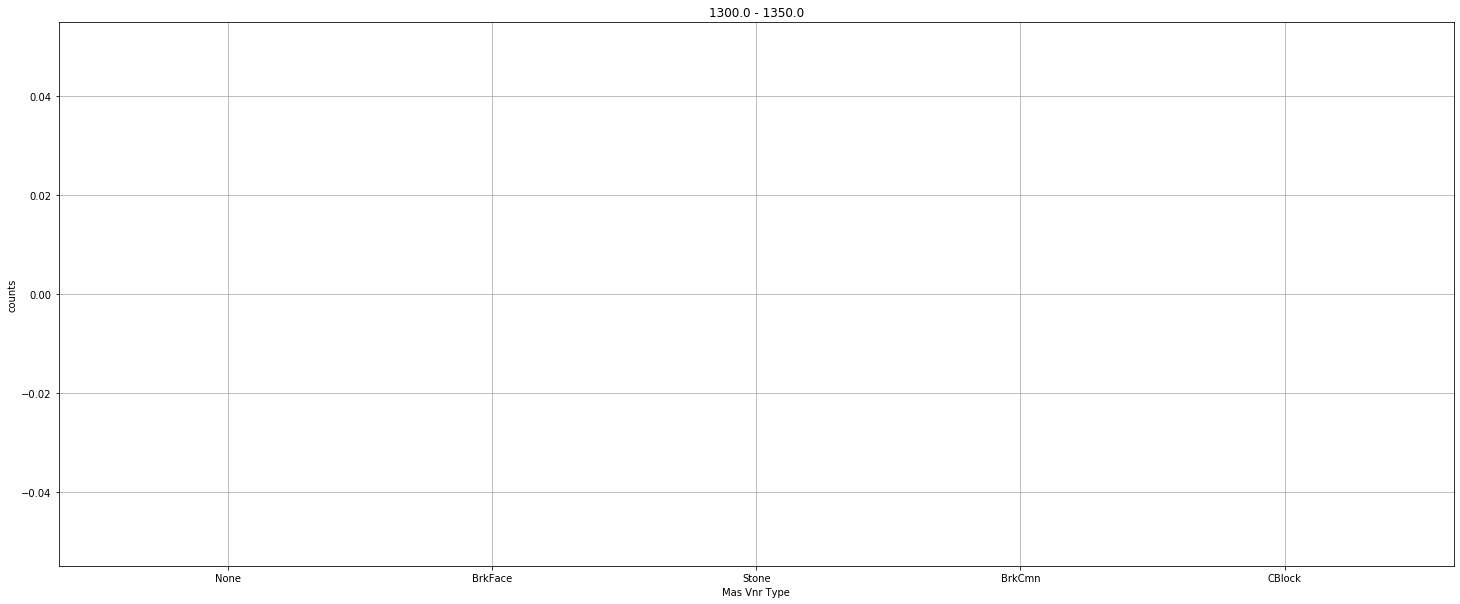

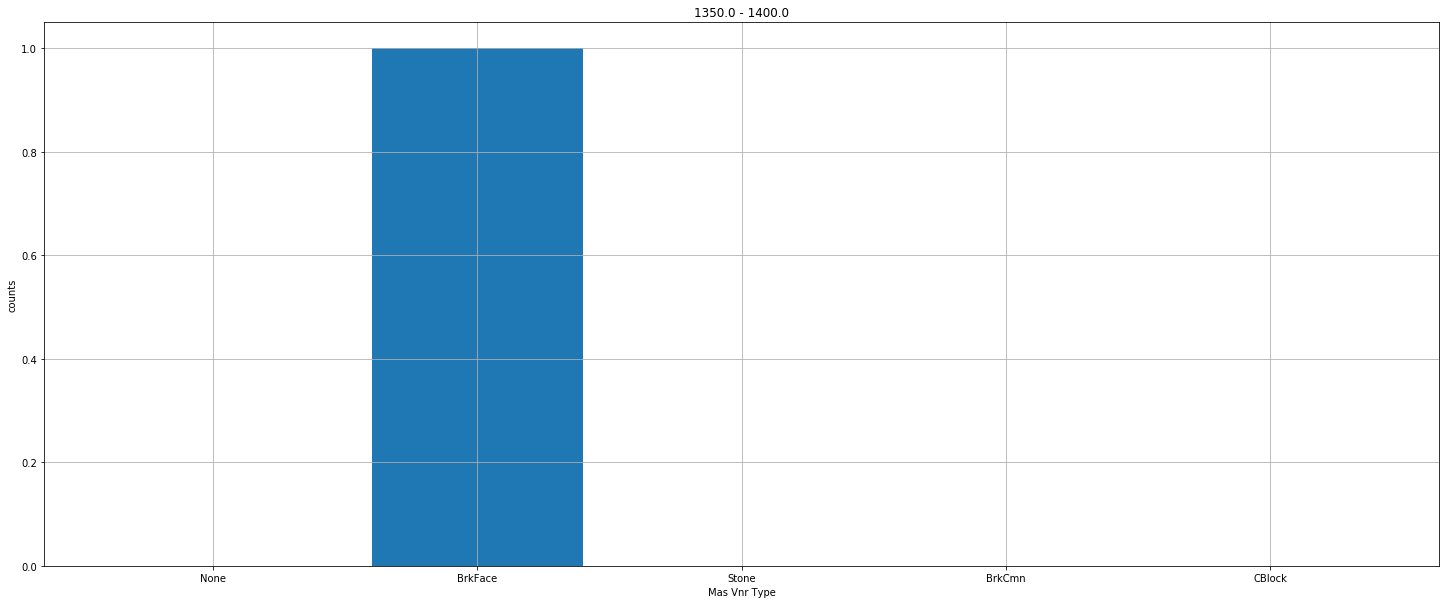

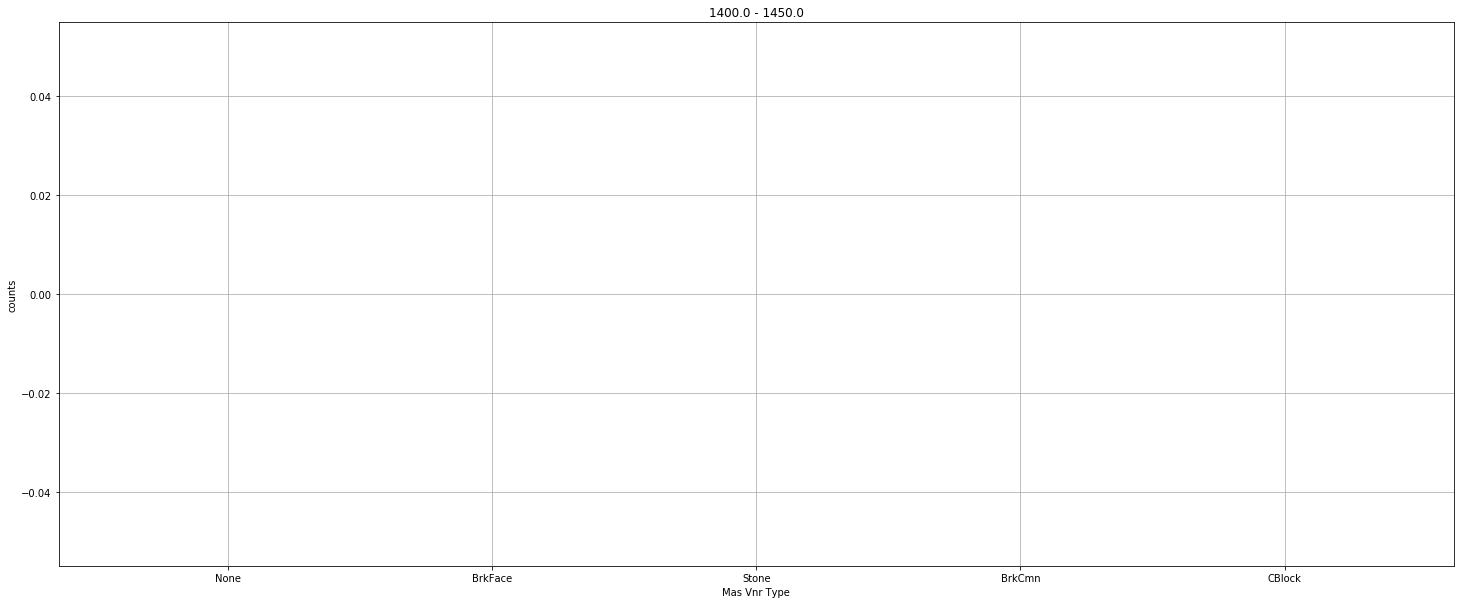

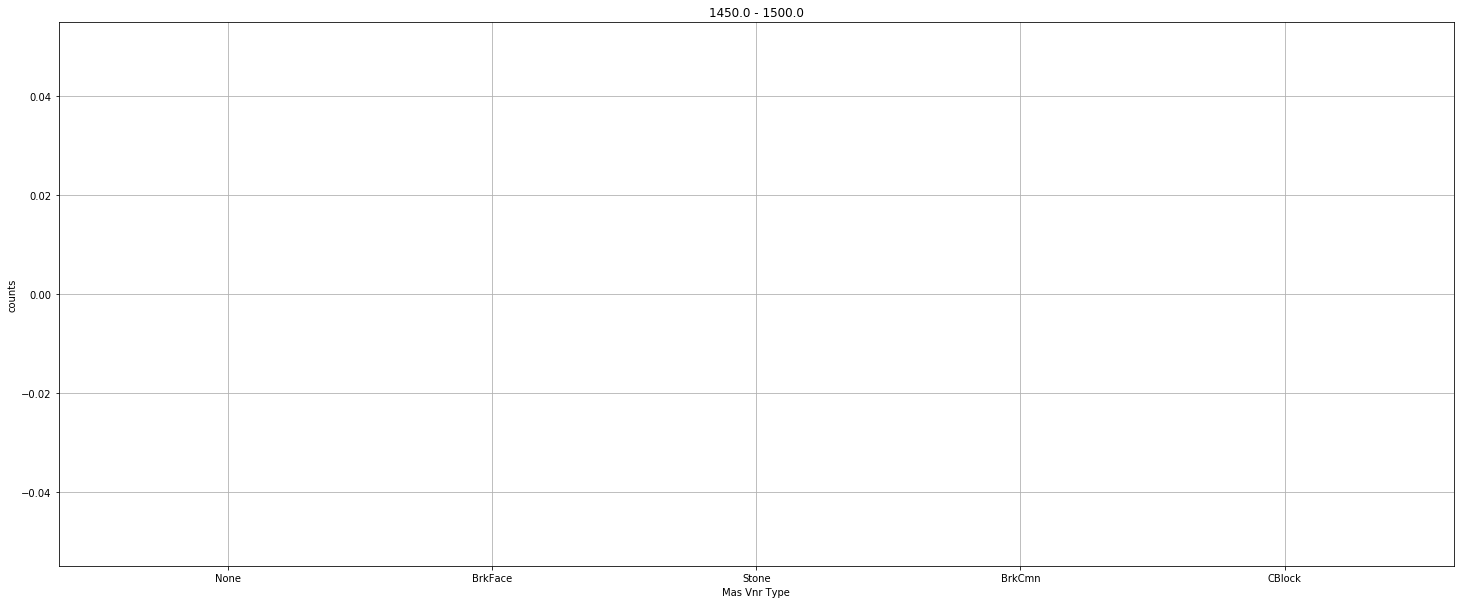

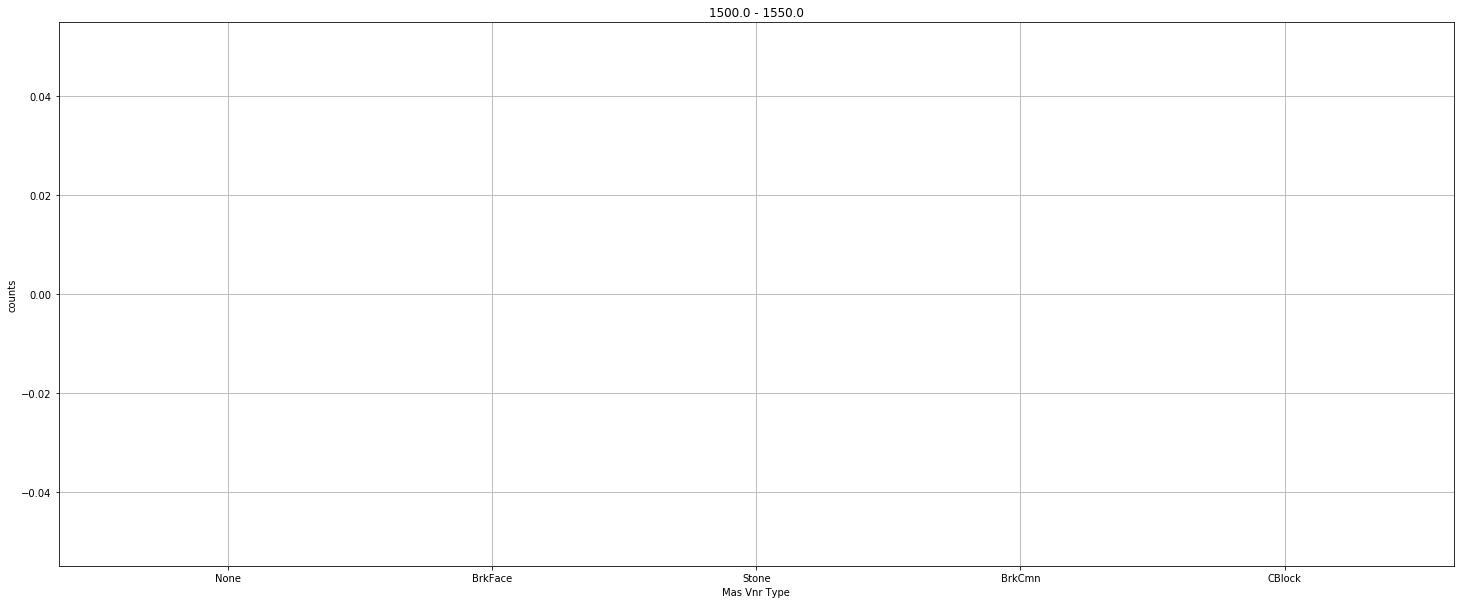

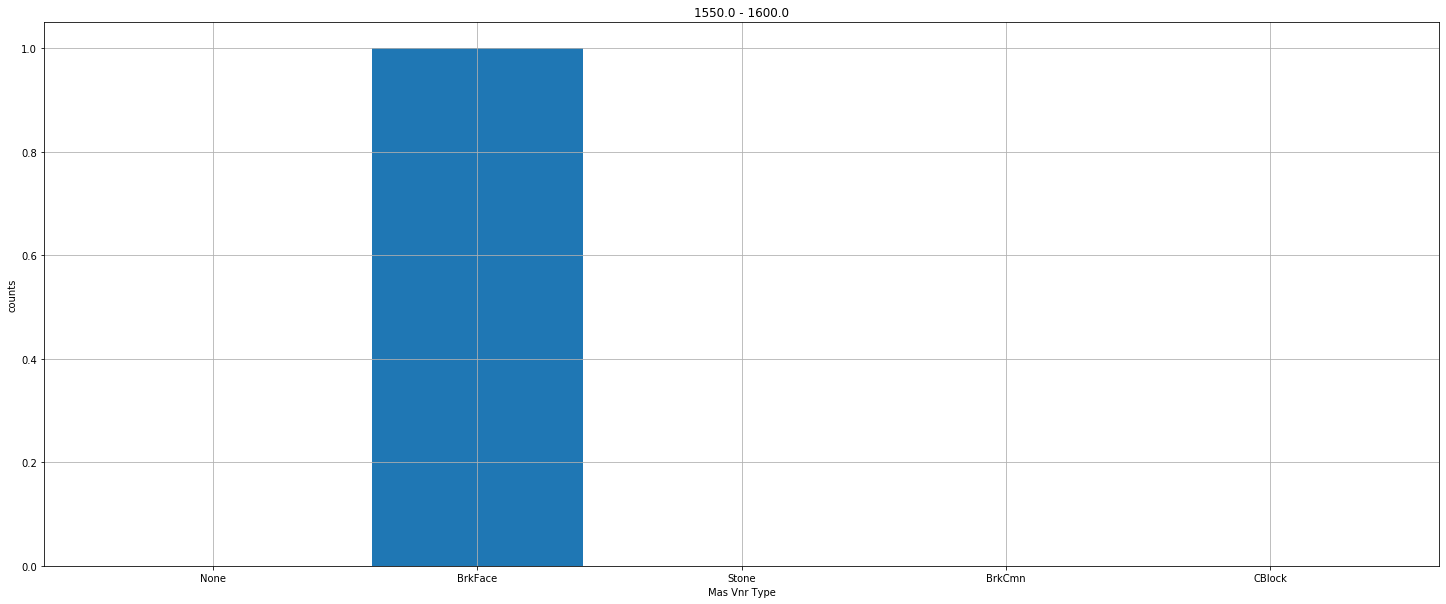

In [33]:
# 'Mas Vnr Type' ОТ 'Mas Vnr Area'
period = (train['Mas Vnr Area'].max() - train['Mas Vnr Area'].min()) / 32
start = train['Mas Vnr Area'].min()
fin = start + period + 1
for i in range(32):
    cols = ['None', 'BrkFace', 'Stone', 'BrkCmn', 'CBlock']

    cls = []

    for col in cols:
        cls.append(train[(train['Mas Vnr Type'] == col) & (train['Mas Vnr Area'] >= start) & (train['Mas Vnr Area'] < fin)][['Mas Vnr Type']]['Mas Vnr Type'].count())

    fig = plt.figure(figsize= (25,10))
    ax1 = fig.add_subplot()
    ax1.set_xlabel('Mas Vnr Type')
    ax1.set_ylabel('counts')
    ax1.set_title('{0} - {1}'.format(start, fin - 1))
    ax1.grid()
    ax1.bar(cols, cls) 
    start = fin - 1
    fin = start + period + 1

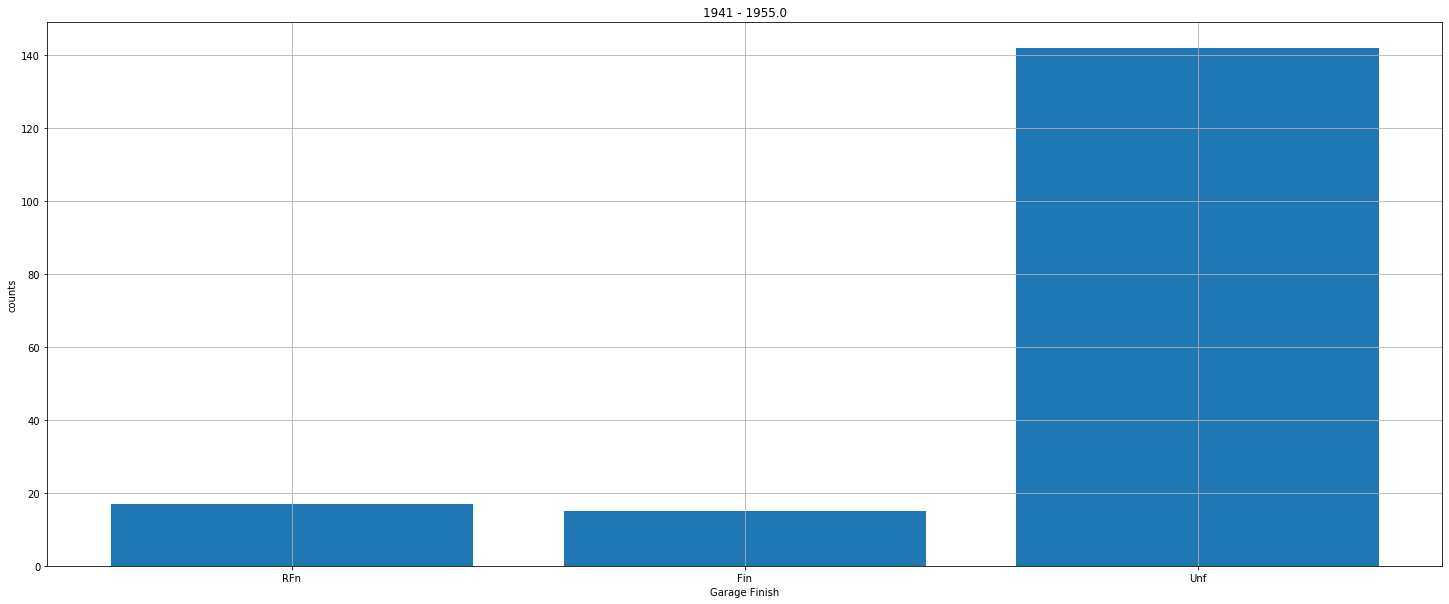

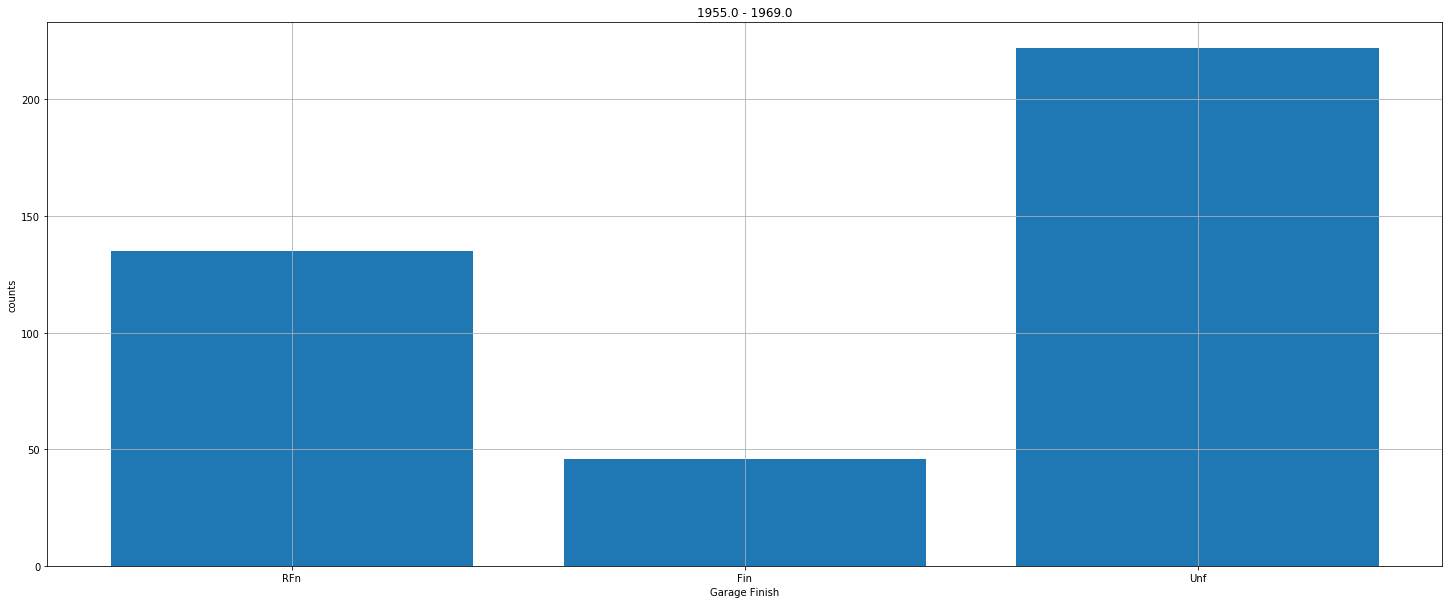

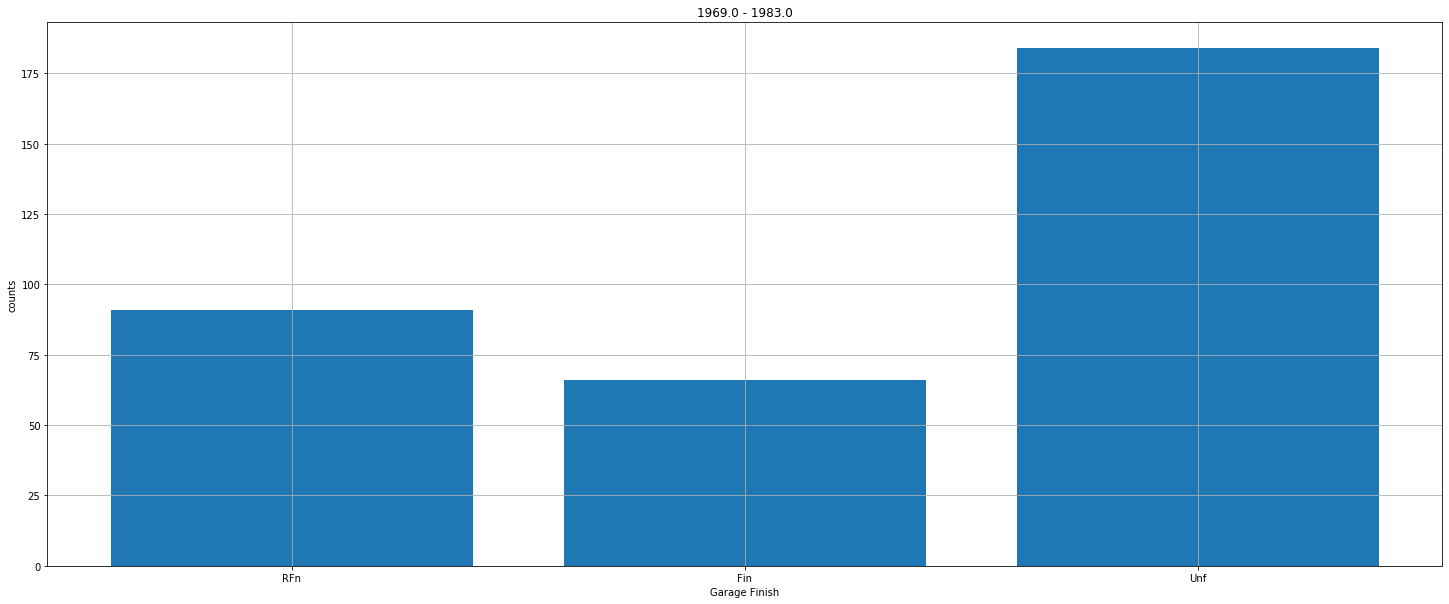

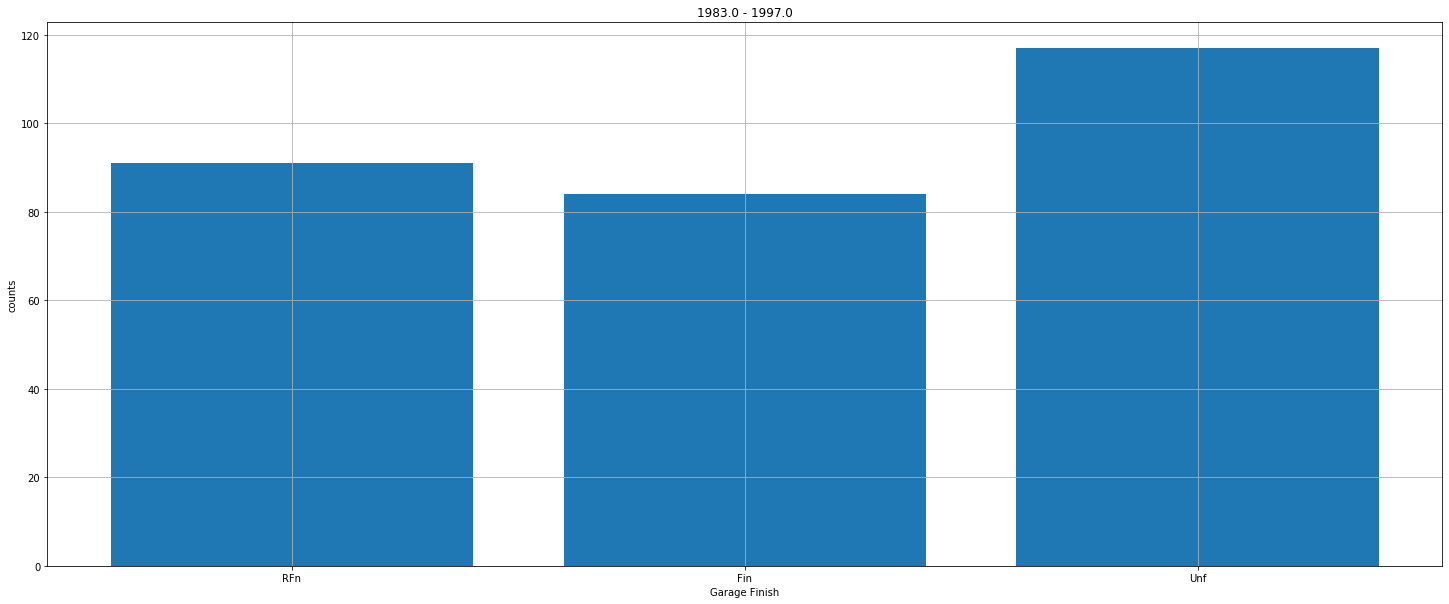

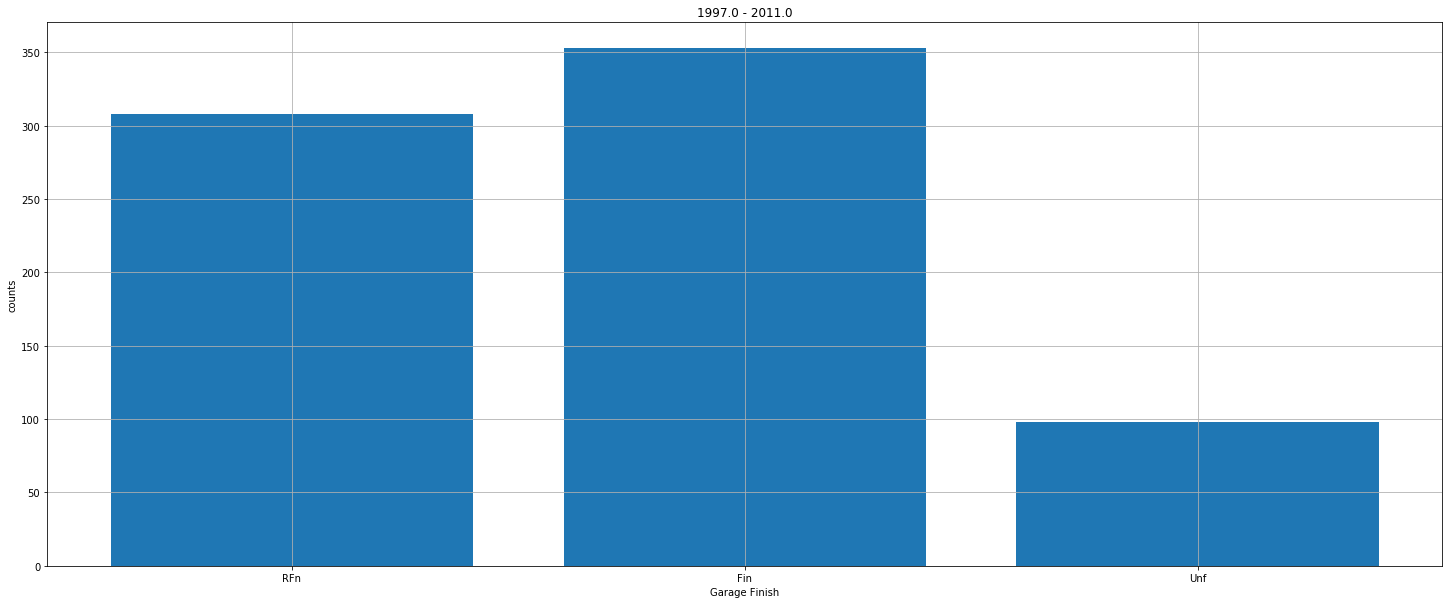

In [34]:
period = (2010 - 1941 + 1) / 5
start = 1941
fin = start + period + 1
for i in range(5):
    cols = ['RFn', 'Fin', 'Unf']

    cls = []

    for col in cols:
        cls.append(train[(train['Garage Finish'] == col) & (train['Garage Yr Blt'] >= start) & (train['Garage Yr Blt'] < fin)][['Garage Finish']]['Garage Finish'].count())

    fig = plt.figure(figsize= (25,10))
    ax1 = fig.add_subplot()
    ax1.set_xlabel('Garage Finish')
    ax1.set_ylabel('counts')
    ax1.set_title('{0} - {1}'.format(start, fin - 1))
    ax1.grid()
    ax1.bar(cols, cls) 
    start = fin - 1
    fin = start + period + 1

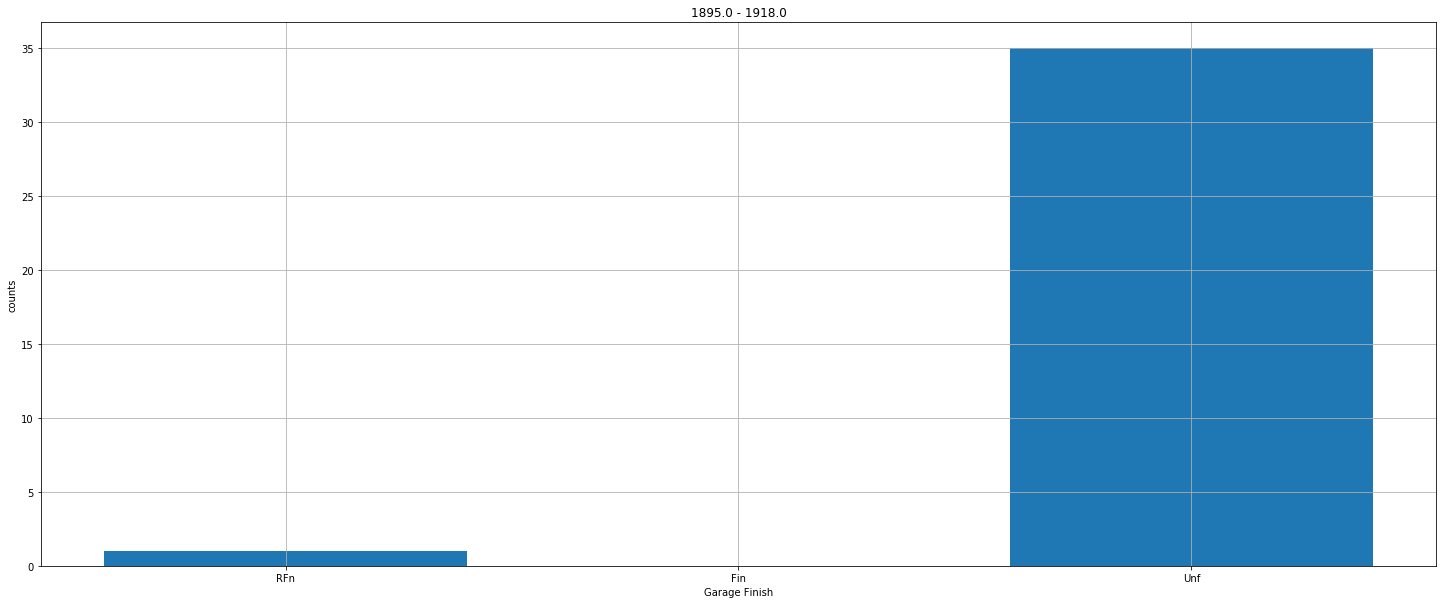

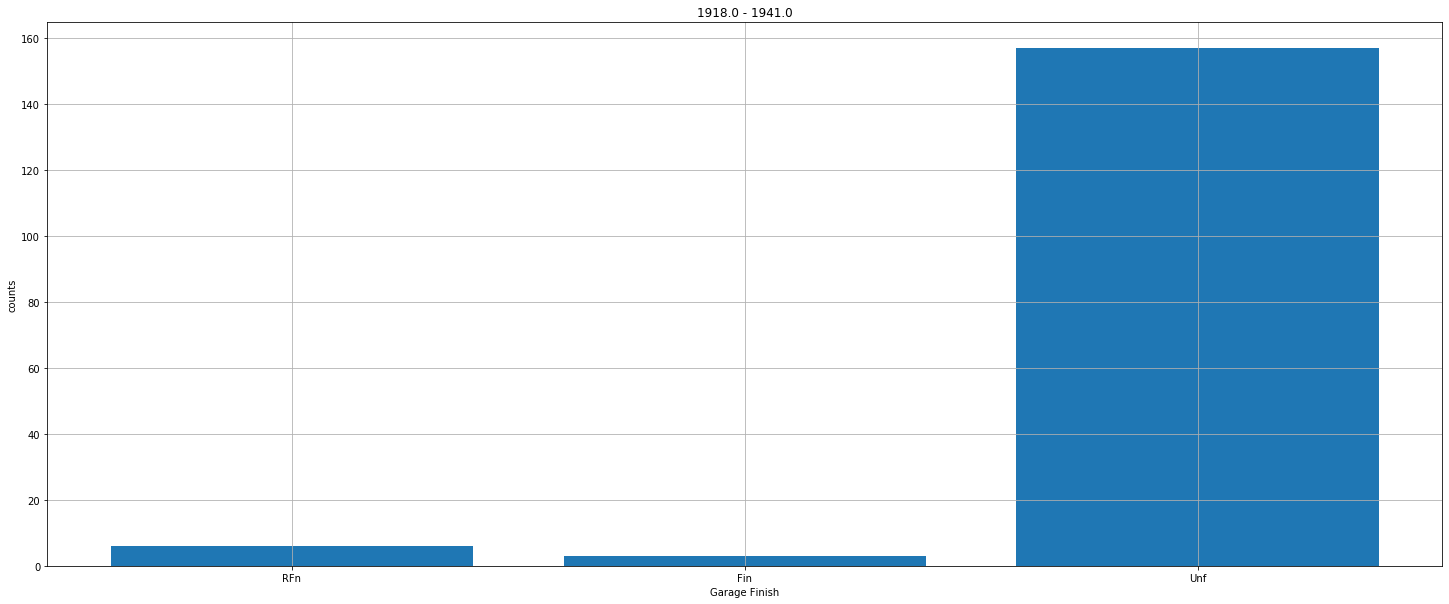

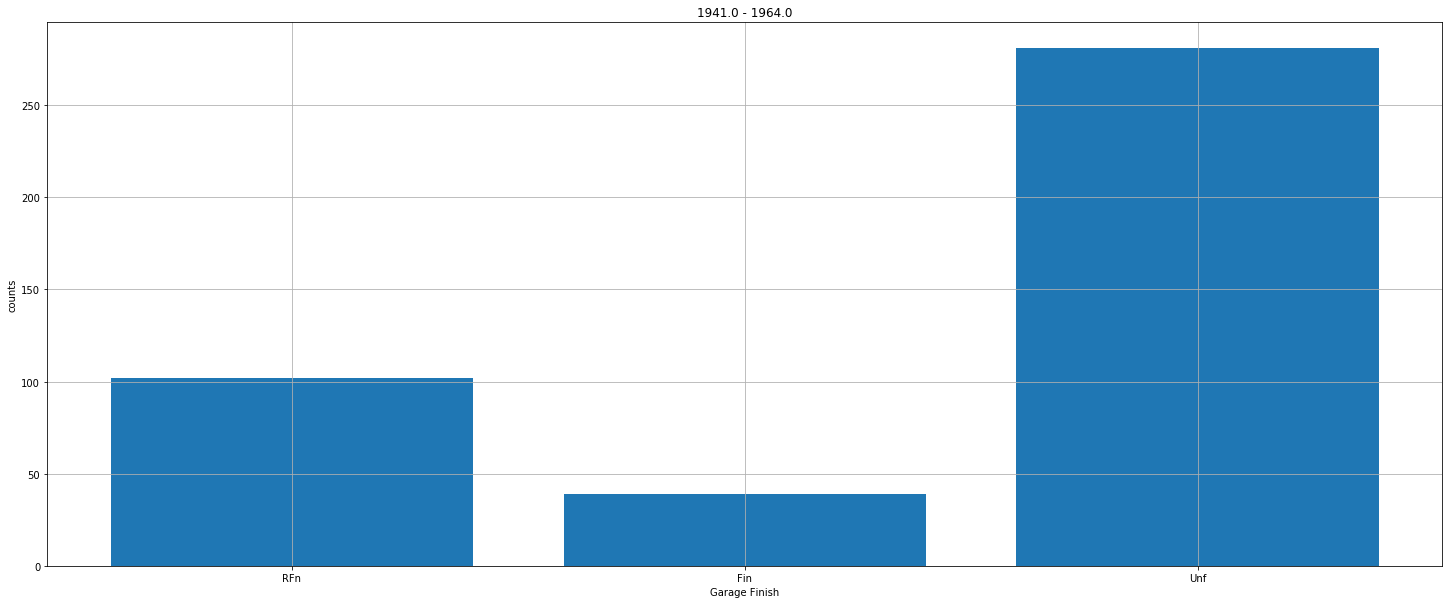

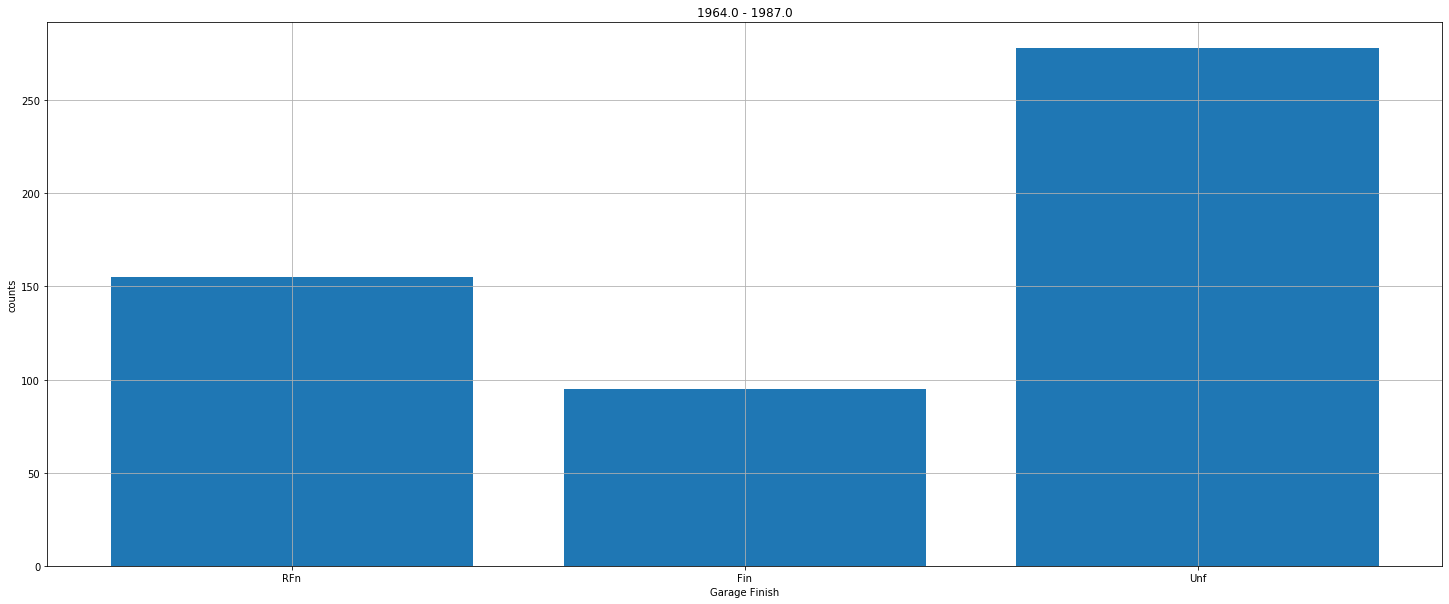

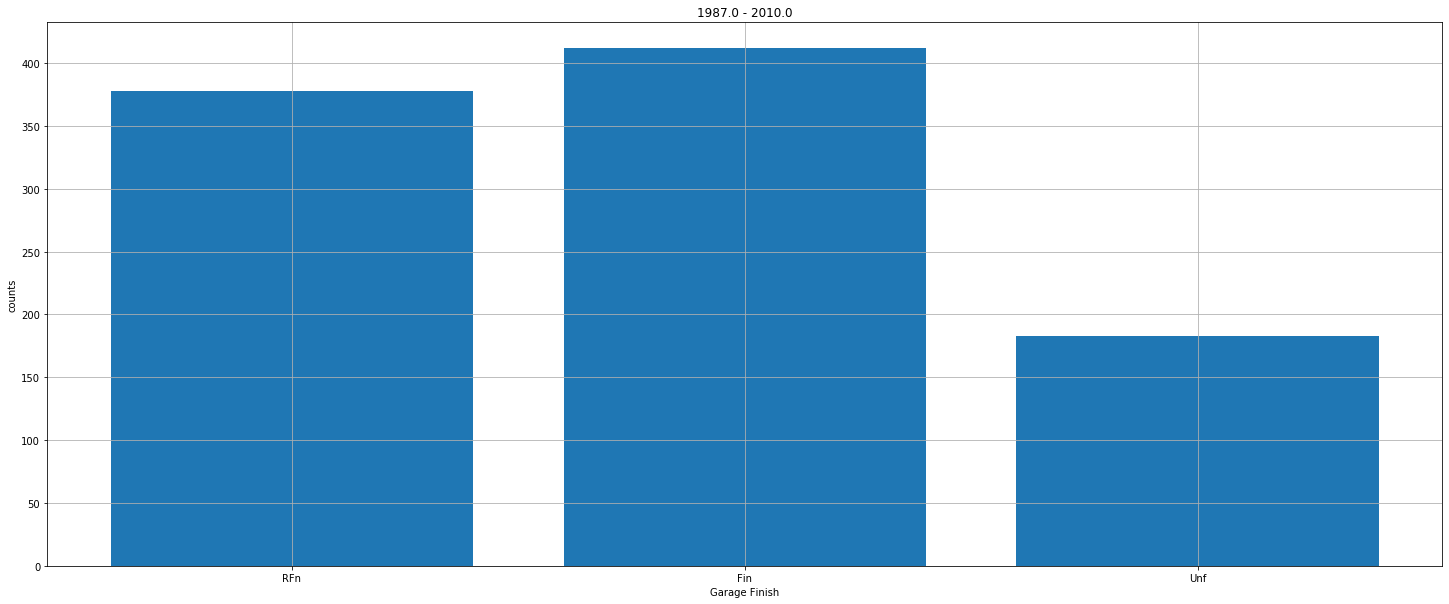

In [35]:
# 'Garage Finish' ОТ 'Garage Yr Blt'
period = (2010 - train['Garage Yr Blt'].min()) / 5
start = train['Garage Yr Blt'].min()
fin = start + period + 1
for i in range(5):
    cols = ['RFn', 'Fin', 'Unf']

    cls = []

    for col in cols:
        cls.append(train[(train['Garage Finish'] == col) & (train['Garage Yr Blt'] >= start) & (train['Garage Yr Blt'] < fin)][['Garage Finish']]['Garage Finish'].count())

    fig = plt.figure(figsize= (25,10))
    ax1 = fig.add_subplot()
    ax1.set_xlabel('Garage Finish')
    ax1.set_ylabel('counts')
    ax1.set_title('{0} - {1}'.format(start, fin - 1))
    ax1.grid()
    ax1.bar(cols, cls) 
    start = fin - 1
    fin = start + period + 1

# ПОДГОТОВКА ДАННЫХ

#'Mas Vnr Type' , 22      <=50 'None' >50 'BrkFace'
#'Mas Vnr Area'   22       MEDIAN, 
#2'Bsmt Qual'      67    Garage Finish == Unf TA
#'Bsmt Cond'      67      TOP, 
#'Bsmt Exposure' ,69       TOP ТАК КАК ВСЕГО 69 ЗНАЧЕНИЙ И ОНИ, СКОРЕЕ ВСЕГО, В ТОПЕ
#'BsmtFin Type 1',67       <=352.75 'Unf'   >352.75 'GLQ'
#'BsmtFin Type 2',68       TOP
#'Total Bsmt SF', 1       MEAN
#'Electrical',    1      TOP
#3'Garage Type',   120      CARS >=2 'Attchd'  | CARS == 1 & QUAL != TA  'Detchd' |  CARS == 1 & QUAL == TA & Garage Finish == Unf Detchd else 'Attchd' 
#'Garage Yr Blt', 122       MEDIAN
#1'Garage Finish', 122         ПОПРОБОВАТЬ СВЯЗАТЬ С Garage Yr Blt    <=1955 Unf
#'Garage Cars',   1         2
#'Garage Area',   1        MEAN
#'Garage Qual',   122       TOP
#'Garage Cond'    122       TOP

In [36]:
def delete_NaN(df):
    cols_med = ['Mas Vnr Area', 'Garage Yr Blt']
    cols_top = ['Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 2', 'Electrical', 'Garage Qual', 'Garage Cond']
    cols_mean = ['Total Bsmt SF', 'Garage Area']
    
    df['Garage Cars'][df['Garage Cars'].isnull()] = 2
    
    for col in cols_med:
        df[col][df[col].isnull()] = df[col].median()    
    for col in cols_top:
        df[col][df[col].isnull()] = df.describe(include=['object']).loc['top', col]        
    for col in cols_mean:
        df[col][df[col].isnull()] = df[col].mean()
        
    df['Mas Vnr Type'][(df['Mas Vnr Area'] <= 50) & df['Mas Vnr Type'].isnull()] = 'None'
    df['Mas Vnr Type'][(df['Mas Vnr Area'] > 50) & df['Mas Vnr Type'].isnull()] = 'BrkFace'
    
    df['BsmtFin Type 1'][(df['BsmtFin SF 1'] <= 352.75) & df['BsmtFin Type 1'].isnull()] = 'Unf'
    df['BsmtFin Type 1'][(df['BsmtFin SF 1'] > 352.75) & df['BsmtFin Type 1'].isnull()] = 'GLQ'
    
    """     
    RFn = df['Garage Finish'][df['Garage Yr Blt'] > 1955].value_counts()['RFn']
    Unf = df['Garage Finish'][df['Garage Yr Blt'] > 1955].value_counts()['Unf']
    Fin = df['Garage Finish'][df['Garage Yr Blt'] > 1955].value_counts()['Fin']
    j = df.columns.get_loc('Garage Finish')
    count = df['Garage Finish'][df['Garage Yr Blt'] > 1955].count()
    df['Garage Finish'][(df['Garage Yr Blt'] == 2207) & df['Garage Finish'].isnull()] = 'Unf'
    df['Garage Finish'][(df['Garage Yr Blt'] <= 1955) & df['Garage Finish'].isnull()] = 'Unf'
    for i in range(df.shape[0]): 
        if (df.iloc[i,j] == None):
            r = random.uniform(0, 1)
            if (r < RFn / count):
                df.iloc[i,j] = 'RFn'
            elif (r >= RFn / count) & (r < Unf / count):
                df.iloc[i,j] = 'Unf'
            else:
                df.iloc[i,j] = 'Fin'
    """
    
    df['Garage Finish'][df['Garage Finish'].isnull()] = 'Unf'
    
    df['Bsmt Qual'][(df['Garage Finish'] == 'Unf') & df['Bsmt Qual'].isnull()] = 'TA'
    df['Bsmt Qual'][(df['Garage Finish'] != 'Unf') & df['Bsmt Qual'].isnull()] = 'Gd'
    
    df['Garage Type'][(df['Garage Cars'] != 1) & df['Garage Type'].isnull()] = 'Attchd'
    df['Garage Type'][(df['Garage Cars'] == 1) & (df['Garage Qual'] != 'TA') & df['Garage Type'].isnull()] = 'Detchd'
    df['Garage Type'][(df['Garage Cars'] == 1) & (df['Garage Qual'] == 'TA') & (df['Garage Finish'] == 'Unf')] = 'Detchd'
    df['Garage Type'][(df['Garage Cars'] == 1) & (df['Garage Qual'] == 'TA') & (df['Garage Finish'] != 'Unf') & df['Garage Type'].isnull()] = 'Attchd'
    
def one_hot(df, col):    
    dfs = pd.get_dummies(df[col], prefix=col)
    df_ = pd.concat([df, dfs], axis=1)
    df_ = df_.drop(col, axis=1)
    return df_

def transform_df(df):
    unique_counts = pd.DataFrame.from_records([(col, df[col].dtype, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Type', 'Num_Unique']).sort_values(by=['Num_Unique'])
    df_ = df.copy()
    for col in df.columns:
        if (df_[col].dtype == 'int32') | (df_[col].dtype == 'float32'):
            df_[col] = (df_[col] - df_[col].mean()) / df_[col].std()
        elif (df_[col].dtype == object) & (unique_counts[unique_counts['Column_Name'] == col][['Num_Unique']].values[0][0] == 2):
            values = df_[col].unique()
            df_[col].replace(values, [1, 0], inplace=True) 
        elif (df_[col].dtype == object) & (unique_counts[unique_counts['Column_Name'] == col][['Num_Unique']].values[0][0] < 10):
            df_ = one_hot(df_, col).copy()
        elif (df_[col].dtype == object) & (unique_counts[unique_counts['Column_Name'] == col][['Num_Unique']].values[0][0] >= 10):
            #df_[col] = df_[col].astype('category') 
            values = df_[col].unique()
            l = [i for i in range(len(values))] 
            df_[col].replace(values, l, inplace=True)
    return df_

In [37]:
X = train.copy()
delete_NaN(X)
X = train.drop(unnesessary, axis=1)
X = X.drop('SalePrice', axis=1)
X = transform_df(X).copy()
X.head()

,Street,Neighborhood,Overall Qual,Year Built,Year Remod/Add,Exterior 1st,Exterior 2nd,Mas Vnr Area,Total Bsmt SF,Central Air,1st Flr SF,Gr Liv Area,Full Bath,Garage Yr Blt,Garage Cars,Garage Area,Sale Type,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Metal,Roof Matl_Roll,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_CBlock,Mas Vnr Type_None,Mas Vnr Type_Stone,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Bsmt Qual_Ex,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA,Bsmt Cond_Ex,Bsmt Cond_Fa,Bsmt Cond_Gd,Bsmt Cond_Po,Bsmt Cond_TA,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,BsmtFin Type 1_ALQ,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_ALQ,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Cond_Ex,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,1,0,0.617984,1.148406,1.063196,0,0,-0.568429,0.341658,1,0.116160,-0.566331,-1.070984,1.091488,0.286024,0.459650,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0.617984,0.590115,0.297582,1,1,0.697131,2.400642,1,2.572184,1.344406,0.736199,0.431389,1.597316,1.038356,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,1,1,-0

In [40]:
y = train['SalePrice']
test_ = test.copy()
delete_NaN(test_)
test_ = test.drop(unnesessary, axis=1)
test_ = transform_df(test_).copy()
test_.head()

,Street,Neighborhood,Overall Qual,Year Built,Year Remod/Add,Exterior 1st,Exterior 2nd,Mas Vnr Area,Total Bsmt SF,Central Air,1st Flr SF,Gr Liv Area,Full Bath,Garage Yr Blt,Garage Cars,Garage Area,MS Zoning_C (all),MS Zoning_FV,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_CompShg,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Bsmt Qual_Ex,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_TA,Bsmt Cond_Ex,Bsmt Cond_Fa,Bsmt Cond_Gd,Bsmt Cond_Po,Bsmt Cond_TA,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,BsmtFin Type 1_ALQ,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_ALQ,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,Heating_GasA,Heating_GasW,Heating_Wall,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_TA,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_TA,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,1,0,-1.500753,0.834668,0.593491,0,0,-0.575748,-0.078517,1,-0.359355,-0.999226,-0.896713,NaN,-2.285963,-2.176416,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,1,0.717094,-1.601749,1.076964,1,1,-0.575748,0.225874,0,0.099867,1.220985,-0.896713,-1.936223,-0.958220,-0.689752,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1,2,0.717094,1.206898,1.125311,0,0,0.010133,0.896568,1,0.661740,-0.220711,0.939294,1.178006,0.369522,0.060659,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0

In [41]:
X.to_csv('data/X_housing.csv')
DataFrame(y).to_csv('data/Y_housing.csv')
test_.to_csv('data/test_housing.csv')